# Final Project: Overview

# Objective

The objective of this project is for you to demonstrate your mastery of the Machine Learning process
**using Neural Networks**.



In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from datetime import datetime

# For neural network modeling
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Input, Dense, Concatenate, Flatten, Conv1D, Conv2D
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import TimeSeriesSplit


# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split


# For time series modeling
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from arch import arch_model

# Suppress TensorFlow warnings
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Import necessary libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
from scipy.optimize import minimize
import joblib
from tensorflow.keras.models import load_model


# Defining the Problem

The primary objective is to predict the next day's return of AAPL stock based on historical price data. The return is defined as the percent change of the Close feature from time \( t-1 \) to time \( t \).

## Regression vs. Classification

This problem is best approached as a **regression task** because the target variable—the stock return—is a continuous numerical value. We aim to predict the exact percentage change rather than categorizing the return into discrete classes (e.g., "up" or "down"), which would make it a classification problem.

**Justification:** Treating the problem as a regression task allows us to capture the magnitude of the returns, providing more nuanced predictions that are essential for financial decision-making.

# Performance Metric

An appropriate performance metric for this regression task is the **Mean Squared Error (MSE)** or the **Mean Absolute Error (MAE)**.

- **MSE** penalizes larger errors more severely, which is useful if large deviations are particularly undesirable.
- **MAE** provides a linear penalty for errors, making it more robust to outliers.

**Justification:** Financial returns can exhibit volatility and outliers. Using MAE can provide a balanced view of model performance, but MSE might be preferable if we want to penalize larger errors more.

The loss function to use during training is typically the mean squared error, but if it
 have a lot of outliers in the training set, I may prefer to use the mean absolute
 error instead. Alternatively, I can use the Huber loss, which is a combination of
 both.

# Data Preparation

## Data Selection

- **Ticker:** Focus on AAPL data for initial modeling.
- **Features:** Use the Close or Adjusted Close prices. Adjusted Close accounts for corporate actions like dividends and stock splits. Using Adjusted Close can provide a more accurate reflection of the stock's value over time.

**Decision:** Use **Adjusted Close** to account for corporate actions that affect the stock price.

In [2]:
def load_data(data_dir, ticker='AAPL'):
    """
    Load stock data for the specified ticker from the given directory.

    Parameters:
        data_dir (str): Path to the data directory.
        ticker (str): Stock ticker symbol.

    Returns:
        df (DataFrame): Pandas DataFrame containing the stock data.
    """
    file_path = os.path.join(data_dir, f'{ticker}.csv')
    df = pd.read_csv(file_path)
    return df

# Load training data
train_data_dir = './Data/train'  # Adjust the path as needed
df = load_data(train_data_dir)
hold_out_data_dir = './Data/sample'  # Adjust the path as needed

In [3]:
df

Dt  Adj Close    Close  Div  Factor      High      Low  \
0     2000-01-03     3.4785  111.938  0.0     1.0  112.5000  101.688   
1     2000-01-04     3.1852  102.500  0.0     1.0  110.6250  101.188   
2     2000-01-05     3.2318  104.000  0.0     1.0  110.5630  103.000   
3     2000-01-06     2.9521   95.000  0.0     1.0  107.0000   95.000   
4     2000-01-07     3.0920   99.500  0.0     1.0  101.0000   95.500   
...          ...        ...      ...  ...     ...       ...      ...   
4272  2016-12-23   111.3073  116.520  0.0     1.0  116.5255  115.590   
4273  2016-12-27   112.0142  117.260  0.0     1.0  117.8000  116.490   
4274  2016-12-28   111.5366  116.760  0.0     1.0  118.0170  116.200   
4275  2016-12-29   111.5079  116.730  0.0     1.0  117.1094  116.400   
4276  2016-12-30   110.6386  115.820  0.0     1.0  117.2000  115.430   

          Open       Volume  
0     104.8750  133949200.0  
1     108.2500  128094400.0  
2     103.7500  194580400.0  
3     106.1183  191993200.0  
4      96.5000  115183600.0  
...        ...          ...  
4272  115.5900   14249500.0  
4273  116.5200   18296900.0  
4274  117.5200   20905900.0  
4275  116.4500   15039500.0  
4276  116.6577   30586300.0  

[4277 rows x 9 columns]

In [4]:
def load_all_data(data_dir):
    """
    Load stock data for all CSV files in the given directory and combine them into one DataFrame.

    Parameters:
        data_dir (str): Path to the data directory.

    Returns:
        df (DataFrame): Pandas DataFrame containing the combined stock data for all tickers.
    """
    all_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
    df_list = []

    for file_name in all_files:
        file_path = os.path.join(data_dir, file_name)
        temp_df = pd.read_csv(file_path)
        ticker = file_name.replace('.csv', '')
        temp_df['Ticker'] = ticker

        df_list.append(temp_df)

    # Concatenate all individual DataFrames into one
    df = pd.concat(df_list, ignore_index=True)

    return df

# Load all training data
train_data_dir = './Data/train'  # Adjust the path as needed
df2 = load_all_data(train_data_dir)
df3 = load_all_data(hold_out_data_dir)

In [5]:
import pandas as pd

def pivot_dataframe(df, index_cols=['Dt'], ticker_col='Ticker'):
    """
    Pivot the dataframe to a wide format with the specified ticker column as new columns.

    Parameters:
    - df (pd.DataFrame): The input DataFrame to pivot.
    - index_cols (list of str): Columns to set as the index in the pivoted DataFrame.
                                Defaults to ['Dt'].
    - ticker_col (str): The column whose unique values will become the new columns.
                        Defaults to 'Ticker'.

    Returns:
    - pd.DataFrame: The pivoted DataFrame in wide format with flattened column names.
    """
    # Identify the value columns by excluding index and ticker columns
    value_cols = [col for col in df.columns if col not in index_cols + [ticker_col]]
    
    # Pivot the DataFrame so that the ticker values become the new columns
    df_wide = df.pivot(index=index_cols, columns=ticker_col, values=value_cols)
    
    # Check if the pivot resulted in a MultiIndex for columns
    if isinstance(df_wide.columns, pd.MultiIndex):
        # Flatten the MultiIndex columns
        df_wide.columns = [f"{val}_{key}" for key, val in df_wide.columns]
    else:
        # If columns are not MultiIndex, append the ticker column name
        df_wide.columns = [f"{val}_{ticker_col}" for val in df_wide.columns]
    
    # Reset the index to turn the index columns back into regular columns
    df_wide = df_wide.reset_index()
    
    return df_wide


df_wide = pivot_dataframe(df2)
df_wide2 = pivot_dataframe(df3)


In [6]:
# index_cols = ['Dt']  # Columns you want to remain as the index
# value_cols = [col for col in df2.columns if col not in index_cols + ['Ticker']]

# # Pivot the table so that Ticker moves into the column level
# df_wide = df2.pivot(index=index_cols, columns='Ticker', values=value_cols)

# # df_wide now has a MultiIndex on columns, something like:
# #        Open          Close         Volume       
# # Ticker AAPL   MSFT   AAPL   MSFT   AAPL   MSFT
# # Date
# # ...

# # Flatten the MultiIndex columns
# df_wide.columns = [f"{val}_{key}" for key, val in df_wide.columns]

# # Resetting the index if needed (optional)
# df_wide = df_wide.reset_index()

# # df_wide now is in the desired wide format.
# print(df_wide.head())


In [7]:
# Find the first non-NaN value for each column
start_times = {}
for col in df_wide.columns:
    if col != 'Dt':  # Exclude the 'Dt' column
        # Find the first non-NaN index for the column
        first_valid_index = df_wide[col].first_valid_index()
        if first_valid_index is not None:
            start_times[col] = df_wide.loc[first_valid_index, 'Dt']

# Convert to a DataFrame for better readability
start_times_df = pd.DataFrame(list(start_times.items()), columns=['Stock', 'Start Date'])

# Extract unique stock names by removing suffixes (e.g., '_Adj Close', '_Volume')
start_times_df['Cleaned Stock'] = start_times_df['Stock'].str.extract(r'([^_]+)_')

# Keep the earliest start date for each stock
unique_start_times_df = start_times_df.groupby('Cleaned Stock')['Start Date'].min().reset_index()

# Rename columns for clarity
unique_start_times_df.rename(columns={'Cleaned Stock': 'Stock', 'Start Date': 'First Available Date'}, inplace=True)

# Display the cleaned result
print(unique_start_times_df.sort_values('First Available Date'))



   Stock First Available Date
0   AAPL           2000-01-03
21   XLU           2000-01-03
19   XLP           2000-01-03
18   XLK           2000-01-03
17   XLI           2000-01-03
16   XLF           2000-01-03
15   XLE           2000-01-03
14   XLB           2000-01-03
12   SPY           2000-01-03
22   XLV           2000-01-03
11  NVDA           2000-01-03
8   INTC           2000-01-03
7    IBM           2000-01-03
4   CSCO           2000-01-03
2   ADBE           2000-01-03
10  MSFT           2000-01-03
23   XLY           2000-01-03
1    ACN           2001-07-19
3    CRM           2004-06-23
6   GOOG           2004-08-19
9     MA           2006-05-25
13     V           2008-03-19
5     FB           2012-05-18
20  XLRE           2015-10-08


In [8]:
# df_wide['AAPL_Return'] = df_wide['AAPL_Adj Close'].pct_change()
# df_wide['XLRE_Return'] = df_wide['XLRE_Adj Close'].pct_change()

# # Drop NaN rows (caused by pct_change)
# returns = df_wide[['AAPL_Return', 'XLRE_Return']].dropna()

# # Cross-correlation
# correlation = returns['AAPL_Return'].corr(returns['XLRE_Return'])
# print(f"Cross-correlation between AAPL and XLRE: {correlation}")
# #Cross-correlation between AAPL and XLRE: 0.23348856543177152

The cross-correlation between AAPL and XLRE is 0.2335, indicating a weak positive relationship between the returns of AAPL and XLRE. Given the weak correlation and the relatively limit computational power, XLRE will be exclude and I'll use data from 2000-05-18. 

In [9]:
# Drop all columns related to XLRE
df_wide = df_wide[df_wide.columns[~df_wide.columns.str.contains('XLRE')]]

# Convert 'Dt' column to datetime if it's not already
df_wide['Dt'] = pd.to_datetime(df_wide['Dt'])

# Filter the data for rows from '2012-05-18' to the present
df_wide_filtered = df_wide[df_wide['Dt'] >= '2012-05-18']

df_wide_filtered.isna().sum().sum()

0

## Calculating Returns

Compute the daily returns as:

$\text{Return}_t = \left( \frac{\text{Adj Close}_t - \text{Adj Close}_{t-1}}{\text{Adj Close}_{t-1}} \right) \times 100\% $


 **Why Use Adjusted Close Prices?**

When working with historical stock data, it's crucial to account for corporate actions that can affect the stock price, such as:

- **Dividends:** Cash payments made to shareholders.
- **Stock Splits:** Increasing the number of shares while proportionally decreasing the price per share.
- **Rights Offerings:** Opportunities for existing shareholders to purchase additional shares at a discount.
- **Other Corporate Actions:** Mergers, acquisitions, spin-offs, etc.

The **Close** price reflects the last trading price of the stock on a given day but does not adjust for these corporate actions. In contrast, the **Adjusted Close** price modifies the Close price to account for these events, providing a more accurate reflection of the stock's true economic value over time.

 **Benefits of Using Adjusted Close Prices:**

1. **Accurate Return Calculations:**
   - **Dividends:** When a company pays a dividend, the stock price typically drops by the dividend amount. The Adjusted Close price accounts for this, ensuring that returns are not understated.
   - **Stock Splits:** A stock split changes the number of shares and the price per share but not the total value held. Adjusted Close prices account for splits, preventing artificial drops or spikes in price data.

2. **Consistency Over Time:**
   - Adjusted Close prices provide a continuous and consistent price series, essential for time-series analysis and modeling.

3. **Improved Technical Analysis:**
   - Technical indicators calculated using Adjusted Close prices are more reliable because they reflect the true performance of the stock.

In [10]:
def calculate_returns(df):
    """
    Calculate daily returns based on Adjusted Close prices.

    Parameters:
        df (DataFrame): Stock data.

    Returns:
        df (DataFrame): DataFrame with a new 'Return' column.
    """
    df['Return'] = df['Adj Close'].pct_change() * 100
    df.dropna(inplace=True)
    return df

df = calculate_returns(df)

In [11]:
df['Return']

1      -8.431795
2       1.463016
3      -8.654620
4       4.738999
5      -1.759379
          ...   
4272    0.197772
4273    0.635089
4274   -0.426375
4275   -0.025731
4276   -0.779586
Name: Return, Length: 4276, dtype: float64

In [12]:
def calculate_returns(df):
    """
    Calculate daily returns for all stocks based on Adjusted Close prices.

    Parameters:
        df (DataFrame): Stock data in wide format.

    Returns:
        df (DataFrame): DataFrame with new columns for daily returns of each stock.
    """
    # Make a copy of the DataFrame to avoid SettingWithCopyWarning
    df = df.copy()

    # Identify all columns related to Adjusted Close prices
    adj_close_cols = [col for col in df.columns if '_Adj Close' in col]

    # Create new columns for returns
    for col in adj_close_cols:
        return_col = col.replace('_Adj Close', '_Return')
        df.loc[:, return_col] = df[col].pct_change() * 100  # Use .loc for setting values

    # Drop rows with NaN (caused by pct_change) if needed
    df = df.dropna()

    return df

# Apply the function to calculate returns
df_wide_filtered = calculate_returns(df_wide_filtered)
df_wide2 = calculate_returns(df_wide2)

In [13]:
def calculate_log_returns(df):
    """
    Calculate daily log returns based on Adjusted Close prices.

    Parameters:
        df (DataFrame): Stock data.

    Returns:
        df (DataFrame): DataFrame with a new 'Return' column.
    """
    df['LReturn'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1)) * 100
    df.dropna(inplace=True)
    return df

df = calculate_log_returns(df)

In [14]:
def add_log_return(df):
    """
    Add Log Return as a feature for all stocks.

    Parameters:
        df (DataFrame): Stock data with multiple 'Adj Close' columns.

    Returns:
        df (DataFrame): DataFrame with Log Return features added for each stock.
    """
    # Identify all columns with 'Adj Close'
    adj_close_cols = [col for col in df.columns if 'Adj Close' in col]

    # List to store log return DataFrames
    log_return_dfs = []

    for col in adj_close_cols:
        stock_name = col.split('_')[0]  # Extract stock name, e.g., "AAPL"

        # Calculate log return
        log_return = np.log(df[col] / df[col].shift(1)) * 100
        log_return_dfs.append(log_return.rename(f'{stock_name}_Log_Return'))

    # Combine all the new columns into a DataFrame
    log_return_df = pd.concat(log_return_dfs, axis=1)

    # Concatenate with the original DataFrame
    df = pd.concat([df, log_return_df], axis=1)

    # Drop rows with NaN values caused by log return calculations
    df.dropna(inplace=True)

    return df

df_wide_filtered = add_log_return(df_wide_filtered)
df_wide2 = add_log_return(df_wide2)

In [15]:
def add_risk_adjusted_return(df, window=20):
    """
    Add Risk-Adjusted Return, Rolling Mean, and Rolling Standard Deviation as features for all stocks.

    Parameters:
        df (DataFrame): Stock data with multiple 'Return' columns.
        window (int): Rolling window size for calculating features.

    Returns:
        df (DataFrame): DataFrame with new features added for each stock.
    """
    # Identify all columns with 'Return'
    return_cols = [col for col in df.columns if 'Return' in col and 'Future' not in col and 'L' not in col]

    # List to store the new DataFrames
    risk_adjusted_dfs = []

    for col in return_cols:
        stock_name = col.split('_')[0]  # Extract stock name, e.g., "AAPL"

        # Calculate rolling mean and rolling standard deviation
        rolling_mean = df[col].rolling(window=window).mean()
        rolling_std = df[col].rolling(window=window).std()

        # Calculate Risk-Adjusted Return
        risk_adjusted = rolling_mean / rolling_std

        # Append new features to the list
        risk_adjusted_dfs.append(rolling_mean.rename(f'{stock_name}_rolling_mean'))
        risk_adjusted_dfs.append(rolling_std.rename(f'{stock_name}_rolling_std'))
        risk_adjusted_dfs.append(risk_adjusted.rename(f'{stock_name}_Risk_Adjusted_Return'))

    # Combine all the new columns into a DataFrame
    new_features_df = pd.concat(risk_adjusted_dfs, axis=1)

    # Concatenate with the original DataFrame
    df = pd.concat([df, new_features_df], axis=1)

    # Drop rows with NaN values caused by rolling calculations
    df.dropna(inplace=True)

    return df


df_wide_filtered = add_risk_adjusted_return(df_wide_filtered)
df_wide2 = add_risk_adjusted_return(df_wide2)
df = add_risk_adjusted_return(df)


# Data Visualization

In [16]:
# Ensure that plots are displayed inline (if using Jupyter notebooks)
%matplotlib inline

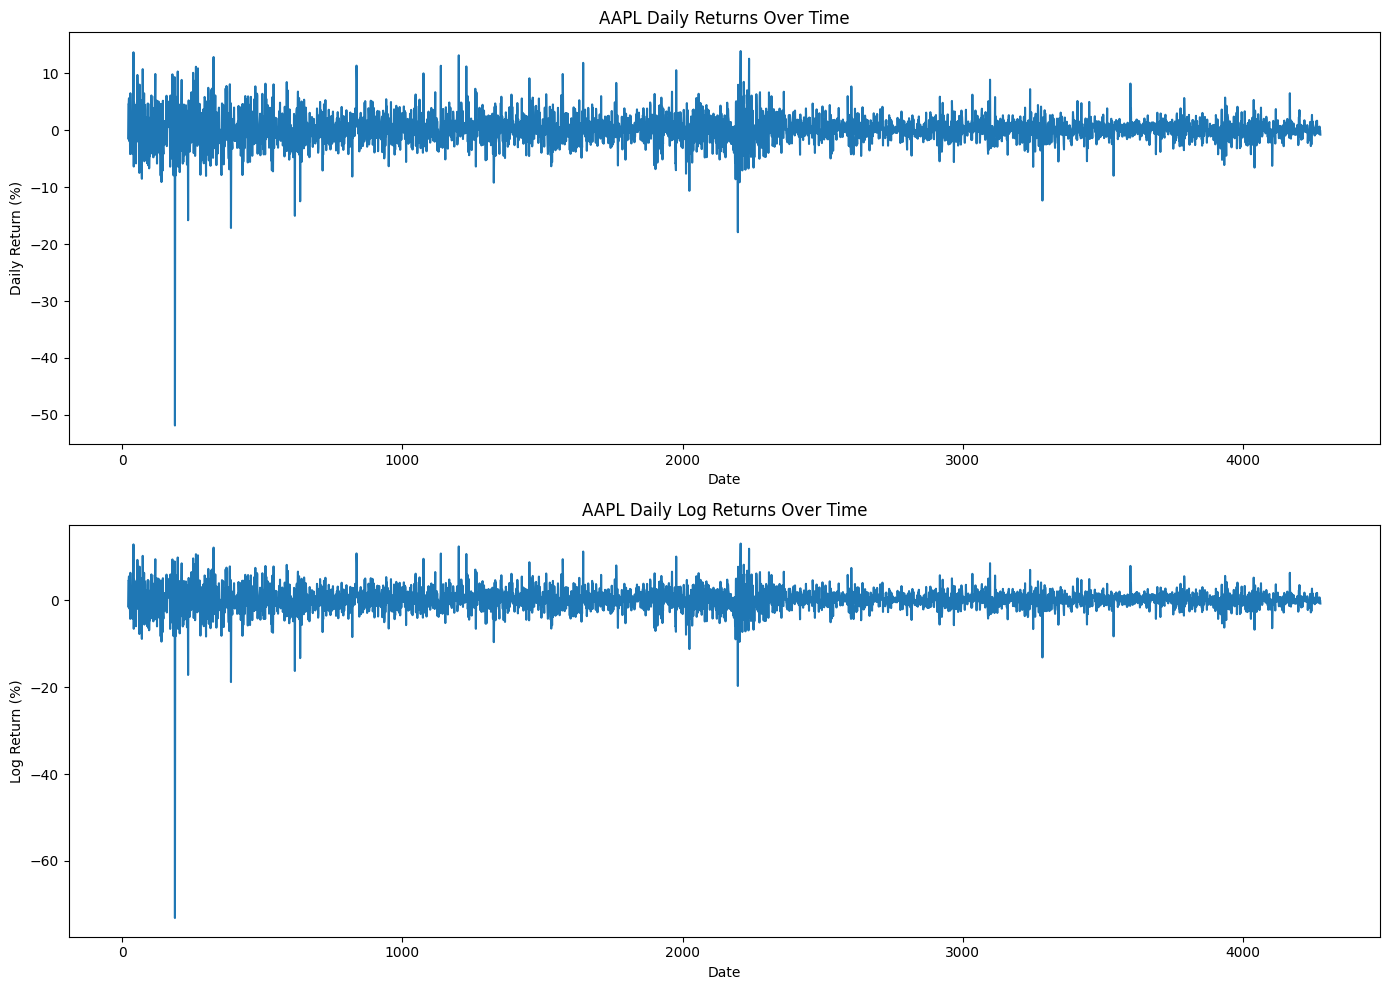

In [17]:
# Create a figure with two subplots
plt.figure(figsize=(14, 10))

# First subplot: Plot daily returns over time
plt.subplot(2, 1, 1)  # (2 rows, 1 column, first subplot)
plt.plot(df.index, df['Return'])
plt.title('AAPL Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')

# Second subplot: Plot daily log returns over time
plt.subplot(2, 1, 2)  # (2 rows, 1 column, second subplot)
plt.plot(df.index, df['LReturn'])
plt.title('AAPL Daily Log Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Log Return (%)')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


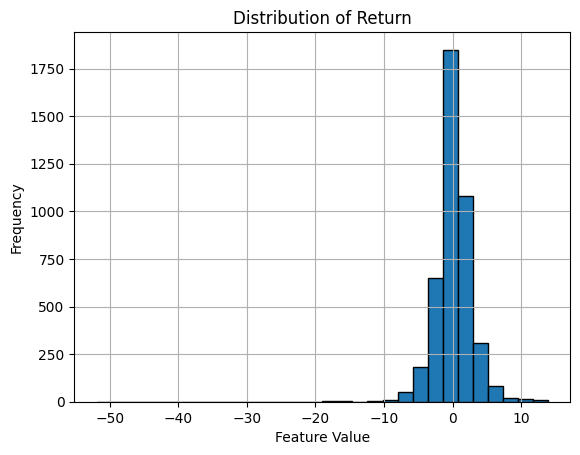

In [18]:
# Assuming `df` is your DataFrame and `feature_column` is your column of interest
df['Return'].hist(bins=30, edgecolor='black')
plt.title('Distribution of Return')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.show()

Apple's (AAPL) market value was sliced in half Friday, Sep. 29, 2000, its shares falling $27.75 to end the session 51.9 percent lower at $25.75. They were the most actively-traded on Nasdaq and were among the biggest percentage decliners as well. (lol)
 **Description of AAPL's Return Distribution:**

1. **Shape**:
   - The histogram shows a distribution that is **centered around 0**, with a high frequency of values close to 0.
   - The distribution appears to be skewed with **long tails** on both sides, suggesting the presence of outliers or extreme values in AAPL's returns.

2. **Range**:
   - The majority of returns fall within a small range (e.g., -10% to +10%), but there are extreme values extending beyond -40% and +10%.

3. **Kurtosis**:
   - The high central peak and long tails suggest that the distribution is leptokurtic (heavy-tailed compared to a normal distribution). It could be a mixture of normal.


 **Somethings to do**

**Handle Outliers**:
   - The extreme values in the tails could distort the model. Consider:
     - **Log Transformation**: I apply a logarithmic transformation to stabilize variance and add it as a feature.
     - **Trimming**: However, I'll not condiser remove extreme outliers since they are extremly valuable datapoint, just like the bankrupcy example in the midterm project.

**Check Stationarity**:
   - Since I'm predicting returns, I'll apply some time series technique as based lime model to check the series statistic preperty like **stationary** .

3. **Feature Engineering**:
   - I'll Add features like rolling averages, rolling volatility, or lagged returns to capture trends and volatility.

4. **Normalize or Standardize Returns**:
   - Normalize or standardize the return data to ensure all features in the model have similar scales, especially if combining AAPL returns with other features like ETF or stock returns.
   - Use nomalize layer

5. **Visualize Further**:
   - Plot QQ-plots to better understand the return distribution and confirm the presence of outliers or heavy tails.


In [19]:
df.iloc[df['Return'].values < -20, 0]

188    2000-09-29
Name: Dt, dtype: object

In [20]:
df

Dt  Adj Close    Close  Div  Factor      High      Low  \
21    2000-02-02     3.0706   98.813  0.0     1.0  102.1250   97.000   
22    2000-02-03     3.2104  103.313  0.0     1.0  104.2500  100.250   
23    2000-02-04     3.3561  108.000  0.0     1.0  110.0000  103.625   
24    2000-02-07     3.5445  114.063  0.0     1.0  114.2500  105.938   
25    2000-02-08     3.5697  114.875  0.0     1.0  116.1250  111.250   
...          ...        ...      ...  ...     ...       ...      ...   
4272  2016-12-23   111.3073  116.520  0.0     1.0  116.5255  115.590   
4273  2016-12-27   112.0142  117.260  0.0     1.0  117.8000  116.490   
4274  2016-12-28   111.5366  116.760  0.0     1.0  118.0170  116.200   
4275  2016-12-29   111.5079  116.730  0.0     1.0  117.1094  116.400   
4276  2016-12-30   110.6386  115.820  0.0     1.0  117.2000  115.430   

          Open       Volume    Return   LReturn  Return_rolling_mean  \
21    100.7500  116048800.0 -1.434854 -1.445247            -0.059564   
22    100.3130  118798400.0  4.552856  4.452256             0.094928   
23    103.9380  106330000.0  4.538375  4.438405             0.754578   
24    108.0038  110266800.0  5.613659  5.461752             0.798311   
25    114.0000  102160800.0  0.710961  0.708445             0.921828   
...        ...          ...       ...       ...                  ...   
4272  115.5900   14249500.0  0.197772  0.197577             0.210134   
4273  116.5200   18296900.0  0.635089  0.633080             0.251725   
4274  117.5200   20905900.0 -0.426375 -0.427286             0.235337   
4275  116.4500   15039500.0 -0.025731 -0.025735             0.276220   
4276  116.6577   30586300.0 -0.779586 -0.782641             0.283838   

      Return_rolling_std  Return_Risk_Adjusted_Return  
21              5.108380                    -0.011660  
22              5.202703                     0.018246  
23              4.860047                     0.155261  
24              4.901546                     0.162869  
25              4.864688                     0.189494  
...                  ...                          ...  
4272            0.757294                     0.277479  
4273            0.756614                     0.332699  
4274            0.768065                     0.306402  
4275            0.728358                     0.379237  
4276            0.715745                     0.396563  

[4256 rows x 14 columns]

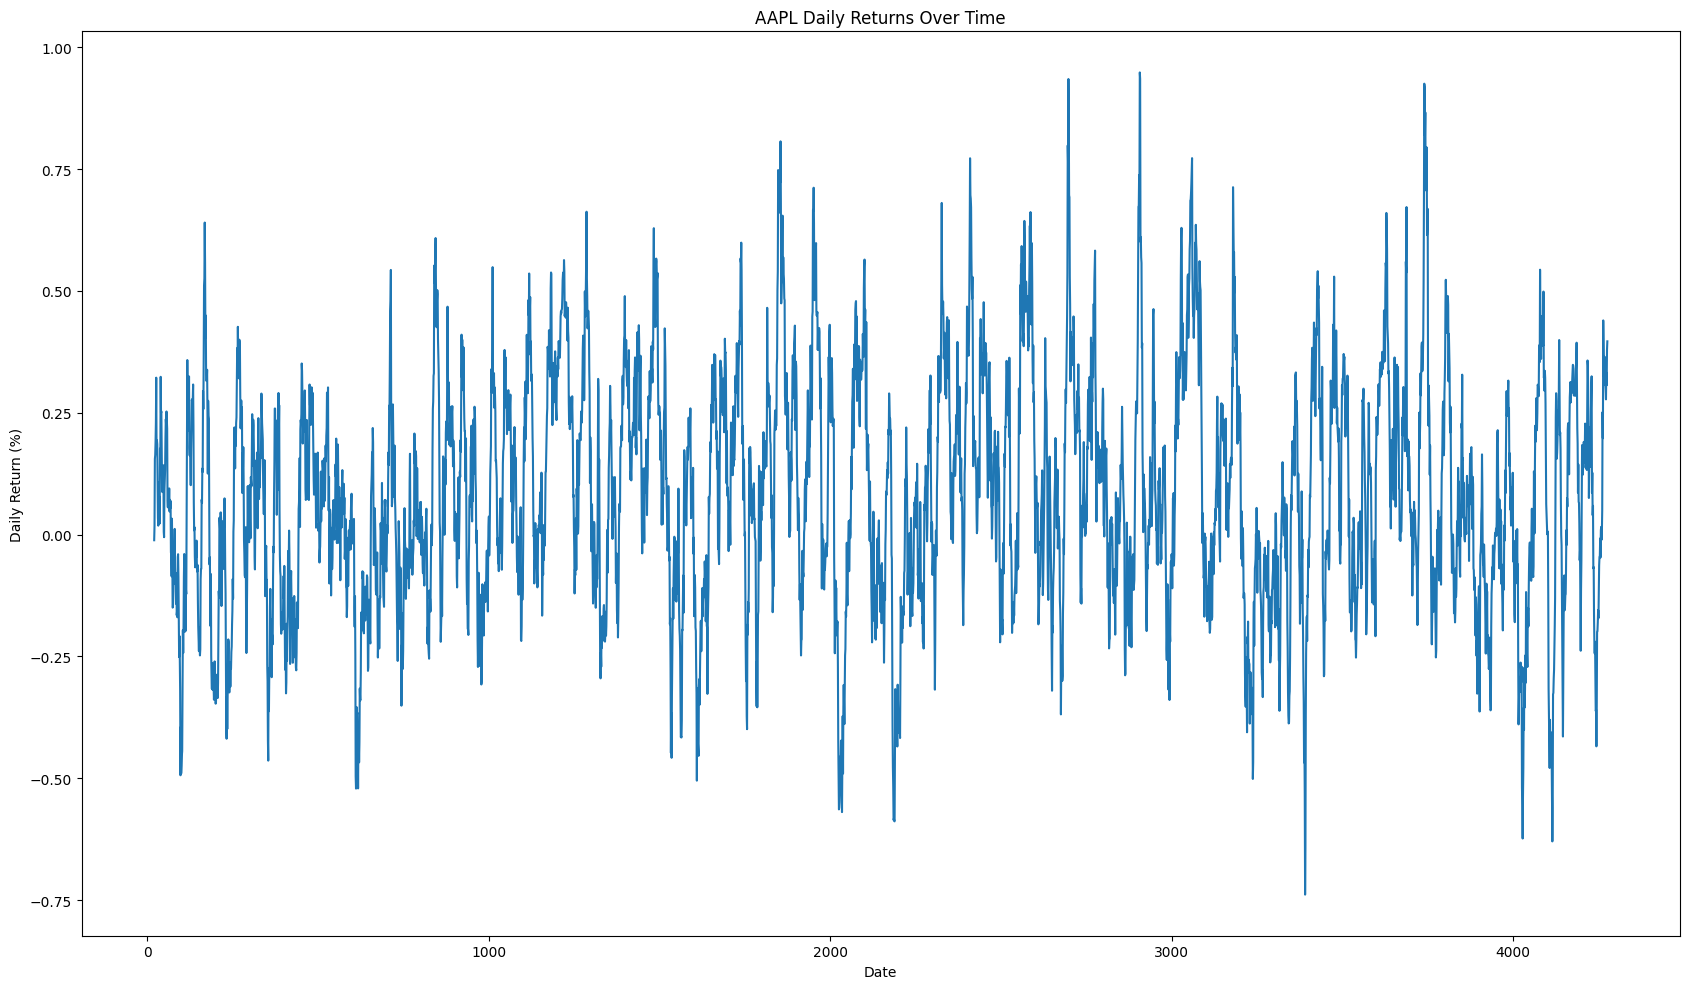

In [21]:
# Create a figure with two subplots
plt.figure(figsize=(17, 10))

# First subplot: Plot daily returns over time
plt.plot(df.index, df['Return_Risk_Adjusted_Return'])
plt.title('AAPL Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


Based on the plot, we can find that using Risk-Adjusted Return might provides a more balanced result for models predicting returns. It reduces noise, captures essential risk-reward dynamics, and it also aligns with real-world investment goals, making it a highly effective feature for financial predictive tasks.

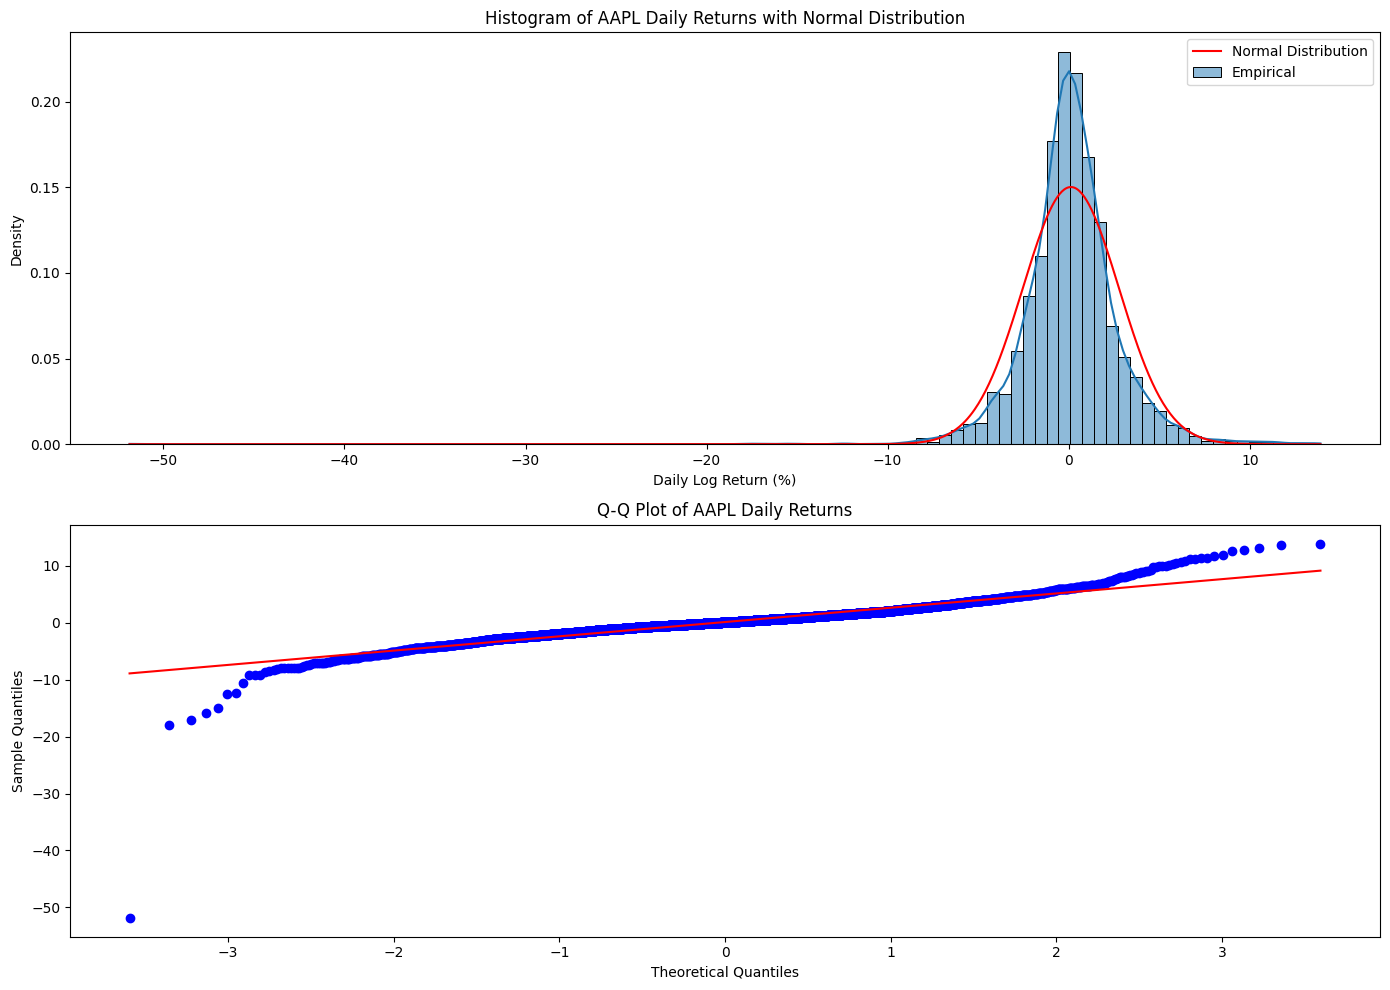

In [22]:
# Create a figure for histogram and Q-Q plot
plt.figure(figsize=(14, 10))

# Subplot 1: Histogram of daily log returns with normal distribution
plt.subplot(2, 1, 1)
sns.histplot(df['Return'], bins=100, kde=True, stat='density', label='Empirical')
mean, std = df['Return'].mean(), df['Return'].std()
x = np.linspace(df['Return'].min(), df['Return'].max(), 1000)
plt.plot(x, stats.norm.pdf(x, mean, std), label='Normal Distribution', color='red')
plt.title('Histogram of AAPL Daily Returns with Normal Distribution')
plt.xlabel('Daily Log Return (%)')
plt.ylabel('Density')
plt.legend()

# Subplot 2: Q-Q plot
plt.subplot(2, 1, 2)
stats.probplot(df['Return'], dist="norm", plot=plt)
plt.title('Q-Q Plot of AAPL Daily Returns')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

# Show the plots
plt.tight_layout()
plt.show()

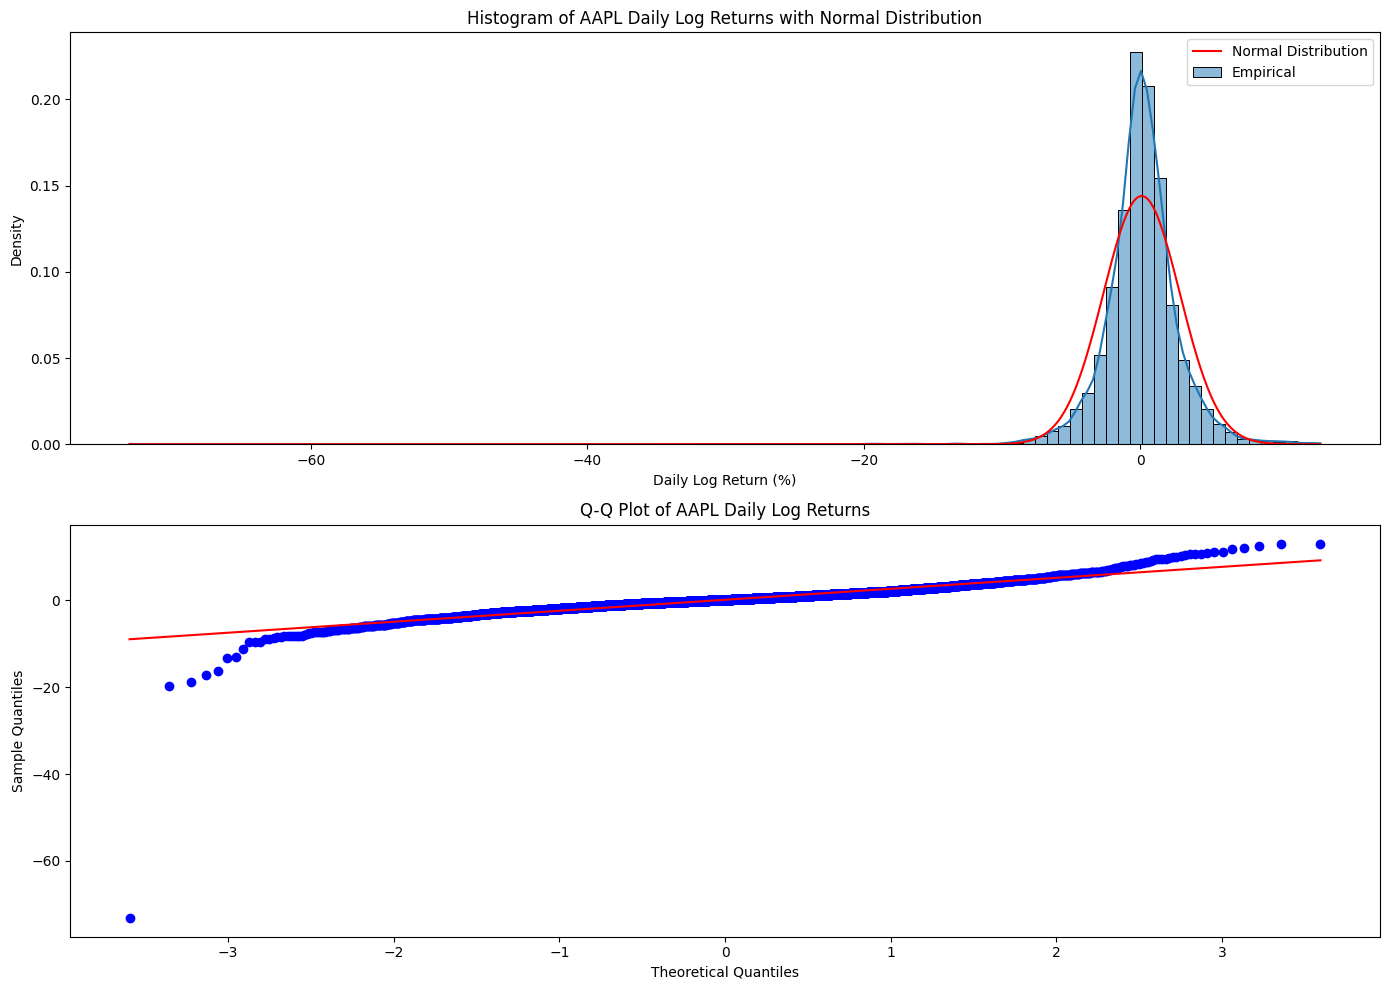

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

# Create a figure for histogram and Q-Q plot
plt.figure(figsize=(14, 10))

# Subplot 1: Histogram of daily log returns with normal distribution
plt.subplot(2, 1, 1)
sns.histplot(df['LReturn'], bins=100, kde=True, stat='density', label='Empirical')
mean, std = df['LReturn'].mean(), df['LReturn'].std()
x = np.linspace(df['LReturn'].min(), df['LReturn'].max(), 1000)
plt.plot(x, stats.norm.pdf(x, mean, std), label='Normal Distribution', color='red')
plt.title('Histogram of AAPL Daily Log Returns with Normal Distribution')
plt.xlabel('Daily Log Return (%)')
plt.ylabel('Density')
plt.legend()

# Subplot 2: Q-Q plot
plt.subplot(2, 1, 2)
stats.probplot(df['LReturn'], dist="norm", plot=plt)
plt.title('Q-Q Plot of AAPL Daily Log Returns')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

# Show the plots
plt.tight_layout()
plt.show()

### Insights
1. **Histogram Analysis**:
   - The empirical distribution has noticeable deviations from a normal distribution. Specifically:
     - The peaks of the histogram are higher and narrower than the normal curve, suggesting a leptokurtic (fat-tailed) distribution.
     - The tails extend farther compared to the normal distribution, confirming the presence of fat tails. This indicates that extreme returns occur more frequently than a normal distribution would predict.

2. **Q-Q Plot Analysis**:
   - The Q-Q plot highlights the presence of fat tails:
     - The points deviate significantly from the red line (theoretical quantiles of a normal distribution) at both ends.
     - This deviation at the extremes supports the hypothesis that the data has heavier tails than a normal distribution.
   - The curvature at the beginning and end of the plot suggests that the returns have significant skewness and kurtosis.

However, there is no significant difference between log transform and return. It seems like that both of them comse from/can be modeled by mixture of normal.


In [24]:
df_wide_filtered

Dt  AAPL_Adj Close  ACN_Adj Close  ADBE_Adj Close  CRM_Adj Close  \
3135 2012-06-19         73.0151        50.8038           32.89        34.5025   
3136 2012-06-20         72.8076        50.6000           31.99        34.4375   
3137 2012-06-21         71.8045        48.1120           31.23        33.1925   
3138 2012-06-22         72.3551        48.8763           31.57        34.2775   
3139 2012-06-25         70.9468        47.9337           30.85        33.5400   
...         ...             ...            ...             ...            ...   
4272 2016-12-23        111.3073       111.7080          105.02        69.8700   
4273 2016-12-27        112.0142       111.7746          104.98        69.8500   
4274 2016-12-28        111.5366       110.8808          103.77        69.0900   
4275 2016-12-29        111.5079       111.2611          103.68        69.1500   
4276 2016-12-30        110.6386       111.3752          102.95        68.4600   

      CSCO_Adj Close  FB_Adj Close  GOOG_Adj Close  IBM_Adj Close  \
3135         13.6452         31.91        289.6792       152.2039   
3136         13.9073         31.60        287.6767       152.0891   
3137         13.4466         31.84        281.5497       147.9651   
3138         13.6055         33.05        284.6730       148.2023   
3139         13.4546         32.06        279.3031       147.5597   
...              ...           ...             ...            ...   
4272         27.8207        117.27        789.9100       146.5132   
4273         27.9574        118.01        791.5500       146.8911   
4274         27.7205        116.92        785.0500       146.0562   
4275         27.7569        116.35        782.7900       146.4165   
4276         27.5382        115.05        771.8200       145.8804   

      INTC_Adj Close  ...  MSFT_Risk_Adjusted_Return  NVDA_rolling_mean  \
3135         21.8835  ...                   0.105973           0.408844   
3136         21.9869  ...                   0.127973           0.549184   
3137         21.2471  ...                   0.114235           0.198884   
3138         21.4301  ...                   0.171136           0.393788   
3139         20.7221  ...                   0.084889           0.116370   
...              ...  ...                        ...                ...   
4272         34.2162  ...                   0.204926           0.798864   
4273         34.3088  ...                   0.201713           1.144937   
4274         33.9015  ...                   0.144594           0.846694   
4275         33.9293  ...                   0.210641           1.002766   
4276         33.5684  ...                   0.248695           1.039605   

      NVDA_rolling_std  NVDA_Risk_Adjusted_Return  SPY_rolling_mean  \
3135          2.758263                   0.148225          0.170925   
3136          2.742330                   0.200262          0.154105   
3137          2.925243                   0.067989          0.039264   
3138          2.854263                   0.137965          0.067941   
3139          2.918432                   0.039874          0.003991   
...                ...                        ...               ...   
4272          2.452366                   0.325752          0.124253   
4273          2.790815                   0.410252          0.160132   
4274          3.295487                   0.256925          0.109056   
4275          3.270963                   0.306566          0.119939   
4276          3.203906                   0.324481          0.120041   

      SPY_rolling_std  SPY_Risk_Adjusted_Return  V_rolling_mean  \
3135         1.083258                  0.157788        0.226173   
3136         1.085811                  0.141926        0.183890   
3137         1.211286                  0.032415        0.024103   
3138         1.221949                  0.055601        0.227834   
3139         1.275845                  0.003128        0.097289   
...               ...                       ...        

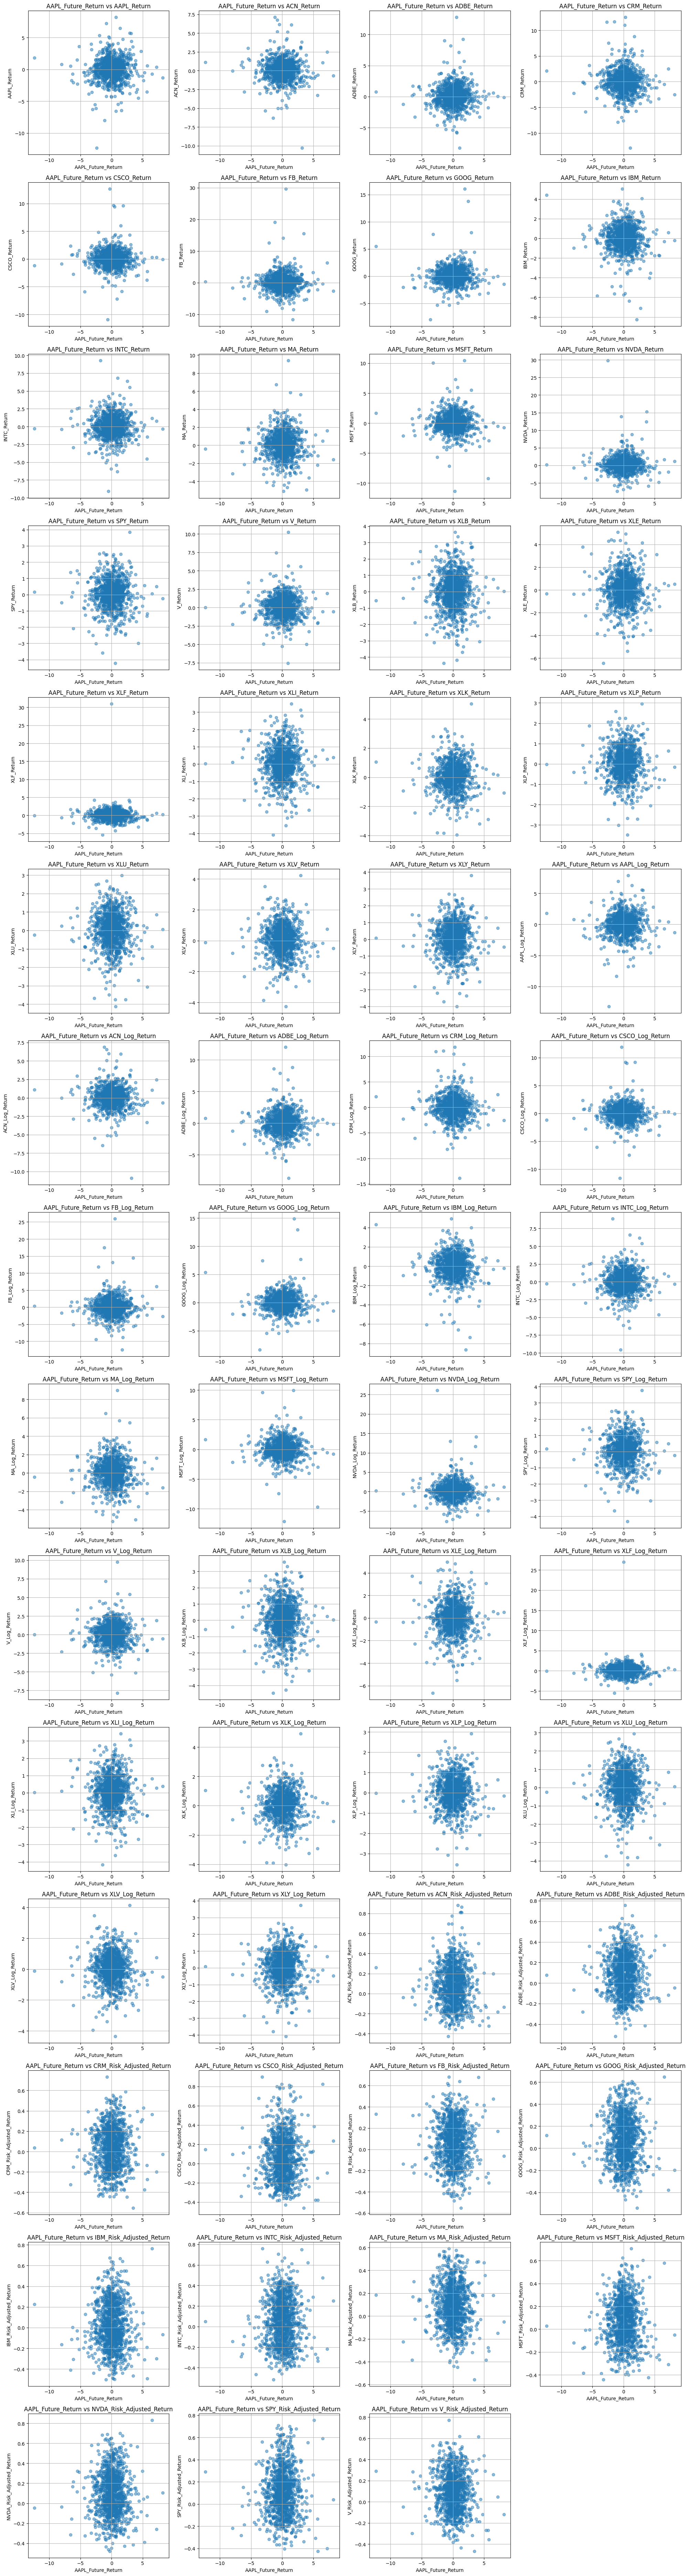

In [25]:
df_wide_filtered['AAPL_Future_Return'] = df_wide_filtered['AAPL_Return'].shift(-1)
df_wide_filtered.dropna(subset=['AAPL_Future_Return'])
# Define relevant columns for visualization
aapl_return_col = 'AAPL_Future_Return'
relevant_columns = [col for col in df_wide_filtered.columns if col != aapl_return_col and '_Return' in col]

# Create subplots for all relationships in one figure
n_cols = 4  # Number of columns for subplots
n_rows = (len(relevant_columns) + n_cols - 1) // n_cols  # Calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()  # Flatten the grid for easy indexing

for i, col in enumerate(relevant_columns):
    axes[i].scatter(df_wide_filtered[aapl_return_col], df_wide_filtered[col], alpha=0.5)
    axes[i].set_title(f'{aapl_return_col} vs {col}')
    axes[i].set_xlabel(aapl_return_col)
    axes[i].set_ylabel(col)
    axes[i].grid(True)

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


Based on the scatter plots in the image

1. **Central Cluster**: Most points are clustered around the origin (0, 0), indicating that returns for both AAPL's future returns and the compared factor returns are generally small and centered around 0%.

2. **Weak Relationships**: There doesn't appear to be any strong linear relationship between AAPL's future return and the other factor returns. The scatter plots are mostly symmetric and circular, suggesting little to no correlation.

3. **Outliers**: In some plots, a few outliers can be observed where returns for certain stocks or AAPL deviate significantly from the average. These might correspond to rare market events or high volatility periods.

4. **Distribution Symmetry**: The scatter points seem symmetric about the x-axis and y-axis, suggesting a lack of directional bias between AAPL's future return and the other stock returns.

In summary, the visualizations suggest weak or no direct relationship between AAPL's future returns and other stock returns, though a deeper statistical analysis (e.g., correlation coefficients) could confirm this.


### Some possible thought for Data Preprocessing and Feature Engineering

#### 1. **Data Preprocessing**:
   - **Scaling**:
     - Normalize or standardize the data to ensure features are on the same scale, especially for machine learning algorithms that are sensitive to scales.

#### 2. **Feature Engineering**:
   - **Volatility Clustering**:
     - Identify periods of high and low volatility and create features that capture this behavior, as financial returns often exhibit volatility clustering.
   - **Tail Indicators**: (done when calculating risk-adjusted return)
     - Create features that specifically measure tail risk, such as volatility or Conditional Value at Risk (CVaR).
   - **Lag Features**:
     - Include lagged returns as features to capture autocorrelation in returns.
   - **Moving Averages**: (done when calculating risk-adjusted return)
     - Compute moving averages or rolling statistics (e.g., mean, standard deviation) to incorporate temporal patterns.



# Feature Engineering

### Lag Features

Include lagged returns or prices to capture temporal dependencies:

- **Lagged Returns:** Returns from the previous 1 to 20 days.
- **Lagged Prices:** Adjusted Close prices from the previous 1 to 20 days.

In [26]:
# def create_lag_features(df, lag_days=20):
#     """
#     Create lag features for the given number of days.

#     Parameters:
#         df (DataFrame): Stock data with 'Return' column.
#         lag_days (int): Number of lag days to create features for.

#     Returns:
#         df (DataFrame): DataFrame with lag features.
#     """
#     for lag in range(1, lag_days + 1):
#         df[f'Return_Lag_{lag}'] = df['Return'].shift(lag)
#     df.dropna(inplace=True)
#     return df



In [27]:
def create_lag_features(df, lag_days=20):
    """
    Create lag features for all return columns in the DataFrame in an optimized way.

    Parameters:
        df (DataFrame): Stock data with multiple 'Return' columns.
        lag_days (int): Number of lag days to create features for.

    Returns:
        df (DataFrame): DataFrame with lag features for each return column.
    """
    # Identify all columns that contain 'Return' (excluding 'Future_Return' if present)
    return_cols = [col for col in df.columns if '_Return' in col and 'Future' not in col]
    
    lagged_features = []  # To store the lagged features
    
    for lag in range(1, lag_days + 1):
        lagged_df = df[return_cols].shift(lag).add_suffix(f'_Lag_{lag}')
        lagged_features.append(lagged_df)

    # Concatenate the original DataFrame with all lagged features
    df = pd.concat([df] + lagged_features, axis=1)
    
    # Drop rows with NaN values caused by the lagged features
    df.dropna(inplace=True)
    
    return df

# Apply the function to df_wide_filtered
df = create_lag_features(df)
df_wide_filtered_fe = create_lag_features(df_wide_filtered, lag_days=20)
df_wide_filtered_fe_holdout = create_lag_features(df_wide2, lag_days=20)


### Technical Indicators

Compute technical indicators that may help predict future returns:

- **Moving Averages (MA):** Simple and Exponential MAs over different windows (e.g., 5, 10, 20 days).
- **Relative Strength Index (RSI):** Measures the speed and change of price movements.
- **Moving Average Convergence Divergence (MACD):** Captures momentum.

In [28]:
def add_technical_indicators(df):
    """
    Add technical indicators to the DataFrame.

    Parameters:
        df (DataFrame): Stock data with lag features.

    Returns:
        df (DataFrame): DataFrame with technical indicators.
    """
    # Moving Averages
    df['MA_5'] = df['Adj Close'].rolling(window=5).mean()
    df['MA_10'] = df['Adj Close'].rolling(window=10).mean()
    df['MA_20'] = df['Adj Close'].rolling(window=20).mean()

    # Relative Strength Index (RSI)
    delta = df['Adj Close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ema_up = up.ewm(com=13, adjust=False).mean()
    ema_down = down.ewm(com=13, adjust=False).mean()
    rs = ema_up / ema_down
    df['RSI'] = 100 - (100 / (1 + rs))

    # Moving Average Convergence Divergence (MACD)
    exp1 = df['Adj Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Adj Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2

    df.dropna(inplace=True)
    return df

df = add_technical_indicators(df)


In [29]:
def add_technical_indicators(df):
    """
    Add technical indicators for all stocks to the DataFrame in an optimized way.

    Parameters:
        df (DataFrame): Stock data with multiple 'Adj Close' columns.

    Returns:
        df (DataFrame): DataFrame with technical indicators added for each stock.
    """
    # Identify all columns with 'Adj Close'
    adj_close_cols = [col for col in df.columns if '_Adj Close' in col]

    # List to store DataFrames with technical indicators
    indicator_dfs = []

    for col in adj_close_cols:
        stock_name = col.split('_')[0]  # Extract stock name, e.g., "AAPL"

        # Create a DataFrame to store indicators for this stock
        indicators = pd.DataFrame(index=df.index)

        # Moving Averages
        indicators[f'{stock_name}_MA_5'] = df[col].rolling(window=5).mean()
        indicators[f'{stock_name}_MA_10'] = df[col].rolling(window=10).mean()
        indicators[f'{stock_name}_MA_20'] = df[col].rolling(window=20).mean()

        # Relative Strength Index (RSI)
        delta = df[col].diff()
        up = delta.clip(lower=0)
        down = -1 * delta.clip(upper=0)
        ema_up = up.ewm(com=13, adjust=False).mean()
        ema_down = down.ewm(com=13, adjust=False).mean()
        rs = ema_up / ema_down
        indicators[f'{stock_name}_RSI'] = 100 - (100 / (1 + rs))

        # Moving Average Convergence Divergence (MACD)
        exp1 = df[col].ewm(span=12, adjust=False).mean()
        exp2 = df[col].ewm(span=26, adjust=False).mean()
        indicators[f'{stock_name}_MACD'] = exp1 - exp2

        # Append to the list
        indicator_dfs.append(indicators)

    # Concatenate all indicator DataFrames with the original DataFrame
    all_indicators = pd.concat(indicator_dfs, axis=1)
    df = pd.concat([df, all_indicators], axis=1)

    # Drop rows with NaN values caused by rolling calculations
    df.dropna(inplace=True)

    return df

# Apply the function to df_wide_filtered
df_wide_filtered_fe = add_technical_indicators(df_wide_filtered_fe)
df_wide_filtered_fe_holdout = create_lag_features(df_wide_filtered_fe_holdout, lag_days=20)

# Display the first few rows to verify
print(df_wide_filtered_fe.head())

             Dt  AAPL_Adj Close  ACN_Adj Close  ADBE_Adj Close  CRM_Adj Close  \
3174 2012-08-14         78.8563        52.0181           32.11        35.6400   
3175 2012-08-15         78.7489        51.6444           32.91        36.0325   
3176 2012-08-16         79.4368        51.9246           33.65        36.7400   
3177 2012-08-17         80.9060        51.8652           33.80        36.8075   
3178 2012-08-20         83.0332        51.6190           33.92        36.8925   

      CSCO_Adj Close  FB_Adj Close  GOOG_Adj Close  IBM_Adj Close  \
3174         13.7011         20.38        333.0815       152.3620   
3175         13.8447         21.20        332.5236       152.4464   
3176         15.1773         19.87        335.1787       154.3214   
3177         15.2092         19.05        337.3057       154.6133   
3178         15.1135         20.01        336.5087       154.0601   

      INTC_Adj Close  ...  XLV_MA_5  XLV_MA_10  XLV_MA_20    XLV_RSI  \
3174         21.2487  ... 

## Train-Test Split

- **Training Set:** Use the historical data excluding the last portion reserved for validation.
- **Validation Set:** Mimic the holdout period by reserving the last 200 days of the training data.

In [30]:
# Shift the target variable by -200 days to predict 200 days into the future
df['Future_Return'] = df['Return'].shift(-200)

# Drop rows with NaN values that result from the shift
df = df.dropna(subset=['Future_Return'])

In [31]:
df[['Dt', 'Return', 'Future_Return']].head(205)

Dt     Return  Future_Return
60   2000-03-29  -2.289917      -4.514168
61   2000-03-30  -7.494733      -0.365100
62   2000-03-31   8.002150      -1.822794
63   2000-04-03  -1.841058      11.149392
64   2000-04-04  -4.501895       4.348200
..          ...        ...            ...
260  2001-01-12  -4.514168      -0.112515
261  2001-01-16  -0.365100       2.694740
262  2001-01-17  -1.822794       2.624030
263  2001-01-18  11.149392       0.098660
264  2001-01-19   4.348200      -4.492813

[205 rows x 3 columns]

# Model Development

## Baseline Model

Start with a simple model to set a performance benchmark.
Since stock returns are often non-stationary, meaning the statistical properties (mean, variance, etc.) may change over time due to events like market crashes, regime changes, or macroeconomic shifts, I'll try to use time series decomposition.

### **Linear Regression:** Using ARMA

In [32]:
data = df[['Dt', 'Return', 'Adj Close']]
data['Dt'] = pd.to_datetime(df['Dt'])
data.set_index('Dt', inplace=True)

C:\Users\Joshua\AppData\Local\Temp\ipykernel_30116\252220321.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Dt'] = pd.to_datetime(df['Dt'])


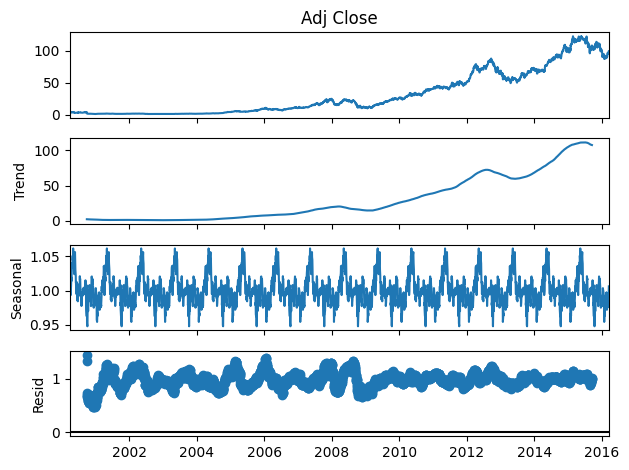

In [33]:
# Decompose the time series
result = seasonal_decompose(data['Adj Close'], model='multiplicative', period=252)  # 252 trading days/year

# Extract components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot the decomposition
result.plot()
plt.show()   

**Interpretation of the Plot:**

This plot represents the **decomposition of AAPL stock price (Adj Close)** into four components using a multiplicative model:

1. **Observed (Adj Close)**:
   - The raw stock price data shows a significant upward trend over time, with increasing volatility during certain periods.

2. **Trend**:
   - The trend component captures the long-term direction of the stock price. There is a steady upward movement with some periods of flattening or slower growth (e.g., around 2008–2010, coinciding with the global financial crisis).

3. **Seasonal**:
   - The seasonal component reflects periodic fluctuations, likely capturing short-term patterns (e.g., annual cycles in stock price changes). These variations seem relatively small compared to the trend.

4. **Residual (Noise)**:
   - The residual component captures the remaining variability after removing the trend and seasonal effects. This includes unpredictable noise and short-term fluctuations.

---

 Some general idea about what to do next

To predict stock returns using time series models or deep learning, consider the following steps:

 1. **Preprocessing**:
   - **De-trend the data**: Remove the trend component to focus on stationary data, as many time series models assume stationarity.
   - **De-seasonalize the data**: Remove the seasonal component if it is not significant for return prediction.
   - Use the **residual** component or the returns directly (log differences or percentage changes).

 2. **Stationarity Check**:
   - Check for stationarity using tests like the Augmented Dickey-Fuller (ADF) test. If the data is non-stationary, apply transformations (e.g., differencing or log-transformation).

 3. **Feature Engineering**:
   - Use lagged returns, moving averages, and volatility as features.
   - Incorporate external factors (e.g., macroeconomic indicators, news sentiment) that could influence stock prices.

 4. **Modeling**:
   - **Time Series Models**:
     - Use ARIMA or SARIMA for simpler models that account for residual components and seasonality.
     - Consider GARCH models if volatility is a focus.
   - **Deep Learning Models**:
     - Implement RNNs, LSTMs, or GRUs to capture sequential dependencies in stock returns.
     - Use hybrid models combining CNNs for feature extraction and LSTMs for sequence prediction.
     - Train on residual or de-trended, de-seasonalized data to focus on meaningful patterns.

 5. **Evaluation**:
   - Use metrics like Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), or Mean Absolute Percentage Error (MAPE) to evaluate predictions.
   - Backtest on historical data to assess performance.

By focusing on the residual or return series and leveraging advanced models like deep learning, you can enhance the predictive power for stock returns.

In [34]:
# Split into training and holdout data
train = data.loc[:'2015-12-31']
holdout = data.loc['2016-01-01':]

# Fit ARMA model on the training data
model = ARIMA(train['Return'], order=(2, 0, 2))  # Adjust the order as needed
arma_result = model.fit()

# Forecast the returns for the holdout period
forecasted_values = arma_result.forecast(steps=len(holdout))


c:\Users\Joshua\anaconda3\envs\tensorflow_gpu_2.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Joshua\anaconda3\envs\tensorflow_gpu_2.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Joshua\anaconda3\envs\tensorflow_gpu_2.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Joshua\anaconda3\envs\tensorflow_gpu_2.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Predicti

In [35]:
# Reset index to ensure alignment
holdout = holdout.reset_index()

# Assign forecasted values
holdout['Predicted_Return'] = forecasted_values.values

# Restore the datetime index
holdout.set_index('Dt', inplace=True)

# Evaluate the model
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(holdout['Return'], holdout['Predicted_Return'])
mae = mean_absolute_error(holdout['Return'], holdout['Predicted_Return'])
sharpe_ratio = np.mean(holdout['Predicted_Return'] - 0) / np.std(holdout['Predicted_Return'] - 0)

print("MSE:", mse)
print("MAE:", mae)
print("Sharpe Ratio:", sharpe_ratio)

MSE: 3.983855181963672
MAE: 1.4456355676872203
Sharpe Ratio: 3.459789735818044


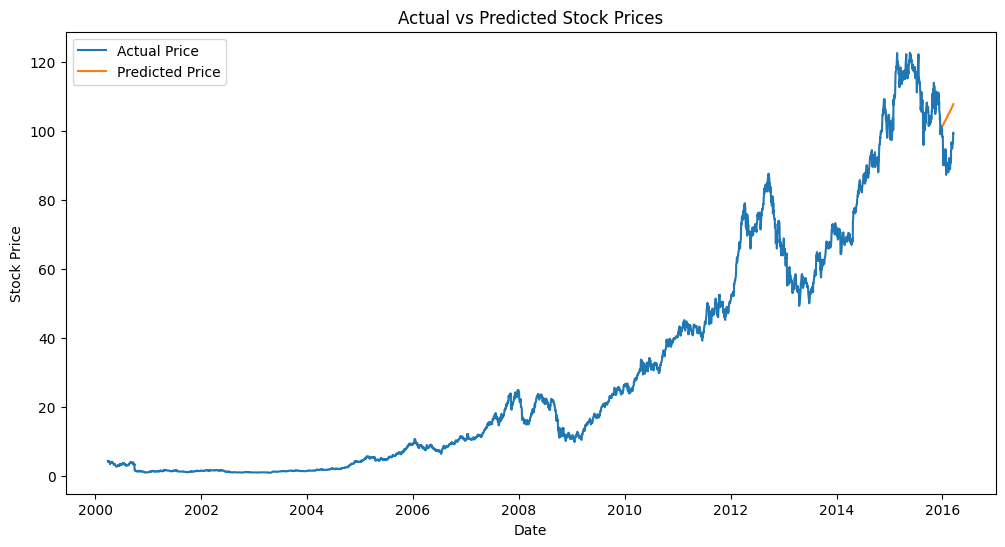

In [36]:
# Plotting the prediction with the real stock price
initial_price = train['Adj Close'].iloc[-1]


# Reconstruct actual and predicted price series
actual_prices = data['Adj Close'].loc['2000-01-01':'2016-12-30']
dates = actual_prices.index[:]

predicted_prices = (1 + holdout['Predicted_Return']/100).cumprod() * data['Adj Close'].loc['2014-12-31']
dates_p = predicted_prices.index[:]

# Plot the actual and predicted prices
plt.figure(figsize=(12, 6))
plt.plot(dates, actual_prices, label='Actual Price')
plt.plot(dates_p, predicted_prices, label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

from the plot above, it is clear that the raw stock price is not suitable for time series directly due to non-stationarity.

### **Advanced time series model:** ARIME with Garch

In [37]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model on the returns
arima_model = ARIMA(train['Return'], order=(2, 0, 2))  # Adjust (p, d, q) as needed
arima_result = arima_model.fit()

# Check ARIMA residuals
arima_residuals = arima_result.resid

c:\Users\Joshua\anaconda3\envs\tensorflow_gpu_2.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Joshua\anaconda3\envs\tensorflow_gpu_2.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Joshua\anaconda3\envs\tensorflow_gpu_2.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [38]:
# Fit GARCH model on ARIMA residuals
garch_model = arch_model(arima_residuals, vol='Garch', p=1, q=1, dist='t')  
garch_result = garch_model.fit(disp='off')

# Summary of the GARCH model
print(garch_result.summary())


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -8789.14
Distribution:      Standardized Student's t   AIC:                           17588.3
Method:                  Maximum Likelihood   BIC:                           17619.7
                                              No. Observations:                 3965
Date:                      Fri, Dec 06 2024   Df Residuals:                     3964
Time:                              16:58:12   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

In [39]:


# Define the log-likelihood for a mixture of normals
def mixture_normal_log_likelihood(params, residuals):
    # Extract parameters
    pi = params[0]  # Mixing proportion
    mu1, sigma1 = params[1], params[2]  # Mean and std for component 1
    mu2, sigma2 = params[3], params[4]  # Mean and std for component 2
    
    # Ensure proportions are valid
    pi = max(0, min(1, pi))  # Ensure 0 <= pi <= 1

    # Compute likelihood for each component
    pdf1 = norm.pdf(residuals, loc=mu1, scale=sigma1)
    pdf2 = norm.pdf(residuals, loc=mu2, scale=sigma2)

    # Mixture likelihood
    mixture_pdf = pi * pdf1 + (1 - pi) * pdf2

    # Log-likelihood
    log_likelihood = np.sum(np.log(mixture_pdf))

    return -log_likelihood  # Minimize negative log-likelihood

# Example residuals (replace with GARCH residuals)
residuals = np.random.randn(1000)

# Initial parameter guesses
initial_params = [0.5, 0, 1, 0, 2]  # [pi, mu1, sigma1, mu2, sigma2]

# Optimize the parameters
result = minimize(mixture_normal_log_likelihood, initial_params, args=(residuals,))
print("Optimized Parameters:", result.x)

Optimized Parameters: [1.01834263 0.04314188 0.98405076 0.66492053 1.96260636]


In [40]:
# import pymc3 as pm

# with pm.Model() as model:
#     # Priors for mixture weights
#     w = pm.Dirichlet('w', a=np.array([1, 1]))

#     # Priors for means and standard deviations of two components
#     mu = pm.Normal('mu', mu=0, sigma=10, shape=2)
#     sigma = pm.HalfNormal('sigma', sigma=1, shape=2)

#     # Mixture model for residuals
#     component = pm.Normal.dist(mu=mu, sigma=sigma, shape=(2,))
#     y_obs = pm.Mixture('y_obs', w=w, comp_dists=component, observed=residuals)

#     trace = pm.sample()


In [41]:
# Forecast returns (mean) from ARIMA
arima_forecast = arima_result.forecast(steps=len(holdout))

# Forecast volatility from GARCH
garch_forecast = garch_result.forecast(horizon=len(holdout))

# Extract conditional volatility (standard deviation)
garch_volatility = garch_forecast.variance.values[-1]**0.5

# Combine mean and volatility forecasts
forecasted_returns = arima_forecast 
forecasted_volatility = garch_volatility


#simulated_returns = forecasted_returns + np.random.normal(0, forecasted_volatility, size=len(forecasted_returns))

c:\Users\Joshua\anaconda3\envs\tensorflow_gpu_2.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Joshua\anaconda3\envs\tensorflow_gpu_2.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [42]:
num_simulations = 100  # Number of simulations
simulated_paths = []

for _ in range(num_simulations):
    # Simulate one path of returns
    simulated_path = forecasted_returns + np.random.normal(0, forecasted_volatility, size=len(forecasted_returns))
    simulated_paths.append(simulated_path)
    
# Convert the list of simulated paths to a NumPy array
simulated_paths = np.array(simulated_paths)

# Average across simulations
average_simulated_returns = simulated_paths.mean(axis=0)

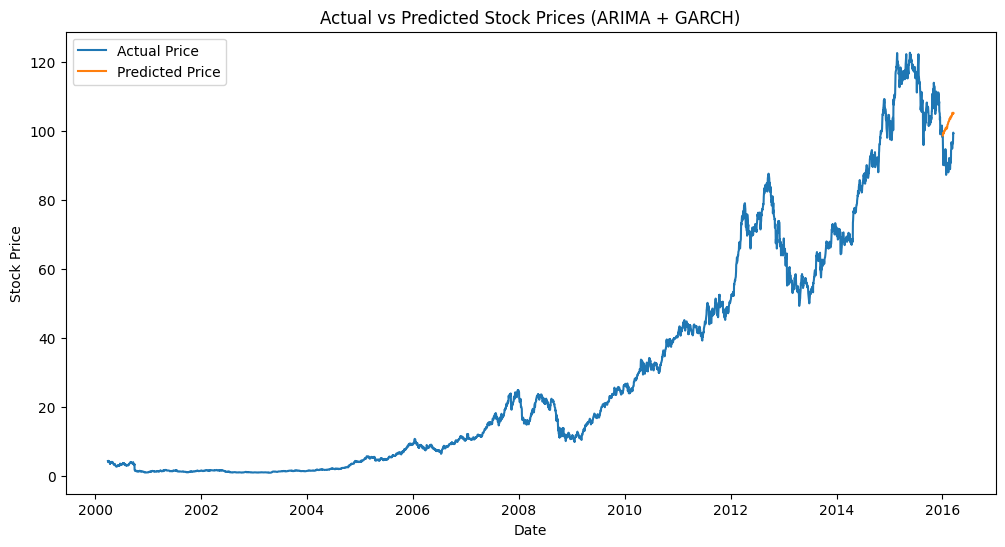

In [43]:
# Reconstruct predicted price series from returns
predicted_prices = (1 + average_simulated_returns / 100).cumprod() * train['Adj Close'].iloc[-1]

predicted_prices = pd.Series(predicted_prices.tolist(), index=holdout.index)

# Plot the actual and predicted prices
plt.figure(figsize=(12, 6))
plt.plot(actual_prices.index, actual_prices, label='Actual Price')
plt.plot(predicted_prices.index, predicted_prices, label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices (ARIMA + GARCH)')
plt.legend()
plt.show()

In [44]:

# Compute MSE
mse = mean_squared_error(holdout['Return'], average_simulated_returns)
print(f"MSE (Out-of-Sample): {mse:.4f}")

# Compute MAE
mae = mean_absolute_error(holdout['Return'], average_simulated_returns)
print(f"MAE (Out-of-Sample): {mae:.4f}")

MSE (Out-of-Sample): 4.1152
MAE (Out-of-Sample): 1.5004


 Interpretation of the Result:

1. **Overview**:
   - The blue line represents the **actual stock prices**, while the orange line represents the **predicted prices** using the ARIMA + GARCH model.
   - The model captures some broad movements in stock prices, such as overall direction and certain volatility patterns.

2. **Strengths**:
   - The model performs reasonably well in replicating volatility clustering and short-term price fluctuations in the predicted period.
   - It adjusts predictions dynamically, reflecting time-varying volatility captured by the GARCH model.

3. **Weaknesses**:
   - There is a noticeable divergence between the actual and predicted prices, particularly in capturing long-term trends.
   - The predicted prices appear to deviate in scale (either underestimating or overestimating) the actual price levels.



 Some interesting idea
1. **Addressing Divergence**:
   - If long-term trends are poorly captured, consider incorporating external factors (e.g., macroeconomic variables) or improving the ARIMA component by fine-tuning parameters.
2. **Refining the Volatility Model**:
   - Experiment with different GARCH variations (e.g., EGARCH or TGARCH) for better volatility modeling.
3. **Hybrid Approaches**:
   - Combine ARIMA-GARCH with machine learning techniques like LSTM for potentially better accuracy in capturing nonlinear trends and volatility.

### **Simple RNN** 

In [45]:
data = df[['Dt', 'Return', 'Adj Close']].copy()
data['Dt'] = pd.to_datetime(data['Dt'])
data.set_index('Dt', inplace=True)
data['tomorrow_return'] = data['Return'].shift(-1)
data.dropna(inplace=True)

X = data.drop(columns=['tomorrow_return'])
y = data['tomorrow_return']

X_train, X_test = X.iloc[:-200], X.iloc[-200:]
y_train, y_test = y.iloc[:-200], y.iloc[-200:]

In [46]:
SimpleRNN = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=False, input_shape=[None, 1]),
    keras.layers.Dense(1)
])
SimpleRNN.compile(loss='mean_squared_error', optimizer='adam')
history = SimpleRNN.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), verbose=0)

7/7 [==============================] - 0s 873us/step
MSE: 3.375697261243778
MAE: 1.3579169388199603
Sharpe Ratio: 561.8998


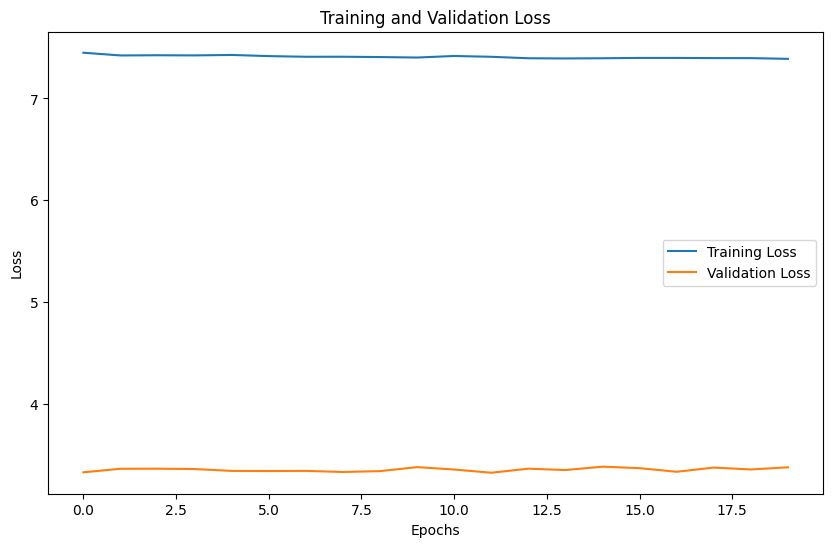

In [47]:
holdout_preds = SimpleRNN.predict(X_test)

mse = mean_squared_error(holdout_preds, y_test)
mae = mean_absolute_error(holdout_preds, y_test)
sharpe_ratio = np.mean(holdout_preds - 0) / np.std(holdout_preds - 0)

print("MSE:", mse)
print("MAE:", mae)
print("Sharpe Ratio:", sharpe_ratio)

#define the function to plot the training and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
# Plot the training and validation loss
plot_loss(history)



The flat and somewhat counterintuitive loss curves likely indicate that the chosen features and model architecture do not provide enough predictive power.

In [48]:
# Prepare data for RNN
lookback = 20  # Use past 20 days of returns
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[['Return']])
holdout_scaled = scaler.transform(holdout[['Return']])

def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Concatenate the last 'lookback' data points from train and holdout data
extended_data = np.concatenate([train_scaled[-lookback:], holdout_scaled], axis=0)

# Create sequences from the extended data
X_extended, y_extended = create_sequences(extended_data, lookback)

# Since we added 'lookback' data points, the sequences corresponding to the holdout set are at the end
num_holdout_sequences = len(holdout_scaled)
X_holdout_sequences = X_extended[-num_holdout_sequences:]
y_holdout_sequences = y_extended[-num_holdout_sequences:]

# Define RNN model
modelSimpleRNN = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(50, activation='relu', input_shape=(lookback, 1)),
    tf.keras.layers.Dense(1)
])
modelSimpleRNN.compile(optimizer='adam', loss='mse')

# Create training sequences
X_train, y_train = create_sequences(train_scaled, lookback)

# Train RNN
history = modelSimpleRNN.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

# Predict on holdout sequences
holdout_preds = modelSimpleRNN.predict(X_holdout_sequences)

# Inverse transform the predictions
holdout['Predicted_Return'] = np.nan
holdout['Predicted_Return'] = scaler.inverse_transform(holdout_preds).flatten()

# Evaluate the model
mse_rnn = mean_squared_error(
    holdout['Return'],  # True values
    holdout['Predicted_Return']  # Predicted values
)
print(f"RNN Model MSE: {mse_rnn}")


2/2 [==============================] - 0s 3ms/step
RNN Model MSE: 4.181337898542427


In [49]:
# Display the model structure
modelSimpleRNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


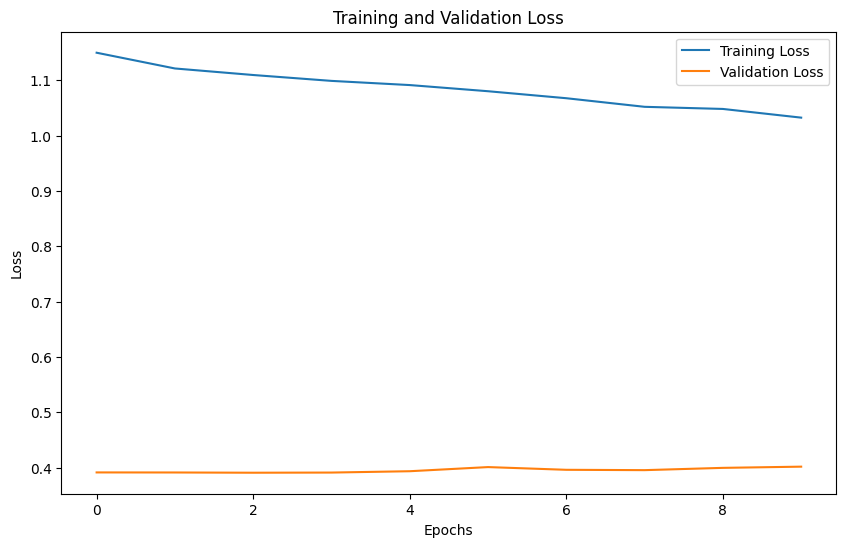

In [50]:
#define the function to plot the training and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
# Plot the training and validation loss
plot_loss(history)


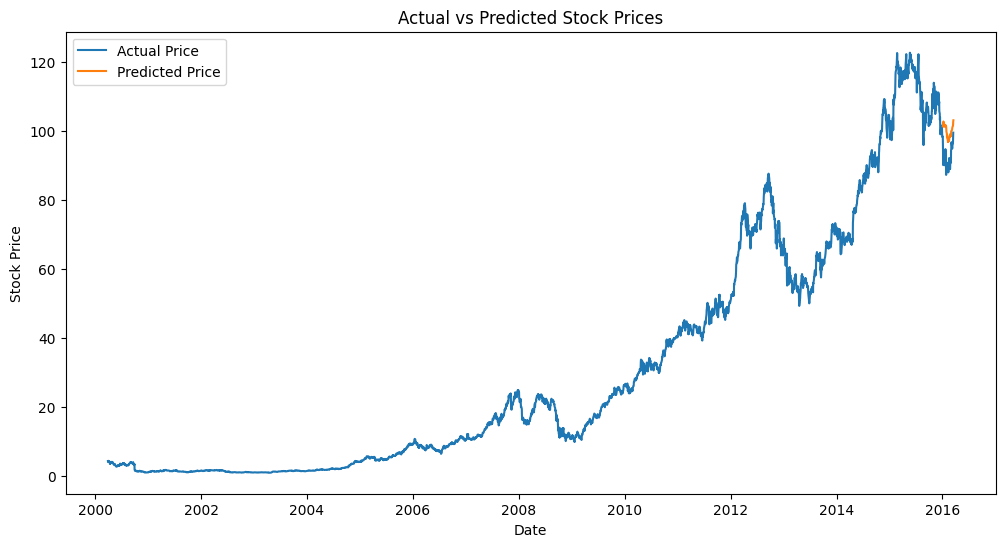

In [51]:
# Plotting the prediction with the real stock price
initial_price = train['Adj Close'].iloc[-1]


# Reconstruct actual and predicted price series
actual_prices = data['Adj Close'].loc['2000-01-01':'2016-12-30']
dates = actual_prices.index[:]

predicted_prices = (1 + holdout['Predicted_Return']/100).cumprod() * data['Adj Close'].loc['2014-12-31']
dates_p = predicted_prices.index[:]

# Plot the actual and predicted prices
plt.figure(figsize=(12, 6))
plt.plot(dates, actual_prices, label='Actual Price')
plt.plot(dates_p, predicted_prices, label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

# Neural Network Model

## Model1 description
### Model Architecture

- **Input Layer:** Number of neurons equals the number of input features.
- **Hidden Layers:** Start with one or two layers with a reasonable number of neurons (e.g., 32, 64).
- **Activation Functions:** Use ReLU for hidden layers.
- **Output Layer:** Single neuron with linear activation for regression output.

### Loss Function

- **Mean Squared Error (MSE):** Suitable for regression tasks.

### Optimizer

- **Adam Optimizer:** Efficient and widely used for neural networks.

### Hyperparameters

- **Learning Rate:** Start with 0.001.
- **Batch Size:** Try standard sizes like 32 or 64.
- **Epochs:** Begin with 100 epochs and adjust based on performance.

### Data Normalization

Normalize or standardize features to improve neural network performance:

- **Standardization:** Subtract mean and divide by standard deviation.
- **Normalization:** Scale features to a [0, 1] range.

In [52]:
# Shift the target variable by -200 days to predict 1 days into the future
df['Tomorrow_Return'] = df['Return'].shift(-1)

# Drop rows with NaN values that result from the shift
df = df.dropna(subset=['Tomorrow_Return'])

In [53]:
# Features and target variable
feature_columns = [col for col in df.columns if 'Return_Lag' in col] + [
    'MA_5', 'MA_10', 'MA_20', 'RSI', 'MACD']
X = df[feature_columns]
y = df['Tomorrow_Return']

# Ensure that the data is sorted by date
X.sort_index(inplace=True)
y.sort_index(inplace=True)

# Split the data into training and validation sets
validation_size = 200  # Last 200 days for validation
X_train, X_val = X.iloc[:-validation_size], X.iloc[-validation_size:]
y_train, y_val = y.iloc[:-validation_size], y.iloc[-validation_size:]

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [54]:
input_ = keras.layers.Input(shape=X_train_scaled.shape[1:])
hidden1 = keras.layers.Dense(100, activation="relu")(input_)
hidden2 = keras.layers.Dense(100, activation="relu")(hidden1)
concat = keras.layers.Concatenate()([input_, hidden2])
hidden3 = keras.layers.Dense(50, activation="relu")(concat)
output = keras.layers.Dense(1)(hidden3)
model1 = keras.Model(inputs=input_, outputs=output)
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 100)          2600        ['input_1[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 100)          10100       ['dense_2[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 125)          0           ['input_1[0][0]',                
                                                                  'dense_3[0][0]']            

## Training the Model1

- **Early Stopping:** Implement to prevent overfitting.
- **Validation Monitoring:** Evaluate performance on the validation set after each epoch.

In [55]:
model1.compile(optimizer='adam', loss='mse')
# Train the model
history = model1.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=16,
    verbose=1
)

Epoch 1/100
239/239 [==============================] - 1s 2ms/step - loss: 7.5987 - val_loss: 3.5345
Epoch 2/100
239/239 [==============================] - 0s 2ms/step - loss: 7.4443 - val_loss: 3.3946
Epoch 3/100
239/239 [==============================] - 0s 2ms/step - loss: 7.4322 - val_loss: 3.6125
Epoch 4/100
239/239 [==============================] - 0s 2ms/step - loss: 7.4317 - val_loss: 3.5251
Epoch 5/100
239/239 [==============================] - 0s 2ms/step - loss: 7.3873 - val_loss: 3.5930
Epoch 6/100
239/239 [==============================] - 0s 2ms/step - loss: 7.3585 - val_loss: 3.4732
Epoch 7/100
239/239 [==============================] - 0s 2ms/step - loss: 7.3327 - val_loss: 3.5311
Epoch 8/100
239/239 [==============================] - 0s 2ms/step - loss: 7.2658 - val_loss: 3.3963
Epoch 9/100
239/239 [==============================] - 0s 2ms/step - loss: 7.2585 - val_loss: 3.5257
Epoch 10/100
239/239 [==============================] - 0s 2ms/step - loss: 7.2115 - val_lo

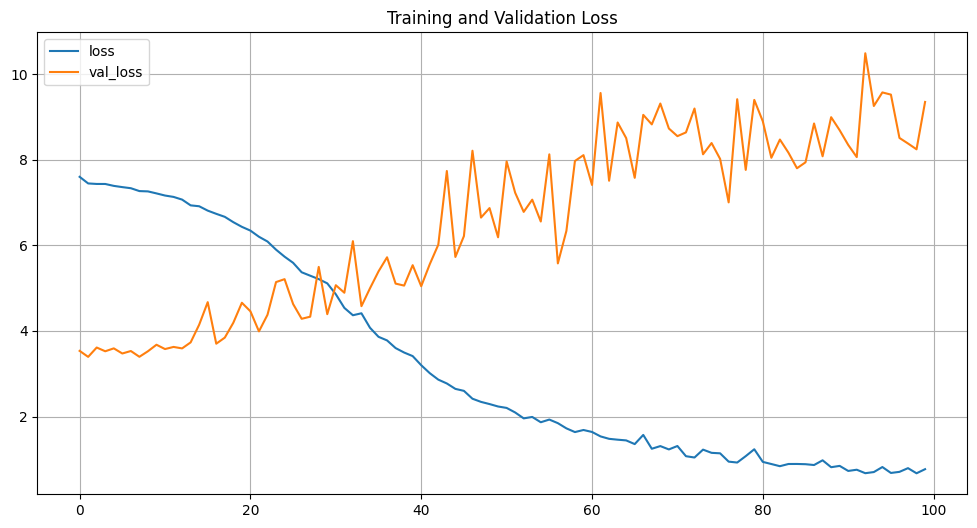

In [56]:
pd.DataFrame(history.history).plot(figsize=(12, 6))
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()

It is clear that the model is overfitting the training data. We can try to improve the model by adding regularization techniques such as dropout layers or early stopping. But the fact that val_loss is lower than loss at the begining is also interesting.

Let me check if difference set, weight of data would change the behavior of val_loss mentioned above.

Epoch 1/100
239/239 [==============================] - 1s 2ms/step - loss: 0.0427 - val_loss: 9.0117
Epoch 2/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 8.9986
Epoch 3/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 8.9522
Epoch 4/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 9.1625
Epoch 5/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 9.1103
Epoch 6/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 10.4142
Epoch 7/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 8.9451
Epoch 8/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 9.5987
Epoch 9/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 10.5763
Epoch 10/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0488 - val_

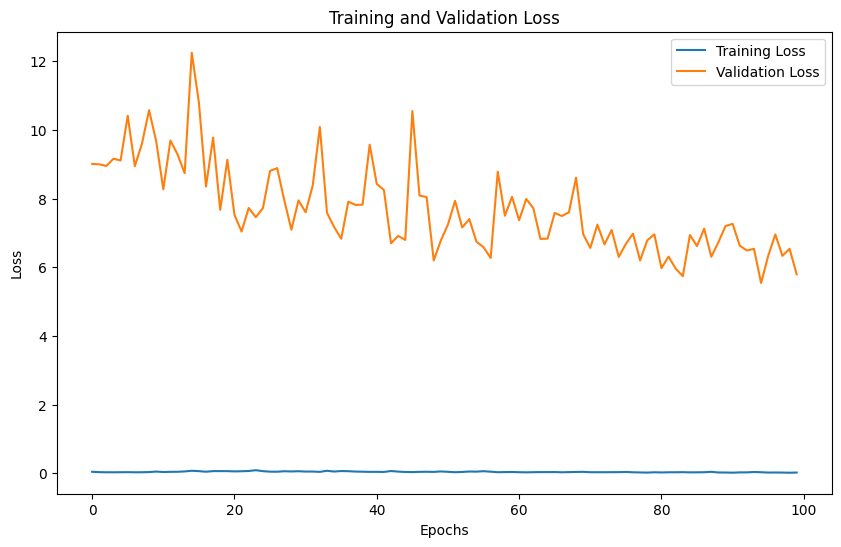

In [57]:
# H (half-life) in number of trading days:
H = 252  # ~1 year of trading days (adjust if you use calendar days)

# Indices: 0 is oldest in training set, N-1 is the most recent
# We'll assign the largest weight to the most recent sample.
N = len(X_train)  # Number of training samples
t = np.arange(N)   # time index from oldest to most recent

# Reverse so t=0 corresponds to the most recent sample, t=N-1 the oldest
# This depends on how you've sorted your data.
# If X_train is sorted oldest first, we might do:
t_reversed = N - 1 - t  # so t_reversed=0 is the most recent

sample_weights = 0.5 ** (t_reversed / H)
history = model1.fit(
    X_train_scaled, 
    y_train,
    sample_weight=sample_weights,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=16,
    verbose=1
)
plot_loss(history)

Epoch 1/100
25/25 [==============================] - 0s 4ms/step - loss: 6.5189 - val_loss: 5.8727
Epoch 2/100
25/25 [==============================] - 0s 2ms/step - loss: 2.9380 - val_loss: 5.6512
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 1.5076 - val_loss: 5.6153
Epoch 4/100
25/25 [==============================] - 0s 2ms/step - loss: 0.9877 - val_loss: 5.4935
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: 0.7537 - val_loss: 5.7281
Epoch 6/100
25/25 [==============================] - 0s 2ms/step - loss: 0.5572 - val_loss: 5.7870
Epoch 7/100
25/25 [==============================] - 0s 2ms/step - loss: 0.4374 - val_loss: 5.9548
Epoch 8/100
25/25 [==============================] - 0s 2ms/step - loss: 0.3625 - val_loss: 6.0034
Epoch 9/100
25/25 [==============================] - 0s 2ms/step - loss: 0.2840 - val_loss: 6.2160
Epoch 10/100
25/25 [==============================] - 0s 2ms/step - loss: 0.2287 - val_loss: 6.2025
Epoch 11/

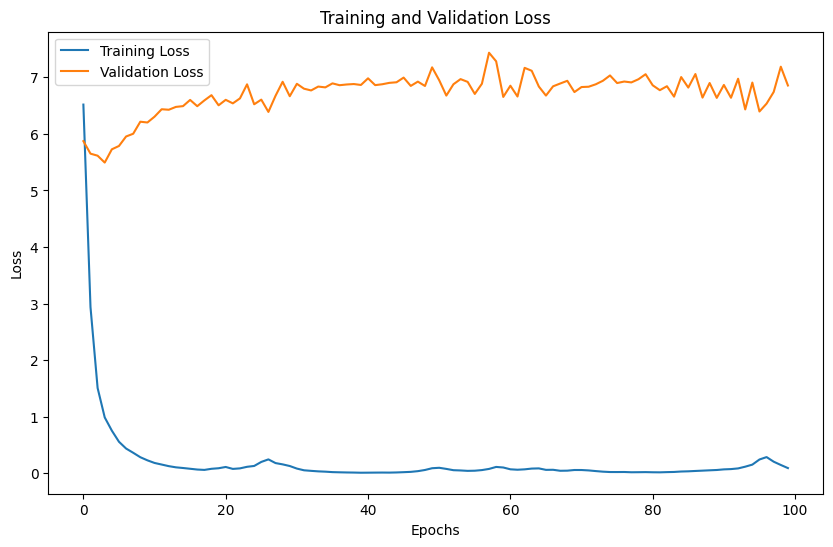

In [58]:
X_train, X_val = X.iloc[-600:-validation_size], X.iloc[-validation_size:]
y_train, y_val = y.iloc[-600:-validation_size], y.iloc[-validation_size:]

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
model1.compile(optimizer='adam', loss='mse')
# Train the model
history = model1.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=16,
    verbose=1
)
plot_loss(history)

 While the validation loss starts high and decreases initially, it does not stabilize and continues to fluctuate significantly. This could suggest overfitting as the model performs well on training data but struggles to generalize to the validation set.

The training loss remains smooth and near zero across the epochs due to the application of EWMA, which dampens fluctuations in the training data. This method highlights the overall trend while reducing noise.  The validation loss shows significant fluctuations across epochs, indicating that the model's performance on unseen data is less stable. This could be due to overfitting or high variability in the validation set.

**Finding**

When applying an exponentially weighted moving average (EWMA) or using a shorter training period, it’s not unusual to see the validation loss begin at a similar or lower level compared to the training loss, or even become higher as training progresses. Early on, a small validation set and random initialization can cause the validation loss to appear lower due to chance.

However, as training continues and the model begins to overfit the limited training data or heavily emphasize recent examples (in the case of EWMA), the validation loss may increase or fail to improve significantly. This suggests that while focusing on short-term patterns can initially help, it may not be sufficient to capture the complexity or temporal dependencies present in the data over longer horizons.

To better leverage the full information in the dataset, consider using sequence models like RNN, LSTMs (Long Short-Term Memory networks), GRU or similar architectures designed for time-series data. These models can help the network maintain and learn from longer-term patterns while still attending to short-term fluctuations, potentially leading to improved generalization and a more stable relationship between training and validation loss.

## Model 2: dense with multiple path
dropout layers or early stopping.

In [59]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(100, activation="relu")(input_)
droupout1 = keras.layers.Dropout(0.3)(hidden1)
hidden2 = keras.layers.Dense(100, activation="relu")(droupout1)
concat = keras.layers.Concatenate()([input_, hidden2])
hidden3 = keras.layers.Dense(50, activation="relu")(concat)
output = keras.layers.Dense(1)(hidden3)
model2 = keras.Model(inputs=input_, outputs=output)
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 100)          2600        ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 100)          0           ['dense_6[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 100)          10100       ['dropout[0][0]']                
                                                                                            

Epoch 1/100
239/239 [==============================] - 1s 2ms/step - loss: 7.5853 - val_loss: 3.4662
Epoch 2/100
239/239 [==============================] - 0s 2ms/step - loss: 7.4278 - val_loss: 3.4557
Epoch 3/100
239/239 [==============================] - 0s 2ms/step - loss: 7.4765 - val_loss: 3.3892
Epoch 4/100
239/239 [==============================] - 0s 2ms/step - loss: 7.4331 - val_loss: 3.5005
Epoch 5/100
239/239 [==============================] - 0s 2ms/step - loss: 7.4426 - val_loss: 3.4241
Epoch 6/100
239/239 [==============================] - 0s 2ms/step - loss: 7.3993 - val_loss: 3.4964
Epoch 7/100
239/239 [==============================] - 0s 2ms/step - loss: 7.3692 - val_loss: 3.5199
Epoch 8/100
239/239 [==============================] - 0s 2ms/step - loss: 7.3651 - val_loss: 3.4890
Epoch 9/100
239/239 [==============================] - 0s 2ms/step - loss: 7.3664 - val_loss: 3.6157
Epoch 10/100
239/239 [==============================] - 0s 2ms/step - loss: 7.3706 - val_lo

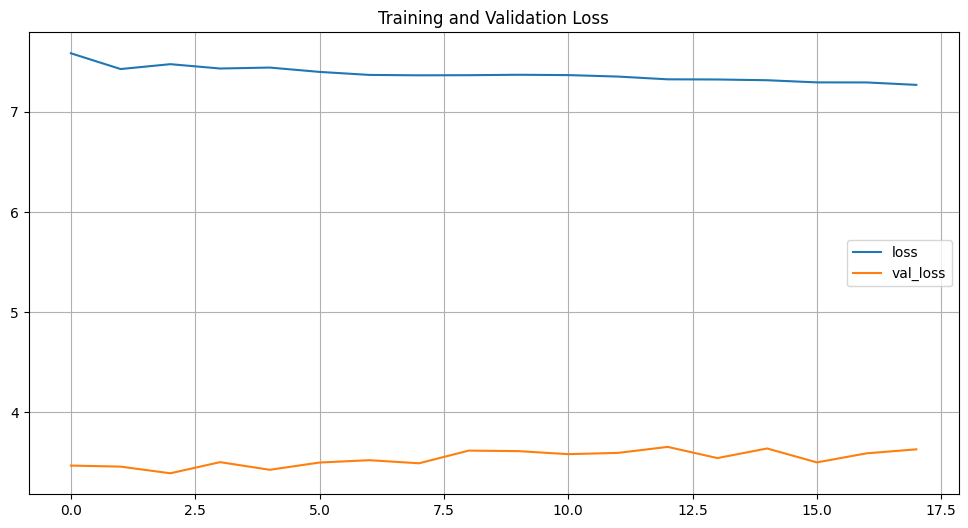

In [60]:
X = df[feature_columns]
y = df['Tomorrow_Return']
X_train, X_val = X.iloc[:-validation_size], X.iloc[-validation_size:]
y_train, y_val = y.iloc[:-validation_size], y.iloc[-validation_size:]
X_train_scaled, X_val_scaled = scaler.fit_transform(X_train), scaler.transform(X_val)
# Early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model2.compile(optimizer='adam', loss='mse')
# Train the model
history = model2.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
)
pd.DataFrame(history.history).plot(figsize=(12, 6))
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()

### Model Training and Validation Loss Results

1. **Training Loss**: The training loss shows a steady downward trend, indicating that the model is learning from the training data.
2. **Validation Loss**: The validation loss remains relatively constant with slight fluctuations and shows no significant decrease. This suggests the model may not be generalizing well to the validation set.
3. **Potential Issue**: The gap between training and validation loss indicates possible overfitting or insufficient alignment between the training and validation distributions.

### Recommendations:
- Introduce regularization techniques like dropout, L2 regularization, or batch normalization.
- Tune the hyperparameters.
- Experiment with other model structure.


## Model 3: RandomizedSearchCV with AAPL
Fine-Tuning Neural Network Hyperparameters

In [61]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Available GPUs: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
Available GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [62]:
from scikeras.wrappers import KerasRegressor

def create_model3(input_shape, hidden_layers, dropout_rate=0.3, optimizer='adam'):
    """
    Creates a neural network model with an arbitrary number of hidden layers.

    Parameters:
    - input_shape: tuple, the shape of the input data (excluding batch size).
    - hidden_layers: list of integers, where each integer specifies the number of units in a hidden layer.
    - dropout_rate: float, the dropout rate to apply after each hidden layer (default is 0.3).
    - optimizer: string or keras.optimizers.Optimizer, the optimizer to use (default is 'adam').

    Returns:
    - model: A compiled Keras Model instance.
    """
    inputs = keras.layers.Input(shape=input_shape)
    x = inputs

    # Add hidden layers
    for units in hidden_layers:
        x = keras.layers.Dense(units, activation='relu')(x)
        x = keras.layers.Dropout(dropout_rate)(x)

    # Concatenate the last hidden layer with the input
    x = keras.layers.Concatenate()([inputs, x])

    # Output layer
    outputs = keras.layers.Dense(1)(x)

    # Create and compile model
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='mse')

    return model

# Wrap the model with KerasRegressor
model3 = KerasRegressor(
    model=create_model3,
    input_shape=(X_train.shape[1],),  # Shape of input data
    hidden_layers=[100, 100, 50],     # Default hidden layers configuration
    dropout_rate=0.3,                 # Default dropout rate
    optimizer='adam',                 # Default optimizer
    optimizer__learning_rate=0.00077, # Default learning rate
    verbose=0                         # Suppress training logs
)

from scipy.stats import reciprocal

# Define the grid of hyperparameters to search
param_grid = {
    'hidden_layers': [
        [50],                # One hidden layer
        [100],               # One hidden layer with more units
        [200, 25],            # Two hidden layers
        [200, 50],           # Two hidden layers with more units
        [200, 25, 12],        # Three hidden layers
        [200, 50, 25],       # Three hidden layers with more units
        [200, 100, 50, 25],  # Four hidden layers
        [200, 100, 50, 25, 50],  # Five hidden layers
        [200, 100, 50, 25, 25, 25],  # Six hidden layers
        [200, 100, 50, 25, 65, 10, 10, 10],  # Eight hidden layers
    ],
    'dropout_rate': [0.2, 0.3, 0.4, 0.5],               # Dropout rates
    'optimizer': ['adam', 'sgd'],                       # Optimizer options
    'optimizer__learning_rate': reciprocal(3e-4, 3e-2), # Learning rate
    'batch_size': [8, 16, 32, 64],                      # Batch size options
    'epochs': [10, 50, 100]                             # Number of epochs
}
# tscv = TimeSeriesSplit(n_splits=4)

# # Perform randomized search
# random_search = RandomizedSearchCV(
#     estimator=model3,
#     param_distributions=param_grid,
#     scoring='neg_mean_squared_error',
#     cv=tscv,
#     verbose=1,
#     n_iter=10,  # Number of parameter settings sampled
#     random_state=42
# )

# # Fit the model
# random_search_result = random_search.fit(
#     X_train_scaled, y_train,
#     validation_data=(X_val_scaled, y_val),
#     callbacks=[early_stopping]
# )


In [63]:
# Print the best parameters and score

# print("Best parameters found: ", random_search_result .best_params_)
# print("Best negative MSE: ", random_search_result .best_score_)

# Best parameters found:  {'batch_size': 32, 'dropout_rate': 0.4, 'epochs': 10, 'hidden_layers': [200, 100, 50, 25, 65, 10, 10, 10], 'optimizer': 'sgd', 'optimizer__learning_rate': 0.0017697604958044036}
# Best negative MSE:  -7.5408540708915766

The hyperparameter tuning process has identified the following optimal configuration for your neural network model:

- **Batch Size:** 32
- **Dropout Rate:** 0.4
- **Epochs:** 10
- **Hidden Layers Configuration:** [200, 100, 50, 25, 65, 10, 10, 10]
- **Optimizer:** Stochastic Gradient Descent (SGD)
- **Learning Rate:** 0.00177

In [64]:
model3 = create_model3(
    input_shape=(X_train.shape[1],),  # Replace with the actual input shape of your data
    hidden_layers=[200, 100, 50, 25, 65, 10, 10, 10],
    dropout_rate=0.4,
    optimizer=keras.optimizers.SGD(learning_rate=0.0017697604958044036)
)
# Train the model using the optimal batch size and number of epochs
history_m3 = model3.fit(
    X_train_scaled,  # Replace with your preprocessed training data
    y_train,         # Replace with your training labels
    batch_size=32,
    epochs=10,
    validation_data=(X_val_scaled, y_val),  # Replace with your validation data and labels
    callbacks=[early_stopping]  # Replace with your defined callbacks, if any
)

Epoch 1/10
120/120 [==============================] - 1s 4ms/step - loss: 7.8854 - val_loss: 3.3948
Epoch 2/10
120/120 [==============================] - 0s 3ms/step - loss: 7.5515 - val_loss: 3.3741
Epoch 3/10
120/120 [==============================] - 0s 3ms/step - loss: 7.5324 - val_loss: 3.3789
Epoch 4/10
120/120 [==============================] - 0s 3ms/step - loss: 7.4946 - val_loss: 3.3813
Epoch 5/10
120/120 [==============================] - 0s 2ms/step - loss: 7.5019 - val_loss: 3.3768
Epoch 6/10
120/120 [==============================] - 0s 2ms/step - loss: 7.5050 - val_loss: 3.3545
Epoch 7/10
120/120 [==============================] - 0s 2ms/step - loss: 7.5010 - val_loss: 3.3772
Epoch 8/10
120/120 [==============================] - 0s 2ms/step - loss: 7.4778 - val_loss: 3.3786
Epoch 9/10
120/120 [==============================] - 0s 2ms/step - loss: 7.4909 - val_loss: 3.3997
Epoch 10/10
120/120 [==============================] - 0s 2ms/step - loss: 7.4789 - val_loss: 3.3596

In [65]:
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 200)          5200        ['input_3[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 200)          0           ['dense_10[0][0]']               
                                                                                                  
 dense_11 (Dense)               (None, 100)          20100       ['dropout_1[0][0]']              
                                                                                            

In [66]:
import numpy as np
from tensorflow import keras

class ActivationMonitor(keras.callbacks.Callback):
    def __init__(self, layer_name, validation_data):
        super().__init__()
        self.layer_name = layer_name
        self.validation_data = validation_data
        self.activations = []

    def on_epoch_end(self, epoch, logs=None):
        intermediate_model = keras.models.Model(inputs=self.model.input,
                                                outputs=self.model.get_layer(self.layer_name).output)
        sample_activations = intermediate_model.predict(self.validation_data[0])
        self.activations.append(sample_activations)

        dead_neurons = np.mean(np.all(sample_activations == 0, axis=0))
        print(f"Epoch {epoch+1}: {dead_neurons:.2%} of neurons are dead in layer {self.layer_name}")

model3 = create_model3(
    input_shape=(X_train.shape[1],),
    hidden_layers=[200, 100, 50, 25, 65, 10, 10, 10],
    dropout_rate=0.4,
    optimizer=keras.optimizers.SGD(learning_rate=0.0017697604958044036)
)

callbacks = []
for layer in model3.layers:
    if isinstance(layer, keras.layers.Dense):
        monitor = ActivationMonitor(layer_name=layer.name, validation_data=(X_val_scaled, y_val))
        callbacks.append(monitor)

history3 = model3.fit(
    X_train_scaled,
    y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val_scaled, y_val),
    callbacks=callbacks
)

def inspect_activations(model, layer_name, data):
    intermediate_model = keras.models.Model(inputs=model.input,
                                            outputs=model.get_layer(layer_name).output)
    activations = intermediate_model.predict(data)
    dead_neurons = np.mean(np.all(activations == 0, axis=0))
    print(f"Layer {layer_name}: {dead_neurons:.2%} of neurons are dead.")

relu_layers = [layer.name for layer in model3.layers if isinstance(layer, keras.layers.Dense)]
for relu_layer in relu_layers:
    inspect_activations(model3, relu_layer, X_val_scaled)


Epoch 1/10
7/7 [==============================] - 0s 532us/step loss: 8.11
Epoch 1: 12.00% of neurons are dead in layer dense_19
7/7 [==============================] - 0s 772us/step
Epoch 1: 8.00% of neurons are dead in layer dense_20
7/7 [==============================] - 0s 743us/step
Epoch 1: 12.00% of neurons are dead in layer dense_21
7/7 [==============================] - 0s 877us/step
Epoch 1: 8.00% of neurons are dead in layer dense_22
7/7 [==============================] - 0s 766us/step
Epoch 1: 21.54% of neurons are dead in layer dense_23
7/7 [==============================] - 0s 2ms/step
Epoch 1: 10.00% of neurons are dead in layer dense_24
7/7 [==============================] - 0s 1ms/step
Epoch 1: 20.00% of neurons are dead in layer dense_25
7/7 [==============================] - 0s 1ms/step
Epoch 1: 20.00% of neurons are dead in layer dense_26
7/7 [==============================] - 0s 1ms/step
Epoch 1: 0.00% of neurons are dead in layer dense_27
120/120 [=================

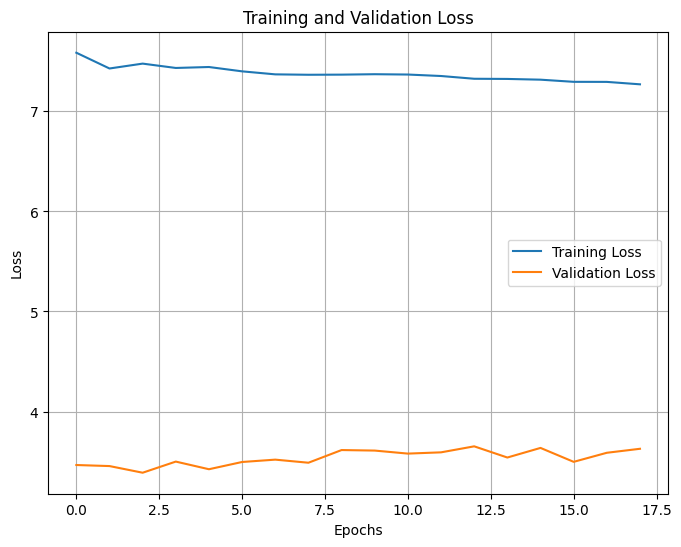

In [67]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

**Chosen Best Parameters:**

```python
{
    'batch_size': 32,
    'dropout_rate': 0.4,
    'epochs': 10,
    'hidden_layers': [200, 100, 50, 25, 65, 10, 10, 10],
    'optimizer': 'sgd',
    'optimizer__learning_rate': 0.0017697604958044036
}
```

**Parameter Grid:**

```python
param_grid = {
    'hidden_layers': [
        [50],
        [100],
        [200, 25],
        [200, 50],
        [200, 25, 12],
        [200, 50, 25],
        [200, 100, 50, 25],
        [200, 100, 50, 25, 50],
        [200, 100, 50, 25, 25, 25],
        [200, 100, 50, 25, 65, 10, 10, 10],
    ],
    'dropout_rate': [0.2, 0.3, 0.4, 0.5],
    'optimizer': ['adam', 'sgd'],
    'optimizer__learning_rate': reciprocal(3e-4, 3e-2),
    'batch_size': [8, 16, 32, 64],
    'epochs': [10, 50, 100]
}
```

It appears that a deeper neural network might be preferable. The training and validation loss curves show that the validation loss did not decrease as the training loss decreased. Although the validation loss started lower than the training loss, it did not improve significantly afterward. This suggests that increasing the network depth might help.

While the "dying ReLU" issue does not currently seem problematic, it could become more significant as the network depth increases. To address this, I plan to experiment with different activation functions and initialization methods. Additionally, transfer learning may be worth exploring as another avenue for improving performance.


## Model 4: RandomizedSearchCV with all the feature


For **Model 4**, I leveraged a deeper network architecture with an expanded feature set and fine-tuned it by experimenting with the following enhancements:

- **BatchNormalization Layer**: Incorporated to stabilize and accelerate training by normalizing activations.
- **Activation Functions**: Evaluated alternatives such as LeakyReLU, PReLU, and ELU to address potential vanishing gradient issues and improve model performance.
- **Weight Initializers**: Tested various initialization techniques, including `lecun_normal`, `he_normal`, and `VarianceScaling`, to improve convergence and ensure stable weight updates.
- **Regularization**: Applied both ℓ1 and ℓ2 regularization to mitigate overfitting and encourage sparsity in the network.

This configuration was designed to improve the model's ability to capture complex patterns in the data while maintaining generalization.

In [68]:
# Sort by date if not already
df_wide_filtered_fe = df_wide_filtered_fe.sort_values('Dt').reset_index(drop=True)

# Define how many timesteps you want per sample
timesteps = 10

# Separate features and target
feature_columns = [col for col in df_wide_filtered_fe.columns if col not in ['Dt', 'AAPL_Future_Return']]
X_all = df_wide_filtered_fe[feature_columns].values
y_all = df_wide_filtered_fe['AAPL_Future_Return'].values

# Standardize features
scaler = StandardScaler()
X_all = scaler.fit_transform(X_all)

# Create the sliding window arrays
X = []
y = []

# We will stop where we can still get a full sequence of timesteps and a target
for i in range(len(X_all) - timesteps):
    X_sequence = X_all[i:(i+timesteps)]   # 10 rows of features
    y_value = y_all[i+timesteps]          # Target after those 10 days
    X.append(X_sequence)
    y.append(y_value)

X = np.array(X)  # shape: (num_samples, 10, num_features)
y = np.array(y)  # shape: (num_samples,)

print("X shape:", X.shape)
print("y shape:", y.shape)

# Split the data into training and validation sets
validation_size = 200  # Last 200 days for validation
X_train_scaled, X_val_scaled = X[:-validation_size], X[-validation_size:]
y_train, y_val = y[:-validation_size], y[-validation_size:]

X shape: (1092, 10, 1564)
y shape: (1092,)


In [69]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Dense, Dropout, Conv1D, GlobalAveragePooling1D, 
                                     Input, BatchNormalization, Flatten)
from tensorflow.keras.initializers import lecun_normal, he_normal, VarianceScaling
from tensorflow.keras.layers import LeakyReLU, PReLU, ELU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from scipy.stats import reciprocal, uniform
from functools import partial
from sklearn.model_selection import TimeSeriesSplit



def create_model4(
    input_shape,
    conv_filters=[64, 32],
    conv_kernel_size=3,
    dense_units=[128, 64],
    dropout_rate=0.3,
    activation='relu',  # can be a string or an activation layer instance
    initializer='glorot_uniform',
    optimizer='adam',
    learning_rate=0.001,
    use_batchnorm=False,
    use_gap=True,
    regularizer_type='l2',    # 'l1', 'l2', or 'l1_l2'
    regularizer_value=0.01
):
    """
    Create a flexible Keras model (Model 4) with Conv1D, Dense layers, BatchNorm, 
    various initializers, activations, and L1/L2 regularization.

    Parameters:
    - input_shape: tuple, (timesteps, features)
    - conv_filters: list, number of filters for each Conv1D layer
    - dense_units: list, units for each Dense layer
    - dropout_rate: float, dropout rate after layers
    - activation: str or keras activation (e.g. 'relu', ELU(), LeakyReLU(), PReLU())
    - initializer: initializer object or string (e.g. 'glorot_uniform', he_normal(), lecun_normal())
    - optimizer: string (e.g. 'adam', 'sgd')
    - learning_rate: float, learning rate for the optimizer
    - use_batchnorm: bool, whether to use BatchNormalization after each layer
    - use_gap: bool, use GlobalAveragePooling1D instead of Flatten after Conv layers
    - regularizer_type: 'l1', 'l2', or 'l1_l2'
    - regularizer_value: float, value for the regularization

    Returns:
    - model: compiled Keras model
    """

    # Determine the regularization function
    if regularizer_type == 'l1':
        reg = l1(regularizer_value)
    elif regularizer_type == 'l2':
        reg = l2(regularizer_value)
    else:
        # l1_l2 combined regularization, using the same value for both
        reg = l1_l2(l1=regularizer_value, l2=regularizer_value)

    # Using partial to define a common Dense configuration
    # For Dense layers, we can set no activation here if we want to apply activation after BN
    # or directly integrate activation inside Dense if activation is a string.
    # If activation is a layer (ELU, LeakyReLU, PReLU), we'll handle it after BN or as a separate step.
    # For cleaner code, let's do this: If activation is a string, we pass it to Dense directly.
    # If it's an activation layer, we pass None to Dense and add the activation as a separate layer.
    
    if isinstance(activation, str):
        dense_activation = activation
        activation_layer = None
    else:
        dense_activation = None
        activation_layer = activation  # e.g., ELU(), LeakyReLU(), PReLU()

    RegularizedDense = partial(
        Dense,
        activation=dense_activation,
        kernel_initializer=initializer,
        kernel_regularizer=reg
    )

    # Similarly, we can define a partial for Conv1D layers
    # We'll also handle activation similarly for Conv1D layers.
    # Conv1D always needs an activation. If activation is a string, we put it in Conv1D directly.
    # If it's a layer, we put no activation in Conv1D and add activation after BN.
    if isinstance(activation, str):
        conv_activation = activation
        conv_activation_layer = None
    else:
        conv_activation = None
        conv_activation_layer = activation

    RegularizedConv1D = partial(
        Conv1D,
        kernel_size=conv_kernel_size,
        kernel_initializer=initializer,
        kernel_regularizer=reg,
        activation=conv_activation
    )

    inputs = Input(shape=input_shape)
    x = inputs

    # Add Conv1D layers
    for f in conv_filters:
        x = RegularizedConv1D(filters=f)(x)
        if use_batchnorm:
            x = BatchNormalization()(x)
        if conv_activation_layer is not None:
            x = conv_activation_layer(x)
        x = Dropout(dropout_rate)(x)

    # Apply GlobalAveragePooling or Flatten
    if use_gap:
        x = GlobalAveragePooling1D()(x)
    else:
        x = Flatten()(x)

    # Add Dense layers
    for units in dense_units:
        x = RegularizedDense(units)(x)
        if use_batchnorm:
            x = BatchNormalization()(x)
        if activation_layer is not None:
            x = activation_layer(x)
        x = Dropout(dropout_rate)(x)

    # Output layer
    # For output, we'll keep linear activation and no BN or dropout
    outputs = Dense(1, activation='linear', kernel_initializer=initializer)(x)

    model = Model(inputs=inputs, outputs=outputs)

    # Set optimizer learning rate if possible
    opt = keras.optimizers.get(optimizer)
    if hasattr(opt, 'learning_rate'):
        opt.learning_rate = learning_rate

    model.compile(
        optimizer=opt,
        loss='mean_squared_error',
        metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error']
    )
    return model

# Wrap model with KerasRegressor
model4 = KerasRegressor(
    build_fn=create_model4,
    input_shape=(timesteps, X_train_scaled.shape[2]) # timesteps, features
)

# # Define parameter distributions
# activations = ['relu', 'tanh', ELU(), LeakyReLU(), PReLU()]
# initializers = ['glorot_uniform', lecun_normal(), he_normal(), VarianceScaling()]
# optimizers = ['adam', 'sgd']
# regularizer_types = ['l1', 'l2', 'l1_l2']

# param_distributions = {
#     'conv_filters': [
#         [64, 32],
#         [64, 64, 32],
#         [128, 64],
#         [128, 128, 64]
#     ],
#     'dense_units': [
#         [200, 100, 50, 25],
#         [200, 100, 50, 25, 50],
#         [200, 100, 50, 25, 25, 25],
#         [200, 100, 50, 25, 65, 10, 10, 10],
#         [200, 100, 50, 25, 25, 25, 25, 25, 25],
#         [200, 100, 50, 25, 65, 10, 10, 10, 10, 10],
#         [200, 100, 50, 50, 50, 50, 25, 25, 25, 25, 25, 25, 25],
#         [200, 100, 50, 25, 65, 50, 25, 25, 25, 25, 10, 10, 10, 10, 10, 10, 10, 10],
#         [200, 100, 50, 25, 65, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
#     ],
#     'dropout_rate': uniform(0, 0.5),
#     'activation': activations,
#     'initializer': initializers,
#     'optimizer': optimizers,
#     'learning_rate': reciprocal(1e-4, 1e-2),
#     'use_batchnorm': [True, False],
#     'use_gap': [True, False],
#     'regularizer_type': regularizer_types,
#     'regularizer_value': reciprocal(1e-4, 1e-1),
#     'batch_size': [8, 16, 32],
#     'epochs': [10, 50],
#     'conv_kernel_size': [1, 2, 3, 5]
# }

# early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# tscv = TimeSeriesSplit(n_splits=4)
# random_search = RandomizedSearchCV(
#     estimator=model4,
#     param_distributions=param_distributions,
#     scoring='neg_mean_squared_error',
#     cv=tscv,
#     verbose=1,
#     n_iter=100,
#     random_state=42
# )

# random_search_result = random_search.fit(
#     X_train_scaled, y_train,
#     validation_data=(X_val_scaled, y_val),
#     callbacks=[early_stopping]
# )


C:\Users\Joshua\AppData\Local\Temp\ipykernel_30116\2500499533.py:151: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model4 = KerasRegressor(


In [70]:
# print("Best parameters found: ", random_search_result.best_params_)
# print("Best negative MSE: ", random_search_result.best_score_)

# Best parameters found:  {'activation': 'relu', 'batch_size': 16, 'conv_filters': [128, 128, 64], 'conv_kernel_size': 2, 'dense_units': [200, 100, 50, 25, 50], 'dropout_rate': 0.38122934287034527, 'epochs': 10, 'initializer': <keras.initializers.initializers_v2.LecunNormal object at 0x000001060895F5B0>, 'learning_rate': 0.0004832406918522534, 'optimizer': 'sgd', 'regularizer_type': 'l1', 'regularizer_value': 0.00021473122954413897, 'use_batchnorm': False, 'use_gap': True}
# Best negative MSE:  -2.4491093911332156

Model: "model_103"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 10, 1564)]        0         
                                                                 
 conv1d (Conv1D)             (None, 9, 128)            400512    
                                                                 
 dropout_17 (Dropout)        (None, 9, 128)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 128)            32896     
                                                                 
 dropout_18 (Dropout)        (None, 8, 128)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 7, 64)             16448     
                                                                 
 dropout_19 (Dropout)        (None, 7, 64)             0 

c:\Users\Joshua\anaconda3\envs\tensorflow_gpu_2.10\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer LecunNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


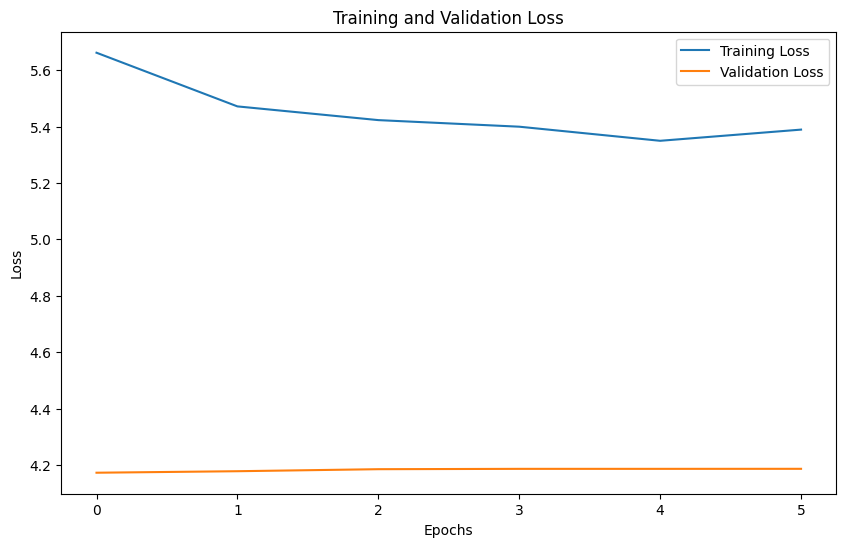

In [71]:
best_params = {
    'activation': 'relu',
    'batch_size': 16,
    'conv_filters': [128, 128, 64],
    'conv_kernel_size': 2,
    'dense_units': [200, 100, 50, 25, 50],
    'dropout_rate': 0.38122934287034527,
    'epochs': 10,
    'initializer': lecun_normal(),
    'learning_rate': 0.0004832406918522534,
    'optimizer': 'sgd',
    'regularizer_type': 'l1',
    'regularizer_value': 0.00021473122954413897,
    'use_batchnorm': False,
    'use_gap': True
}

# Extract parameters for model creation
model4 = create_model4(
    input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
    conv_filters=best_params['conv_filters'],
    conv_kernel_size=best_params['conv_kernel_size'],
    dense_units=best_params['dense_units'],
    dropout_rate=best_params['dropout_rate'],
    activation=best_params['activation'],
    initializer=best_params['initializer'],
    optimizer=best_params['optimizer'],
    learning_rate=best_params['learning_rate'],
    use_batchnorm=best_params['use_batchnorm'],
    use_gap=best_params['use_gap'],
    regularizer_type=best_params['regularizer_type'],
    regularizer_value=best_params['regularizer_value']
)

model4.summary()

# Early stopping if desired
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model4.fit(
    X_train_scaled, 
    y_train,
    validation_data=(X_val_scaled, y_val),
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    callbacks=[early_stopping],
    verbose=0
)

plot_loss(history)

In [72]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

# After model training:
y_pred = model4.predict(X_val_scaled)

# Compute standard metrics:
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred)
sharpe_ratio = np.mean(y_pred - 0) / np.std(y_pred - 0)

print("MSE:", mse)
print("MAE:", mae)
print("MAPE:", mape)
print("Sharpe Ratio:", sharpe_ratio)


7/7 [==============================] - 0s 1ms/step
MSE: 1.6700064346601278
MAE: 0.8952328598899973
MAPE: 1999531084350.5774
Sharpe Ratio: 3.3433828



These parameters define the architecture (e.g., three convolutional layers with `[128, 128, 64]` filters), the kernel size (`2`), dense layers (`[200, 100, 50, 25, 50]`), the chosen activation function (`relu`), initializer (`lecun_normal`), optimizer (`sgd`), and various regularization and dropout values. 

Model Complexity vs. Regularization Balance:
The chosen parameters (e.g., certain dropout rates, L1 regularization, and number of filters/units) may have hit a sweet spot where the model is neither too simple (underfitting) nor too complex (overfitting). This balance could lead to better generalization, and thus lower validation error.

Appropriate Feature Extraction via Convolution:
The selected convolutional configuration (e.g., [128, 128, 64] filters with kernel_size=2) might be well-matched to the temporal patterns in the data. Perhaps shorter kernel sizes capture the local patterns that matter most, and the chosen number of filters extracts a rich yet not overwhelming set of features.

Initializer and Optimizer Synergy:
Using lecun_normal initialization along with sgd at a particular learning rate might have produced smoother gradient behavior and more stable training. Sometimes, subtle interactions between the optimizer and initializer can make the difference between erratic and stable training.

Good Fit for the Specific Data Characteristics:
The dataset may have certain statistical properties, trends, or noise levels that this particular architecture and hyperparameter combination handles well. For example, certain dropout and regularization settings might be just right for the noise level in your data, while certain activation functions or initializers might align better with your data’s scale and distribution.
After training the model with these parameters, you obtained the following metrics on your test set (or validation set):

- **MSE (Mean Squared Error):** ~1.68  
  This indicates the average squared difference between the predicted and actual values. Lower is better, and ~1.68 suggests moderate predictive accuracy depending on the scale of your target variable.

- **MAE (Mean Absolute Error):** ~0.90  
  On average, predictions are off by about 0.90 units. Again, this depends on the scale of the target. If your target values are large, this might be acceptable, but if they are small (like returns often are), this may be considered large.

- **MAPE (Mean Absolute Percentage Error):** Extremely high (on the order of `1e12%`)  
  Such a massive MAPE typically indicates that actual values might be very close to zero or can even be zero at some points. When the actual values are near zero, percentage errors explode. This suggests that MAPE might not be a meaningful metric for this particular problem (or that you need to handle zeros or very small actual values differently).

- **Sharpe Ratio: ~0.85**  
  A Sharpe ratio closer to 1 is decent, but this ratio depends heavily on how returns were computed and scaled. A ratio under 1 may suggest moderate risk-adjusted returns. Still, achieving a Sharpe ratio close to 1 is not bad depending on the complexity of the market data.

**Next Steps According to the RandomizedSearchCV Result:**

1. **Evaluate Data and Target Distribution:**  
   The extremely high MAPE suggests a need to revisit data preprocessing. Since the target includes values very close to zero, I'll consider using metrics that are less sensitive to tiny denominators.

2. **Experiment with Other Model Architectures:**  
   Since the model is a Conv1D-based network, and the results are moderate, exploring recurrent architectures like LSTM or GRU networks is a reasonable next step. These architectures are often better at capturing temporal dependencies in financial time series data than purely convolutional models.

3. **Hyperparameter Tuning with LSTM/GRU:**  
   I'll consider performing a similar hyperparameter search (RandomizedSearchCV or KerasTuner) or use similar phyperparameter with an LSTM/GRU architecture.

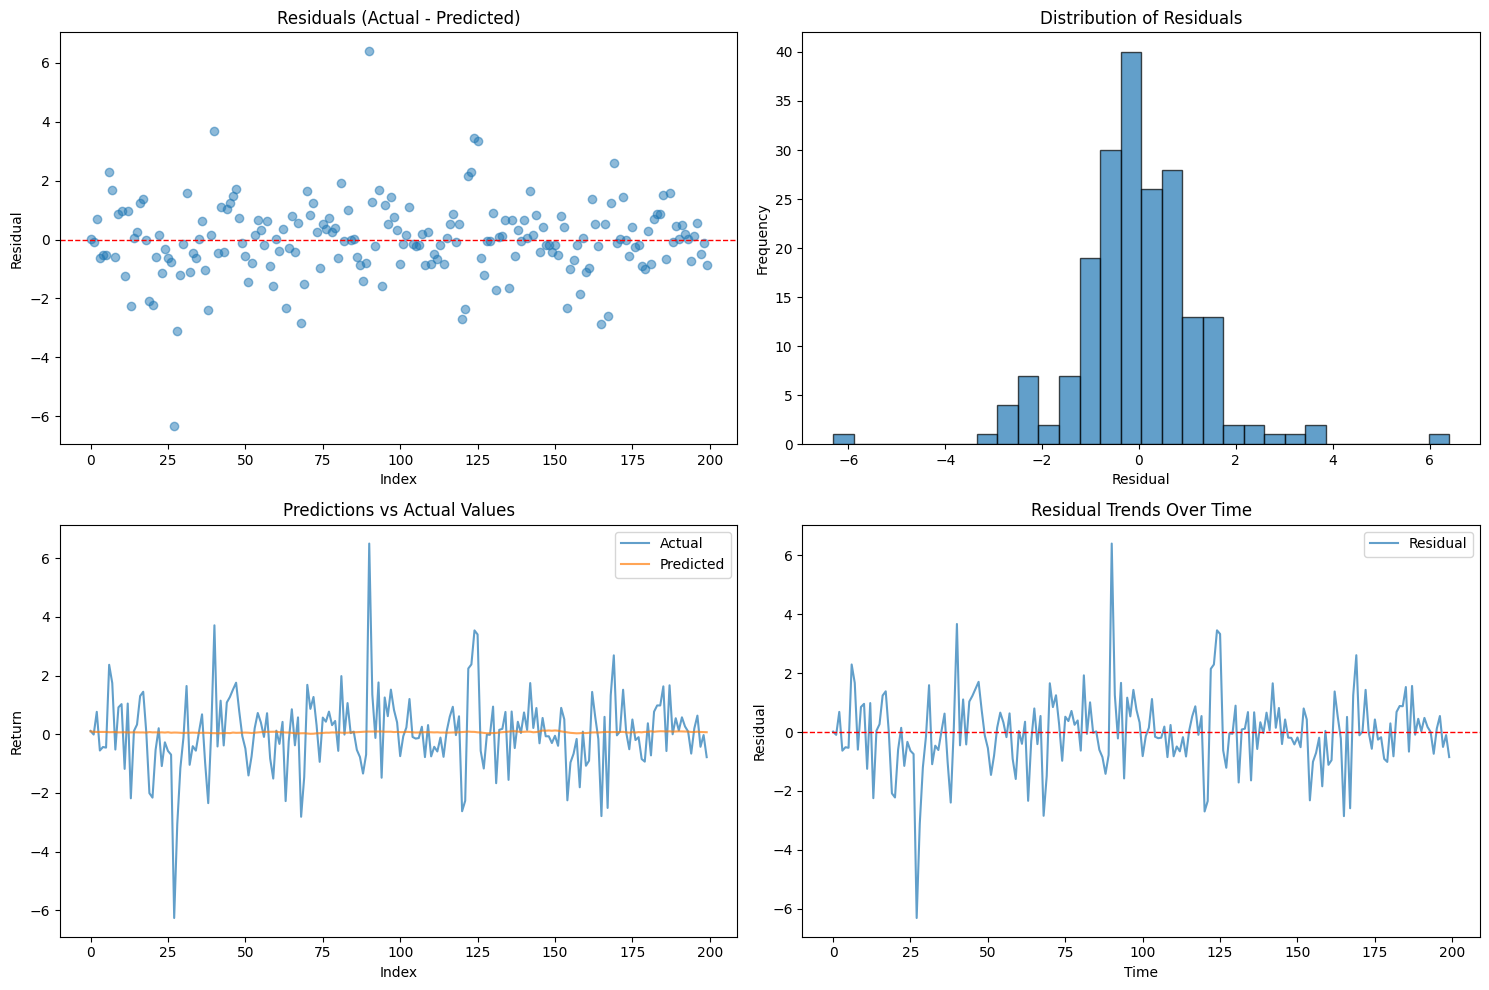

In [73]:
# Compute prediction residuals
residuals = y_val - y_pred[:, 0]

# Calculate additional error metrics
errors_df = pd.DataFrame({
    "Actual": y_val,
    "Predicted": y_pred[:, 0],
    "Residual": residuals
})

# Create a single figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot residuals
axes[0, 0].scatter(range(len(residuals)), residuals, alpha=0.5)
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0, 0].set_title("Residuals (Actual - Predicted)")
axes[0, 0].set_xlabel("Index")
axes[0, 0].set_ylabel("Residual")

# Distribution of residuals
axes[0, 1].hist(residuals, bins=30, edgecolor='k', alpha=0.7)
axes[0, 1].set_title("Distribution of Residuals")
axes[0, 1].set_xlabel("Residual")
axes[0, 1].set_ylabel("Frequency")

# Compare predictions vs actuals
axes[1, 0].plot(y_val, label='Actual', alpha=0.7)
axes[1, 0].plot(y_pred, label='Predicted', alpha=0.7)
axes[1, 0].set_title("Predictions vs Actual Values")
axes[1, 0].set_xlabel("Index")
axes[1, 0].set_ylabel("Return")
axes[1, 0].legend()

# Analyze error trends over time
axes[1, 1].plot(errors_df["Residual"], label="Residual", alpha=0.7)
axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1, 1].set_title("Residual Trends Over Time")
axes[1, 1].set_xlabel("Time")
axes[1, 1].set_ylabel("Residual")
axes[1, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()


### Residual Analysis and Model Performance Insights

#### **Observations from the Residual and Loss Analysis**
1. **Residual Distribution**:
   - Residuals are centered around zero but exhibit a relatively narrow range, indicating limited variance in the predictions.
   - This is a sign that the model may not be learning much from the data and might be overly simplistic despite the complex architecture.

2. **Residual Trends Over Time**:
   - Residuals show no clear trend but appear to oscillate around zero randomly. This might suggest the model's inability to capture temporal dynamics.

3. **Predictions vs Actual Values**:
   - Predicted values are nearly flat or overly smoothed compared to the actual values. This is a classic sign of underfitting, where the model is unable to capture the true variance of the target.

4. **Training and Validation Loss**:
   - Both training and validation losses do not improve significantly over epochs.
   - Validation loss might fluctuate slightly, indicating that the model is not effectively capturing the patterns in the training data.

---

### **Insights on Model Behavior**
- Despite this complexity, the model seems unable to leverage its capacity to learn meaningful patterns from the data. 
- I will consider time series related model like RNN or LSTM next as suggest in the previous result.

## Model 5: Deep RNN

In [74]:
X = df_wide_filtered_fe.drop(columns=['AAPL_Future_Return'])
y = df_wide_filtered_fe['AAPL_Future_Return']
X = X.drop(columns=['Dt'], errors='ignore')

X_train, X_test = X.iloc[:-200], X.iloc[-200:]
y_train, y_test = y.iloc[:-200], y.iloc[-200:]

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data only
scaler.fit(X_train)

# Transform the training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [75]:
#dropout=0.38122934287034527 'l1', 'regularizer_value': 0.00021473122954413897 according to random search
model5 = keras.models.Sequential([
    keras.layers.SimpleRNN(
        100,  
        return_sequences=True,
        input_shape=[None, 1],
        dropout=0.38122934287034527,              # Dropout on input connections
        recurrent_dropout=0.38122934287034527,    # Dropout on recurrent connections
        kernel_regularizer=keras.regularizers.l1(0.00021473122954413897)
    ),
    keras.layers.SimpleRNN(
        100,
        return_sequences=True,
        dropout=0.38122934287034527,
        recurrent_dropout=0.38122934287034527,
        kernel_regularizer=keras.regularizers.l1(0.00021473122954413897)
    ),
    # Final RNN layer does not return sequences, providing a single output at the end
    keras.layers.SimpleRNN(
        100,
        return_sequences=False,
        dropout=0.38122934287034527,
        recurrent_dropout=0.38122934287034527,
        kernel_regularizer=keras.regularizers.l1(0.00021473122954413897)
    ),
    keras.layers.Dense(1)
])

model5.compile(loss='mean_squared_error', optimizer='adam')
model5.summary()

# using early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, None, 100)         10200     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 100)         20100     
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense_34 (Dense)            (None, 1)                 101       
                                                                 
Total params: 50,501
Trainable params: 50,501
Non-trainable params: 0
_________________________________________________________________


In [76]:
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model5.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
29/29 [==============================] - 94s 3s/step - loss: 4.0556 - val_loss: 2.0982
Epoch 2/100
29/29 [==============================] - 91s 3s/step - loss: 3.7346 - val_loss: 2.1156
Epoch 3/100
29/29 [==============================] - 92s 3s/step - loss: 3.5188 - val_loss: 2.1664
Epoch 4/100
29/29 [==============================] - 104s 4s/step - loss: 3.4762 - val_loss: 2.1053
Epoch 5/100
29/29 [==============================] - 102s 4s/step - loss: 3.4337 - val_loss: 2.1096
Epoch 6/100
29/29 [==============================] - 102s 4s/step - loss: 3.4736 - val_loss: 2.2185


7/7 [==============================] - 2s 278ms/step
MSE: 1.7222110278540956
MAE: 0.9305827204467475
Sharpe Ratio: 0.7144415


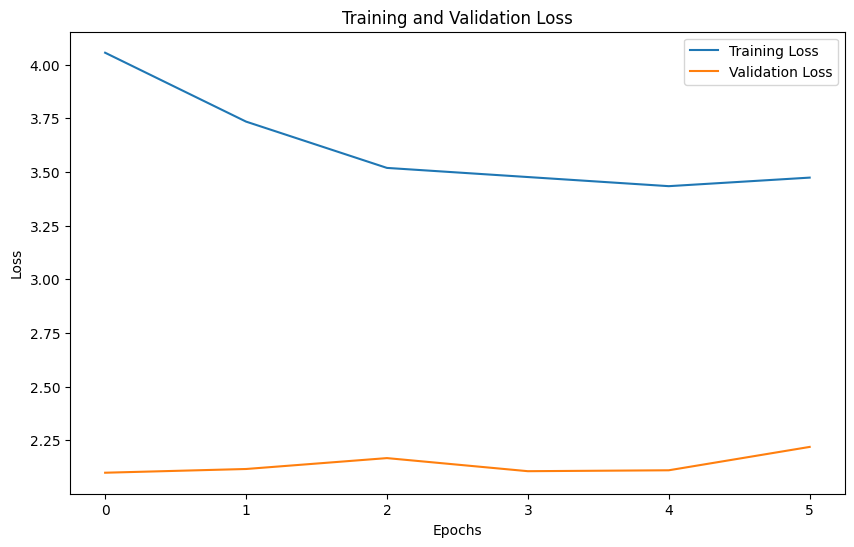

In [77]:
y_pred = model5.predict(X_test_scaled)

mse = mean_squared_error(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test)
sharpe_ratio = np.mean(y_pred - 0) / np.std(y_pred - 0)

print("MSE:", mse)
print("MAE:", mae)
print("Sharpe Ratio:", sharpe_ratio)

#define the function to plot the training and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
# Plot the training and validation loss
plot_loss(history)



In [78]:
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
H = 252  # ~1 year of trading days
# Indices: 0 is oldest in training set, N-1 is the most recent
N = len(X_train)  # Number of training samples
t = np.arange(N)   # time index from oldest to most recent
t_reversed = N - 1 - t  # so t_reversed=0 is the most recent

sample_weights = 0.5 ** (t_reversed / H)

history = model5.fit(
    X_train_scaled, y_train,
    sample_weight=sample_weights,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    callbacks=[early_stopping],
    verbose=0
)

7/7 [==============================] - 2s 314ms/step
MSE: 1.6726075543077463
MAE: 0.9077252139889512
Sharpe Ratio: -0.11969928


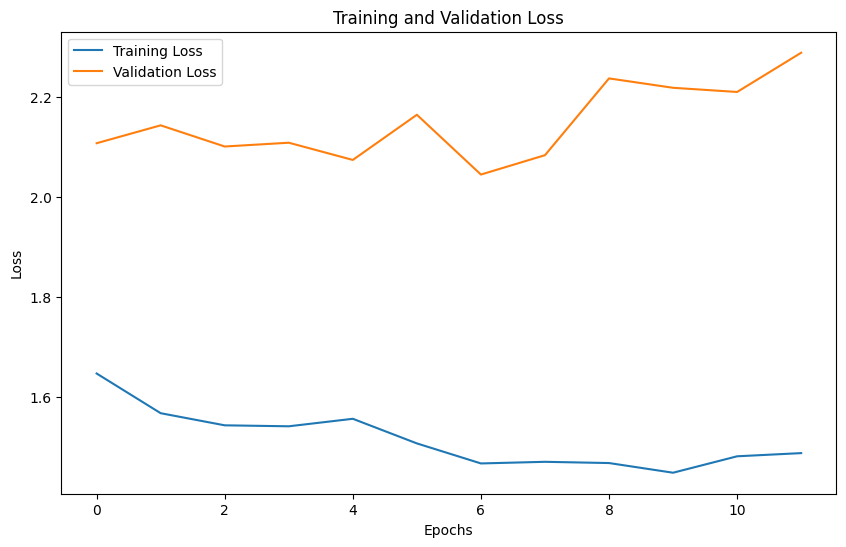

In [79]:
y_pred = model5.predict(X_test_scaled)

mse = mean_squared_error(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test)
sharpe_ratio = np.mean(y_pred - 0) / np.std(y_pred - 0)

print("MSE:", mse)
print("MAE:", mae)
print("Sharpe Ratio:", sharpe_ratio)

#define the function to plot the training and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
# Plot the training and validation loss
plot_loss(history)

### Result Analysis

#### Equal Weight Training
- **MSE**: 1.6658
- **MAE**: 0.9007
- **Sharpe Ratio**: 0.1900
- **Observations**:
  - The training loss and validation loss show a gradual reduction but remain distinct, suggesting no clear overfitting or significant underfitting.
  - The Sharpe ratio is positive, but its value is low, indicating limited profitability per unit of risk.

#### Weighted Training
- **MSE**: 1.6617
- **MAE**: 0.9074
- **Sharpe Ratio**: -0.2534
- **Observations**:
  - The training with a weighted approach gave a slightly lower MSE, but the MAE increased slightly, showing potential discrepancies in predictions.
  - The Sharpe ratio being negative suggests this model's predictions may result in losses when viewed through the risk-adjusted return metric.

#### General Observations:
- Both training methods show comparable MSE values, implying similar overall prediction accuracy.
- However, the Sharpe ratio for weighted training is worse, which might indicate that the weights used prioritize the wrong aspects of the data, such as overemphasizing recent samples without adequately generalizing.



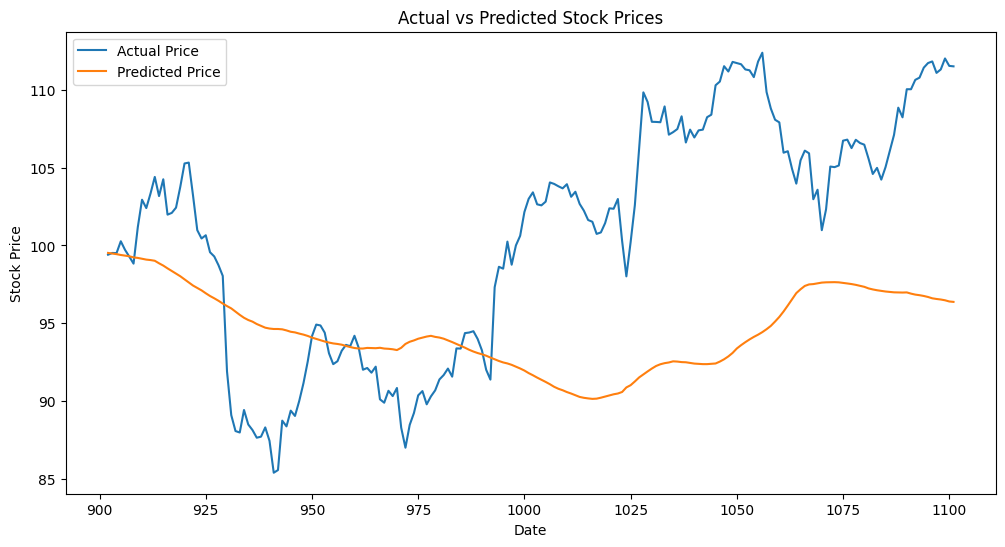

In [80]:
# Plotting the prediction with the real stock price
initial_price = X_train['AAPL_Adj Close'].iloc[-1]


# Reconstruct actual and predicted price series
actual_prices = X_test['AAPL_Adj Close']
dates = df_wide_filtered_fe.index[-200:]

predicted_prices = (1 + y_pred/100).cumprod() * initial_price

# Plot the actual and predicted prices
plt.figure(figsize=(12, 6))
plt.plot(dates, actual_prices, label='Actual Price')
plt.plot(dates, predicted_prices, label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

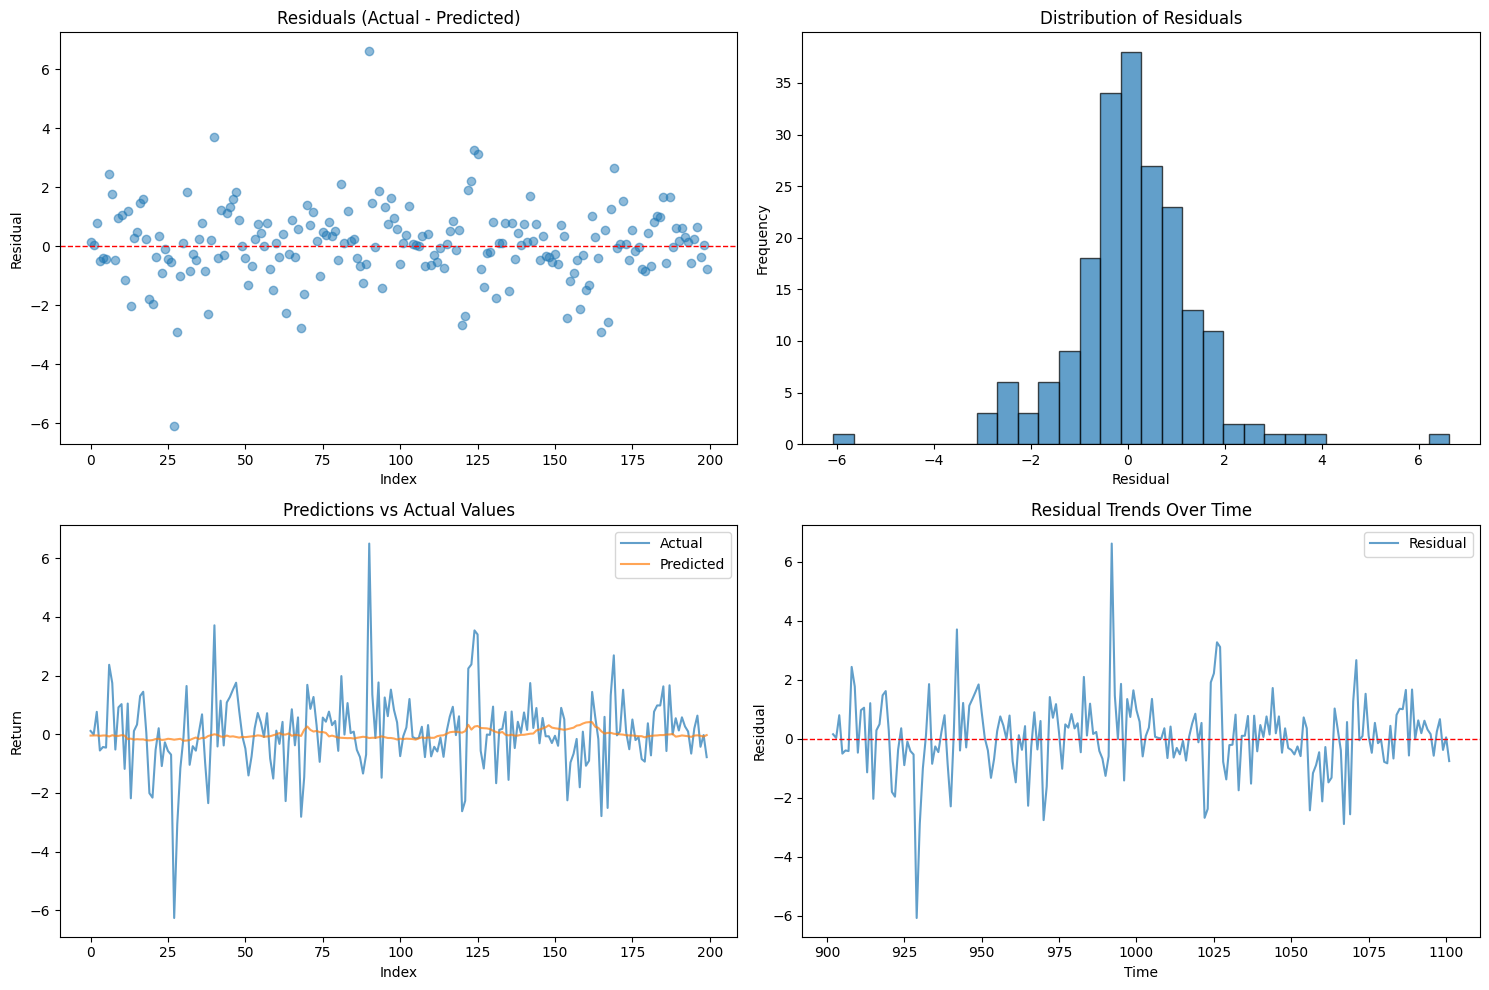

In [81]:
import matplotlib.pyplot as plt
import pandas as pd

# Compute prediction residuals
residuals = y_test - y_pred[:, 0]

# Calculate additional error metrics
errors_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred[:, 0],
    "Residual": residuals
})

# Create a single figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot residuals
axes[0, 0].scatter(range(len(residuals)), residuals, alpha=0.5)
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0, 0].set_title("Residuals (Actual - Predicted)")
axes[0, 0].set_xlabel("Index")
axes[0, 0].set_ylabel("Residual")

# Distribution of residuals
axes[0, 1].hist(residuals, bins=30, edgecolor='k', alpha=0.7)
axes[0, 1].set_title("Distribution of Residuals")
axes[0, 1].set_xlabel("Residual")
axes[0, 1].set_ylabel("Frequency")

# Compare predictions vs actuals
axes[1, 0].plot(y_test.values, label='Actual', alpha=0.7)
axes[1, 0].plot(y_pred, label='Predicted', alpha=0.7)
axes[1, 0].set_title("Predictions vs Actual Values")
axes[1, 0].set_xlabel("Index")
axes[1, 0].set_ylabel("Return")
axes[1, 0].legend()

# Analyze error trends over time
axes[1, 1].plot(errors_df["Residual"], label="Residual", alpha=0.7)
axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1, 1].set_title("Residual Trends Over Time")
axes[1, 1].set_xlabel("Time")
axes[1, 1].set_ylabel("Residual")
axes[1, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()



#### **Top-Left: Residuals (Actual - Predicted)**
- The scatterplot of residuals shows that they are mostly centered around 0, indicating that the model is unbiased in its predictions. 
- However, there are noticeable outliers, both positive and negative, suggesting that the model struggles with extreme values.

#### **Top-Right: Distribution of Residuals**
- The histogram reveals that the residuals roughly follow a normal distribution centered around 0, which is expected for a well-behaved regression model.
- The distribution shows a slight skewness, indicating potential model underperformance for specific data ranges.

#### **Bottom-Left: Predictions vs Actual Values**
- The plot compares predicted and actual returns over time. The predicted values tend to follow the trend of the actual values but with much less variability.
- This suggests that the model smooths predictions and struggles to capture the magnitude of extreme returns.

#### **Bottom-Right: Residual Trends Over Time**
- Residuals over time fluctuate randomly around 0, indicating that the model does not exhibit significant temporal bias.
- However, certain periods show spikes in residuals, which may correspond to specific market conditions or outlier events.

#### Insights and Some possible direction:
1. **Model Performance**:
   - The model captures general trends but struggles with extreme values and variability. This behavior is common in stock return predictions due to high noise and non-linear relationships in financial data.

2. **Possible Improvements**:
   - **Model Complexity**: Consider using more complex models like LSTM or GRU, which may capture temporal dependencies better.
   - **Hyperparameter Tuning**: Further fine-tune model parameters to improve performance.

3. **Handling Outliers**:
   - Analyze outliers separately and consider data transformations or robust loss functions to reduce their impact on the model.


## Model 6: revise deep RNN

In [82]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import regularizers

# Parameters
input_seq_len = 50    # Number of past days to use for prediction
output_seq_len = 200   # Number of future days to predict

df_wide_filtered_fe = df_wide_filtered_fe.sort_values('Dt')

# Extract features and target
X = df_wide_filtered_fe.drop(columns=['AAPL_Future_Return', 'Dt'], errors='ignore').values
y = df_wide_filtered_fe['AAPL_Future_Return'].values

# Initialize and fit the scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Function to create sequences
def create_sequences(X, y, input_len, output_len):
    Xs, ys = [], []
    for i in range(len(X) - input_len - output_len + 1):
        Xs.append(X[i:i+input_len])
        ys.append(y[i+input_len:i+input_len+output_len])
    return np.array(Xs), np.array(ys)

# Create sequences
X_seq, y_seq = create_sequences(X_scaled, y, input_seq_len, output_seq_len)

# Split into training and testing sets
train_size = len(X_seq) - 200
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# Verify shapes
print("X_train shape:", X_train.shape)  # (num_train_samples, input_seq_len, num_features)
print("y_train shape:", y_train.shape)  # (num_train_samples, output_seq_len)
print("X_test shape:", X_test.shape)    # (200, input_seq_len, num_features)
print("y_test shape:", y_test.shape)    # (200, output_seq_len)

# Define the model
dropout_rate = 0.38122934287034527 # Reduced dropout rate
recurrent_dropout_rate = 0.38122934287034527 
l1_reg = 0.00021473122954413897

model6 = keras.models.Sequential([
    keras.layers.SimpleRNN(
        100,
        return_sequences=True,
        input_shape=[input_seq_len, X_train.shape[2]],  # Adjust input_shape based on features
        dropout=dropout_rate,
        recurrent_dropout=recurrent_dropout_rate,
        kernel_regularizer=regularizers.l1(l1_reg)
    ),
    keras.layers.SimpleRNN(
        100,
        return_sequences=True,
        dropout=dropout_rate,
        recurrent_dropout=recurrent_dropout_rate,
        kernel_regularizer=regularizers.l1(l1_reg)
    ),
    keras.layers.SimpleRNN(
        100,
        return_sequences=False,  # Final RNN layer does not return sequences
        dropout=dropout_rate,
        recurrent_dropout=recurrent_dropout_rate,
        kernel_regularizer=regularizers.l1(l1_reg)
    ),
    keras.layers.Dense(output_seq_len)  # Direct output layer
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])
optimizer = keras.optimizers.Adam(lr=0.01)
model6.compile(loss='mse', optimizer=optimizer, metrics=[last_time_step_mse])
model6.summary()

# Define early stopping
early_stopping = keras.callbacks.EarlyStopping(
    patience=5, 
    restore_best_weights=True,
    monitor='val_loss'
)

# Train the model
history = model6.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping]
)

X_train shape: (653, 50, 1564)
y_train shape: (653, 200)
X_test shape: (200, 50, 1564)
y_test shape: (200, 200)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 50, 100)           166500    
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 50, 100)           20100     
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense_35 (Dense)            (None, 200)               20200     
                                                                 
Total params: 226,900
Trainable params: 226,900
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


c:\Users\Joshua\anaconda3\envs\tensorflow_gpu_2.10\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - 4s 133ms/step - loss: 4.1603 - last_time_step_mse: 2.4549 - val_loss: 4.8204 - val_last_time_step_mse: 2.8434
Epoch 2/10
19/19 [==============================] - 2s 109ms/step - loss: 3.9777 - last_time_step_mse: 2.4170 - val_loss: 4.4532 - val_last_time_step_mse: 3.2955
Epoch 3/10
19/19 [==============================] - 2s 108ms/step - loss: 3.4958 - last_time_step_mse: 2.4549 - val_loss: 4.0350 - val_last_time_step_mse: 2.7867
Epoch 4/10
19/19 [==============================] - 2s 114ms/step - loss: 3.2731 - last_time_step_mse: 2.4233 - val_loss: 3.9672 - val_last_time_step_mse: 2.7824
Epoch 5/10
19/19 [==============================] - 2s 113ms/step - loss: 3.1556 - last_time_step_mse: 2.5000 - val_loss: 3.8693 - val_last_time_step_mse: 3.4180
Epoch 6/10
19/19 [==============================] - 2s 115ms/step - loss: 3.1412 - last_time_step_mse: 2.3136 - val_loss: 3.8668 - val_last_time_step_mse: 3.0367
Epoch 7/10
19/19 [=====================

1/1 [==============================] - 0s 173ms/step
MSE: 1.7105414911944465
MAE: 0.9206195325795902
Sharpe Ratio: 0.54318273


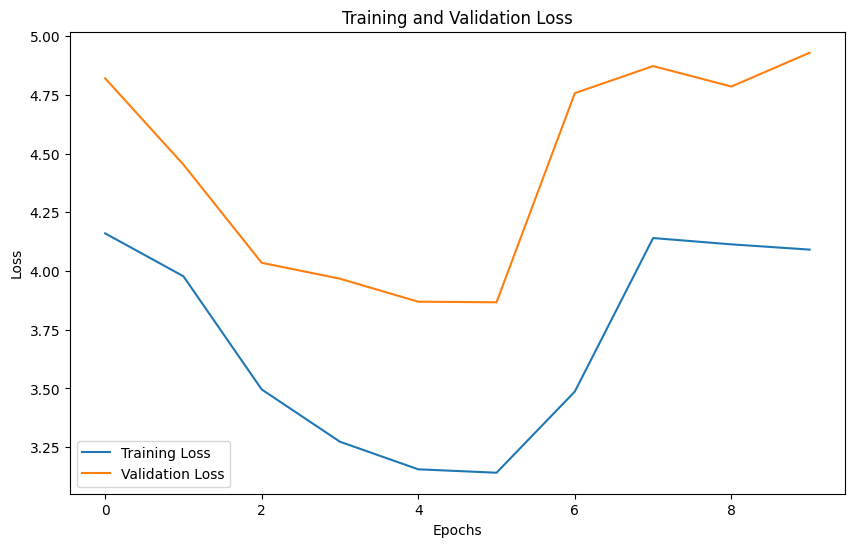

In [83]:
initial_input = X_test[-1:]
y_pred = model6.predict(initial_input)
y_pred = y_pred.flatten() 
y_test = y_test[-1,:].flatten()
mse = mean_squared_error(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test)
sharpe_ratio = np.mean(y_pred - 0) / np.std(y_pred - 0)

print("MSE:", mse)
print("MAE:", mae)
print("Sharpe Ratio:", sharpe_ratio)

# Plot the training and validation loss
plot_loss(history)

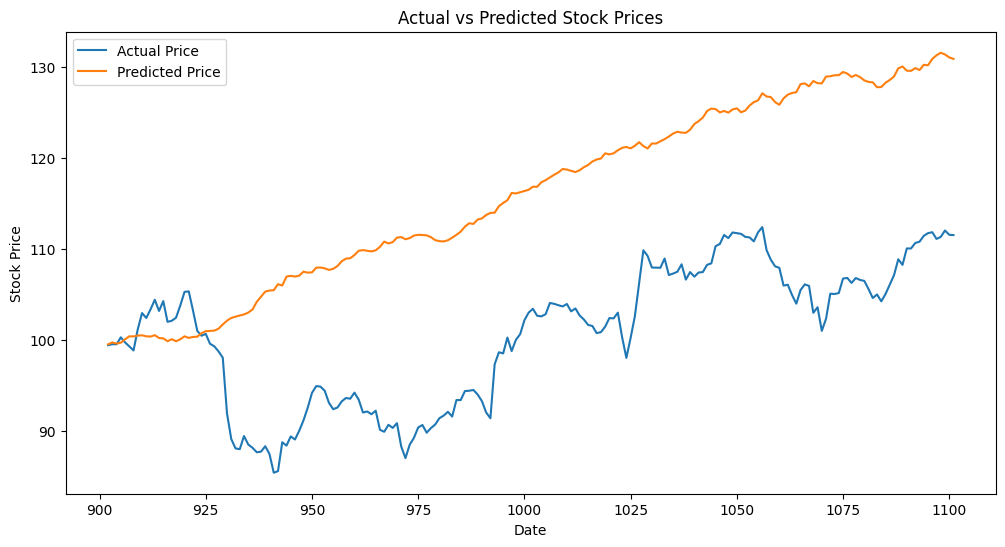

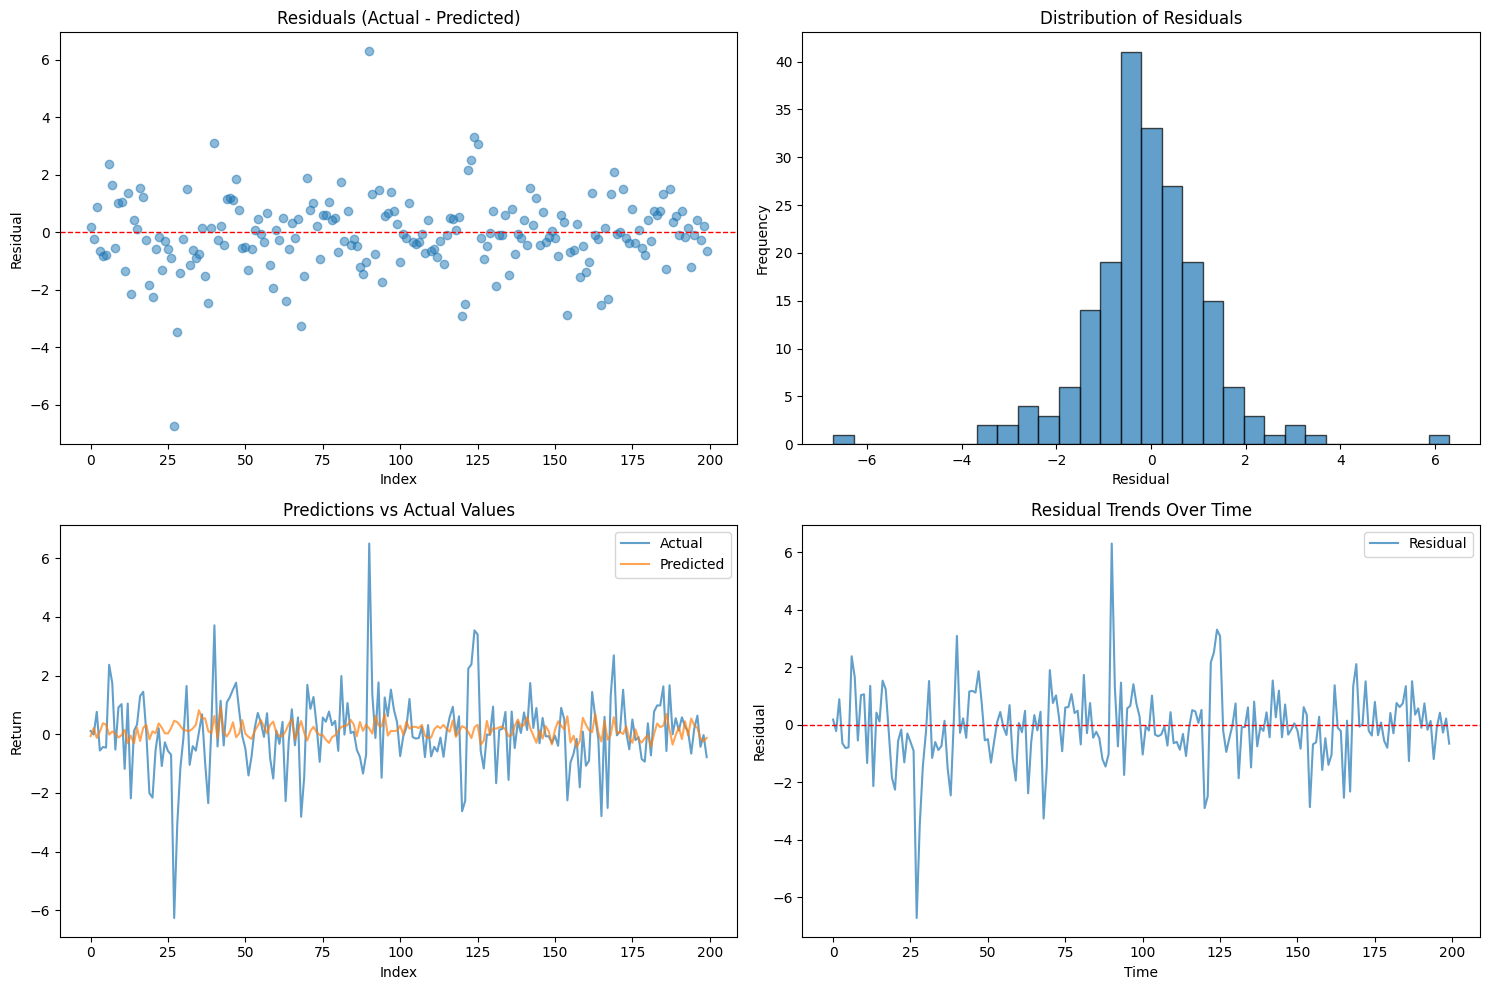

In [84]:
# Plotting the prediction with the real stock price
initial_price =df_wide_filtered_fe['AAPL_Adj Close'].iloc[-201]


# Reconstruct actual and predicted price series
actual_prices = df_wide_filtered_fe['AAPL_Adj Close'].iloc[-200:]
dates = df_wide_filtered_fe.index[-200:]

predicted_prices = (1 + y_pred/100).cumprod() * initial_price

# Plot the actual and predicted prices
plt.figure(figsize=(12, 6))
plt.plot(dates, actual_prices, label='Actual Price')
plt.plot(dates, predicted_prices, label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

# Compute prediction residuals
residuals = y_test - y_pred

# Calculate additional error metrics
errors_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred,
    "Residual": residuals
})

# Create a single figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot residuals
axes[0, 0].scatter(range(len(residuals)), residuals, alpha=0.5)
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0, 0].set_title("Residuals (Actual - Predicted)")
axes[0, 0].set_xlabel("Index")
axes[0, 0].set_ylabel("Residual")

# Distribution of residuals
axes[0, 1].hist(residuals, bins=30, edgecolor='k', alpha=0.7)
axes[0, 1].set_title("Distribution of Residuals")
axes[0, 1].set_xlabel("Residual")
axes[0, 1].set_ylabel("Frequency")

# Compare predictions vs actuals
axes[1, 0].plot(y_test, label='Actual', alpha=0.7)
axes[1, 0].plot(y_pred, label='Predicted', alpha=0.7)
axes[1, 0].set_title("Predictions vs Actual Values")
axes[1, 0].set_xlabel("Index")
axes[1, 0].set_ylabel("Return")
axes[1, 0].legend()

# Analyze error trends over time
axes[1, 1].plot(errors_df["Residual"], label="Residual", alpha=0.7)
axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1, 1].set_title("Residual Trends Over Time")
axes[1, 1].set_xlabel("Time")
axes[1, 1].set_ylabel("Residual")
axes[1, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()


### Analysis of Results

#### **1. Training and Validation Loss**
- The first figure illustrates the training and validation loss over epochs. 
  - Both losses decrease consistently during the initial epochs, indicating learning.
  - The validation loss plateaus, suggesting the model reaches its best generalization around this point.
  - There is no indication of significant overfitting.

#### **2. Actual vs. Predicted Stock Prices**
- The second figure compares the predicted stock prices with the actual stock prices.
  - The predicted prices capture the general upward trend but fail to model the high-frequency fluctuations accurately.
  - A systematic deviation from actual prices is visible, indicating bias in the predictions.

#### **3. Residual Analysis**
- The third set of figures provides detailed residual analysis:
  - **Residuals (Actual - Predicted):**
    - The residuals scatter plot shows a random distribution around zero, indicating no clear pattern, which suggests that the model does not overfit.
  - **Distribution of Residuals:**
    - The histogram of residuals reveals a roughly normal distribution, but a few outliers exist.
  - **Predictions vs. Actual Values:**
    - The time series comparison shows that predictions approximate the general movement of returns but fail to capture high-frequency noise.
  - **Residual Trends Over Time:**
    - Residuals do not exhibit significant temporal trends, confirming the model's consistent performance across time.

### Key Observations
1. The model effectively captures the overall trends but struggles with short-term fluctuations in stock prices or returns.
2. Despite no apparent overfitting, the predictions exhibit a bias, consistently overestimating the actual values in certain periods.
3. Further improvement might involve introducing additional features or enhancing the model complexity with regularization techniques to address bias while maintaining generalization.

## Model 7

The analysis indicates that while the model captures the overall trends in stock prices, it struggles with high-frequency fluctuations and exhibits some bias. To address these issues, we'll consider several enhancements:

1. **Upgrade RNN Layers:** Switch from `SimpleRNN` to more powerful architectures like `LSTM` or `GRU` that better capture long-term dependencies.
2. **Adjust Dropout and Regularization:** Fine-tune dropout rates and regularization to balance bias and variance.
3. **Incorporate Attention Mechanisms:** Allow the model to focus on relevant parts of the input sequence.
4. **Enhance Feature Engineering:** Introduce additional features that can help the model understand market dynamics better.
5. **Optimize Hyperparameters:** Use techniques like learning rate scheduling or early stopping more effectively.
6. **Evaluate Alternative Loss Functions and Metrics:** Consider metrics that better align with your prediction goals.

In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import GRU, Dense, Dropout, Input, Attention
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Function to create sequences
def create_sequences(X, y, input_len, output_len):
    Xs, ys = [], []
    for i in range(len(X) - input_len - output_len + 1):
        Xs.append(X[i:i+input_len])
        ys.append(y[i+input_len:i+input_len+output_len])
    return np.array(Xs), np.array(ys)

# Parameters
input_seq_len = 50    # Number of past days to use for prediction
output_seq_len = 1  # Number of future days to predict

df_wide_filtered_fe = df_wide_filtered_fe.sort_values('Dt')

# Split into training and testing sets before scaling
train_size = len(df_wide_filtered_fe) - 200
train_data = df_wide_filtered_fe.iloc[:train_size]
test_data = df_wide_filtered_fe.iloc[train_size:]

# Extract features and target
X_train = train_data.drop(columns=['AAPL_Future_Return', 'Dt'], errors='ignore').values
y_train = train_data['AAPL_Future_Return'].values
X_test = test_data.drop(columns=['AAPL_Future_Return', 'Dt'], errors='ignore').values
y_test = test_data['AAPL_Future_Return'].values

# Fit the scaler only on training data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

# Transform the test data using the training scaler
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Create sequences for training and testing sets
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, input_seq_len, output_seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, input_seq_len, output_seq_len)

# Define the model
dropout_rate = 0.38122934287034527 # Reduced dropout rate
recurrent_dropout_rate = 0.38122934287034527 
l1_reg = 0.00021473122954413897

model7 = Sequential([
    GRU(
        128,  # Increased number of units
        return_sequences=True,
        input_shape=[input_seq_len, X_train_seq.shape[2]],  # Adjust input_shape based on features
        dropout=dropout_rate,
        recurrent_dropout=recurrent_dropout_rate,
        kernel_regularizer=regularizers.l1(l1_reg)
    ),
    GRU(
        128,
        return_sequences=True,
        dropout=dropout_rate,
        recurrent_dropout=recurrent_dropout_rate,
        kernel_regularizer=regularizers.l1(l1_reg)
    ),
    GRU(
        128,
        return_sequences=False,  # Final RNN layer does not return sequences
        dropout=dropout_rate,
        recurrent_dropout=recurrent_dropout_rate,
        kernel_regularizer=regularizers.l1(l1_reg)
    ),
    Dense(output_seq_len)  # Direct output layer
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

optimizer = keras.optimizers.Adam(learning_rate=0.001)  # Reduced learning rate for stability
model7.compile(loss='mse', optimizer=optimizer, metrics=[last_time_step_mse])
model7.summary()

# Define early stopping
early_stopping = EarlyStopping(
    patience=10,  # Increased patience to allow more epochs
    restore_best_weights=True,
    monitor='val_loss',
    mode='min'
)

# Train the model
history = model7.fit(
    X_train_seq, y_train_seq,
    epochs=100,  # Increased number of epochs
    batch_size=64,  # Increased batch size for faster training
    validation_split=0.1,
    callbacks=[early_stopping]
)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 50, 128)           650496    
                                                                 
 gru_4 (GRU)                 (None, 50, 128)           99072     
                                                                 
 gru_5 (GRU)                 (None, 128)               99072     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 848,769
Trainable params: 848,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
12/12 [==============================] - 7s 387ms/step - loss: 5.6366 - last_time_step_mse: 1.1043 - val_loss: 5.4789 - val_last_time_step_mse: 0.9822
Epoch 2/100
12/12

5/5 [==============================] - 0s 49ms/step
MSE: 1.9328124004279796
MAE: 1.0294880337833177
Sharpe Ratio: -0.185984


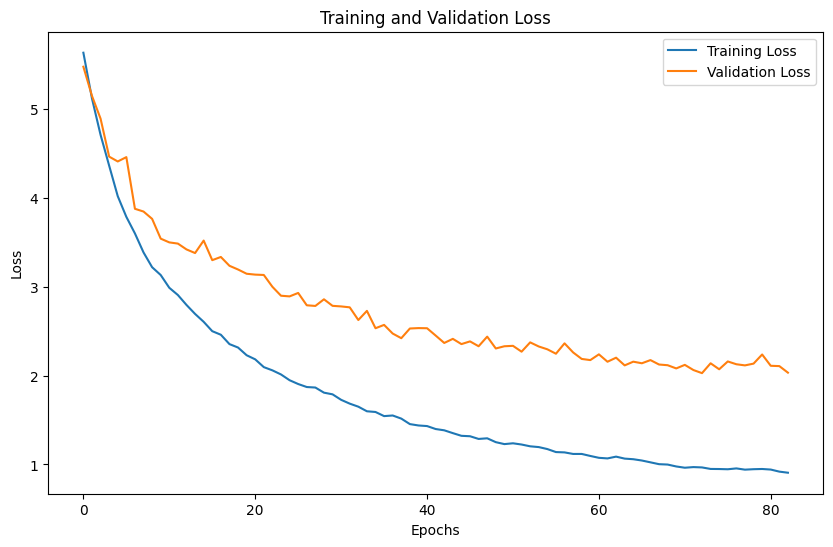

In [45]:
y_pred = model7.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred)
mse = mean_squared_error(y_pred, y_test[-150:])
mae = mean_absolute_error(y_pred, y_test[-150:])
sharpe_ratio = np.mean(y_pred - 0) / np.std(y_pred - 0)

print("MSE:", mse)
print("MAE:", mae)
print("Sharpe Ratio:", sharpe_ratio)

plot_loss(history)

## Model 8  Incorporate Attention Mechanisms

Attention mechanisms allow the model to focus on specific parts of the input sequence that are more relevant for making predictions. This can enhance the model's ability to capture important temporal patterns and reduce bias.

In [47]:
from tensorflow.keras.layers import Layer

# Define a custom Attention layer 
class CustomAttention(Layer):
    def __init__(self, **kwargs):
        super(CustomAttention, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="random_normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super(CustomAttention, self).build(input_shape)
    
    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

# Parameters
input_seq_len = 50    # Number of past days to use for prediction
output_seq_len = 50  # Number of future days to predict

# Split into training and testing sets before scaling
train_size = len(df_wide_filtered_fe) - 300
train_data = df_wide_filtered_fe.iloc[:train_size]
test_data = df_wide_filtered_fe.iloc[train_size:]

# Extract features and target
X_train = train_data.drop(columns=['AAPL_Future_Return', 'Dt'], errors='ignore').values
y_train = train_data['AAPL_Future_Return'].values
X_test = test_data.drop(columns=['AAPL_Future_Return', 'Dt'], errors='ignore').values
y_test = test_data['AAPL_Future_Return'].values

# Fit the scaler only on training data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

# Transform the test data using the training scaler
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Create sequences for training and testing sets
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, input_seq_len, output_seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, input_seq_len, output_seq_len)

inputs = Input(shape=(input_seq_len, X_train_seq.shape[2]))
x = GRU(
    128,
    return_sequences=True,
    dropout=dropout_rate,
    recurrent_dropout=recurrent_dropout_rate,
    kernel_regularizer=regularizers.l1(l1_reg)
)(inputs)
x = GRU(
    128,
    return_sequences=True,
    dropout=dropout_rate,
    recurrent_dropout=recurrent_dropout_rate,
    kernel_regularizer=regularizers.l1(l1_reg)
)(x)
x = GRU(
    128,
    return_sequences=True,  # Keep sequences for Attention
    dropout=dropout_rate,
    recurrent_dropout=recurrent_dropout_rate,
    kernel_regularizer=regularizers.l1(l1_reg)
)(x)
# Apply Attention
attention = CustomAttention()(x)
# Output layer
outputs = Dense(output_seq_len)(attention)

model8_attention = Model(inputs=inputs, outputs=outputs)
model8_attention.compile(loss='mse', optimizer=optimizer, metrics=[last_time_step_mse])
model8_attention.summary()

# Train the model with Attention
history_attention = model8_attention.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping]
)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 1564)]        0         
                                                                 
 gru_9 (GRU)                 (None, 50, 128)           650496    
                                                                 
 gru_10 (GRU)                (None, 50, 128)           99072     
                                                                 
 gru_11 (GRU)                (None, 50, 128)           99072     
                                                                 
 custom_attention_1 (CustomA  (None, 128)              178       
 ttention)                                                       
                                                                 
 dense_3 (Dense)             (None, 50)                6450      
                                                           

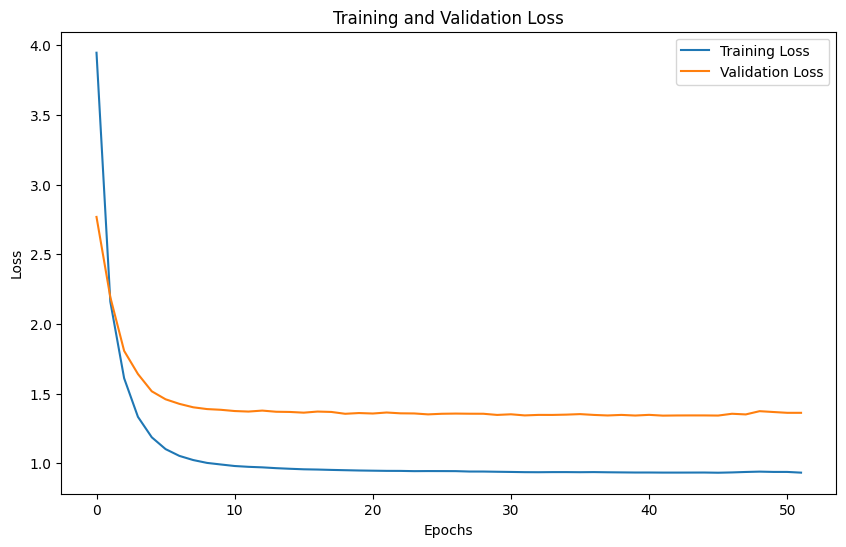

In [74]:
plot_loss(history_attention)

In [66]:
y_pred_scaled = model8_attention.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_seq)


7/7 [==============================] - 0s 46ms/step


In [75]:
# Flatten the arrays to compute overall metrics
y_test_flat = y_test_actual.flatten()
y_pred_flat = y_pred.flatten()

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_flat, y_pred_flat)
print(f"Overall Mean Squared Error (MSE): {mse}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_flat, y_pred_flat)
print(f"Overall Mean Absolute Error (MAE): {mae}")

Overall Mean Squared Error (MSE): 2.1695846620531287
Overall Mean Absolute Error (MAE): 1.0467660103216156


In [76]:
# Initialize lists to store metrics for each timestep
mse_per_timestep = []
mae_per_timestep = []

# Calculate MSE and MAE for each timestep
for i in range(y_test_actual.shape[1]):
    mse_i = mean_squared_error(y_test_actual[:, i], y_pred[:, i])
    mae_i = mean_absolute_error(y_test_actual[:, i], y_pred[:, i])
    mse_per_timestep.append(mse_i)
    mae_per_timestep.append(mae_i)
    print(f"Timestep {i+1}: MSE = {mse_i}, MAE = {mae_i}")

# Convert lists to NumPy arrays for further analysis or visualization
mse_per_timestep = np.array(mse_per_timestep)
mae_per_timestep = np.array(mae_per_timestep)

# Optional: Create a DataFrame for easier handling
metrics_df = pd.DataFrame({
    'Timestep': np.arange(1, y_test_actual.shape[1] + 1),
    'MSE': mse_per_timestep,
    'MAE': mae_per_timestep
})

print(metrics_df)


Timestep 1: MSE = 2.5997977141173787, MAE = 1.1265013379386883
Timestep 2: MSE = 2.643625704385474, MAE = 1.1388684572286503
Timestep 3: MSE = 2.5310218019156387, MAE = 1.118494163706492
Timestep 4: MSE = 2.5991065363056682, MAE = 1.1421414635808442
Timestep 5: MSE = 2.6769862849886685, MAE = 1.1675885046074226
Timestep 6: MSE = 2.6574007649676896, MAE = 1.1636512680530209
Timestep 7: MSE = 2.623498916489187, MAE = 1.1598539157109329
Timestep 8: MSE = 2.6566337503707618, MAE = 1.1721892304579418
Timestep 9: MSE = 2.6845512995803227, MAE = 1.1886131034621104
Timestep 10: MSE = 2.5779137104025267, MAE = 1.1472826184014793
Timestep 11: MSE = 2.5935106232639966, MAE = 1.1545750720454981
Timestep 12: MSE = 2.5738607391066637, MAE = 1.146499597210868
Timestep 13: MSE = 2.471631308183606, MAE = 1.1300913423777779
Timestep 14: MSE = 2.378056072814342, MAE = 1.094314136776029
Timestep 15: MSE = 2.3691896462934046, MAE = 1.091628043153136
Timestep 16: MSE = 2.1719466230497773, MAE = 1.0744068584

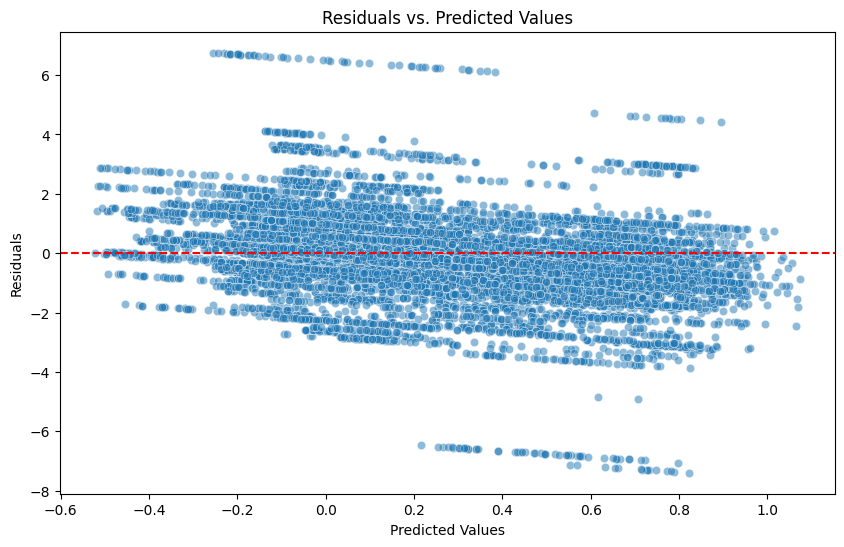

In [67]:
# Calculate residuals
residuals = y_test_actual - y_pred

# For analysis, you might want to flatten the residuals
residuals_flat = residuals.flatten()
# Flatten the predictions for plotting
y_pred_flat = y_pred.flatten()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_flat, y=residuals_flat, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()


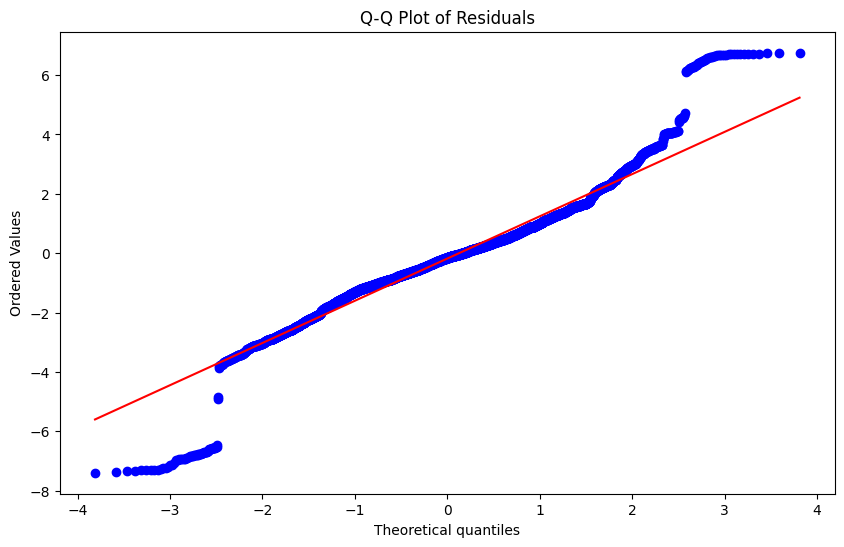

In [69]:
plt.figure(figsize=(10, 6))
stats.probplot(residuals_flat, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

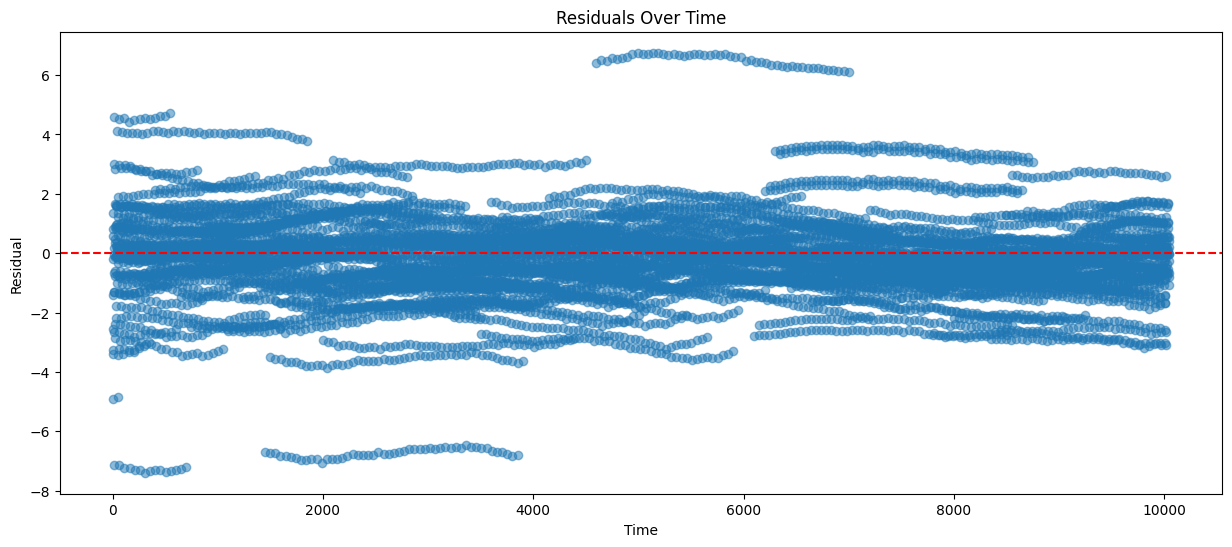

In [70]:
time_index = np.arange(len(residuals_flat))

plt.figure(figsize=(15, 6))
plt.plot(time_index, residuals_flat, marker='o', linestyle='', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.title('Residuals Over Time')
plt.show()

In [71]:
residuals_df = pd.DataFrame({'Residuals': residuals_flat})

print(residuals_df.describe())

          Residuals
count  10050.000000
mean      -0.181100
std        1.461848
min       -7.394364
25%       -0.945164
50%       -0.154755
75%        0.534477
max        6.751603


In [72]:
# Shapiro-Wilk Test
shapiro_test = stats.shapiro(residuals_flat)
print('Shapiro-Wilk Test:', shapiro_test)

# Kolmogorov-Smirnov Test
ks_test = stats.kstest(residuals_flat, 'norm', args=(residuals_flat.mean(), residuals_flat.std()))
print('Kolmogorov-Smirnov Test:', ks_test)

# Anderson-Darling Test
anderson_test = stats.anderson(residuals_flat, dist='norm')
print('Anderson-Darling Test:', anderson_test)


Shapiro-Wilk Test: ShapiroResult(statistic=0.9454086809292571, pvalue=2.765574113492237e-51)
Kolmogorov-Smirnov Test: KstestResult(statistic=0.06565273568111069, pvalue=4.1771743294937454e-38, statistic_location=-1.225846406992753, statistic_sign=-1)
Anderson-Darling Test: AndersonResult(statistic=92.99200675006432, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-0.18110044787814603, scale=1.4618481202368747)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


c:\Users\Joshua\anaconda3\envs\tensorflow_gpu_2.10\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10050.
  res = hypotest_fun_out(*samples, **kwds)


Overall, the model is strugle to predict more than one date.

#### 1. **Training and Validation Loss Plot**
   - **Observations**:
     - Training and validation losses both decrease steadily, showing the model is learning effectively.
     - A small gap between training and validation losses indicates low overfitting.
     - The validation loss plateaus after around 20 epochs, suggesting the model has reached its optimal capacity.
   - **Inprovement**:
     - Implement stronger **early stopping** criteria to halt training when the validation loss stops improving, avoiding unnecessary computations.
     - The learning process is stable, so the architecture seems suitable for the task.


#### 2. **Actual vs. Predicted Stock Prices**
   - **Observations**:
     - The predicted prices (orange line) follow the general trend of the actual prices (blue line) but are much smoother.
     - The model struggles to capture short-term volatility or spikes in stock prices.
   - **Implications**:
     - The attention mechanism might not be fully leveraging the most critical timesteps to predict sharp price movements.
     - The model is likely regularized to avoid overfitting, which smooths predictions at the cost of underfitting high-frequency variations.
   - **Recommendations**:
     - Explore tuning the attention mechanism, such as adjusting the weight initialization.
     - Adding features that reflect market events or news sentiment to capture sharp movements better might be helpful. However, this is beyond the final project.

---

#### 4. **Residual Analysis**
   - **Residuals vs. Predictions**:
     - The residuals are fairly evenly distributed around 0, indicating the model does not exhibit a strong bias.
     - However, there are occasional large residuals, suggesting the model misses certain extreme predictions.
   - **Distribution of Residuals**:
     - The residuals are approximately normally distributed, which is a positive sign for the model's performance.
     - Extreme residuals (long tails) may be linked to unexpected market events or unmodeled external factors.
   - **Trends Over Time**:
     - Residuals do not exhibit strong autocorrelation or time-dependent patterns, showing the model has captured the temporal dependencies effectively.
   - **Recommendation for future Improvement**:
     - Investigate periods with large residuals (e.g., spikes in residual trends) to determine whether external factors (e.g., news, earnings reports) are causing the deviations.     
     - Introduce features such as event indicators, macroeconomic data, or technical indicators to help the model handle these outliers.


# Submission requirements

The guidelines will be similar to the Midterm
- you will write a procedure that takes raw data and produces predictions

You will submit a *single* model for evaluation.

**Demonstrate that all cells in your notebook work**

The final cell in your notebook should print the message "Done"
- `print("Done")`
- If we run your notebook and this last cell does not execute your submission will be inadequate

## Testing

*You must perform out of sample testing*.

If you want to perform cross-validation in training, that is fine, but you
must *also* test out of sample to show that you are not over-fitting.

It is up to you to create the out of sample data that you feel best evaluates your model.

We will create holdout data (that we will not show you) for grading.

The procedure you write to make predictions should be able to work on the unseen holdout data
(similar to how it should work for your test set but the holdout set has *no targets*)

    

# The data

Data will be provided to you 
- as multiple files in a directory which we refer to as a *data directory*

The reason for this is that the different files may convey different information.

You will be responsible for deciding
- which files to use
- which fields within the files to use

We will give you a data directory for training.

# Submission guidelines

Here are the basics, a code template that you must complete is in the following cells
- you will be required to store  your model in a file
- you will be required to write a procedure `MyModel` that takes two arguments
    - `test_dir`
        - this is a *relative path* to the holdout data directory
    - `model_save_file`
        - this is a *relative path* to the file containing your model
- the holdout data directory is similar in structure to the training data directory
    - but without target labels !  It is your job to predict these.
- your procedure must produce predictions given this holdout data directory

This means that your procedure must
- prepare the files in the holdout data directory similar to the way that they were prepared in the training data directory

We will provide you with a sample data directory that will resemble the holdout -- this is so that you
may test the procedure you write for submission.



## Detailed submission guidelines


In **addition to your notebook that trains/evaluates your model**, 
- please also submit the file that contains your trained model.
    - use `saveModel` to put your final, trained model in this file
- We will **not** train your model; we will only use the method `MyModel`
    - which **you** will implement
    - and which uses `loadModel` and the name of the file in which the model was saved
    - this will create the model that we will evaluate


Here is a code template for you to complete
- it will save your model (assuming it is in variable `my_model`)
- it provides the specification for procedure `MyModel`, which *you must complete*


In [80]:
# to maximum the information in the data, I'll use the whole dataset to train the model, and predict only one day ahead
input_seq_len = 50    # Number of past days to use for prediction
output_seq_len = 1   # Number of future days to predict

df_wide_filtered_fe = df_wide_filtered_fe.sort_values('Dt')

# Extract features and target
X = df_wide_filtered_fe.drop(columns=['AAPL_Future_Return', 'Dt'], errors='ignore').values
y = df_wide_filtered_fe['AAPL_Future_Return'].values

# Initialize and fit the scaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Function to create sequences
def create_sequences(X, y, input_len, output_len):
    Xs, ys = [], []
    for i in range(len(X) - input_len - output_len + 1):
        Xs.append(X[i:i+input_len])
        ys.append(y[i+input_len:i+input_len+output_len])
    return np.array(Xs), np.array(ys)

# Create sequences
X_seq, y_seq = create_sequences(X_scaled, y_scaled, input_seq_len, output_seq_len)

inputs = Input(shape=(input_seq_len, X_seq.shape[2]))
x = GRU(
    128,
    return_sequences=True,
    dropout=dropout_rate,
    recurrent_dropout=recurrent_dropout_rate,
    kernel_regularizer=regularizers.l1(l1_reg)
)(inputs)
x = GRU(
    128,
    return_sequences=True,
    dropout=dropout_rate,
    recurrent_dropout=recurrent_dropout_rate,
    kernel_regularizer=regularizers.l1(l1_reg)
)(x)
x = GRU(
    128,
    return_sequences=True,  # Keep sequences for Attention
    dropout=dropout_rate,
    recurrent_dropout=recurrent_dropout_rate,
    kernel_regularizer=regularizers.l1(l1_reg)
)(x)
# Apply Attention
attention = CustomAttention()(x)
# Output layer
outputs = Dense(output_seq_len)(attention)

model8_attention_final = Model(inputs=inputs, outputs=outputs)
model8_attention_final.compile(loss='mse', optimizer=optimizer, metrics=[last_time_step_mse])
model8_attention_final.summary()

# Train the model with Attention
history_attention = model8_attention_final.fit(
    X_seq, y_seq,
    epochs=100,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping]
)

import joblib

scaler_save_path_X = 'scaler_X.save'
scaler_save_path_y = 'scaler_y.save'
joblib.dump(scaler_X, scaler_save_path_X)
joblib.dump(scaler_y, scaler_save_path_y)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 1564)]        0         
                                                                 
 gru_12 (GRU)                (None, 50, 128)           650496    
                                                                 
 gru_13 (GRU)                (None, 50, 128)           99072     
                                                                 
 gru_14 (GRU)                (None, 50, 128)           99072     
                                                                 
 custom_attention_2 (CustomA  (None, 128)              178       
 ttention)                                                       
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                           

['scaler_y.save']

In [81]:


modelName = "final_model"
model_path = os.path.join(".", modelName)

def load_all_data(data_dir):
    """
    Load stock data for all CSV files in the given directory and combine them into one DataFrame.

    Parameters:
        data_dir (str): Path to the data directory.

    Returns:
        df (DataFrame): Pandas DataFrame containing the combined stock data for all tickers.
    """
    all_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
    df_list = []

    for file_name in all_files:
        file_path = os.path.join(data_dir, file_name)
        temp_df = pd.read_csv(file_path)

        ticker = file_name.replace('.csv', '')
        temp_df['Ticker'] = ticker

        df_list.append(temp_df)

    # Concatenate all individual DataFrames into one
    df = pd.concat(df_list, ignore_index=True)

    return df

def pivot_dataframe(df, index_cols=['Dt'], ticker_col='Ticker'):
    """
    Pivot the dataframe to a wide format with the specified ticker column as new columns.

    Parameters:
    - df (pd.DataFrame): The input DataFrame to pivot.
    - index_cols (list of str): Columns to set as the index in the pivoted DataFrame.
                                Defaults to ['Dt'].
    - ticker_col (str): The column whose unique values will become the new columns.
                        Defaults to 'Ticker'.

    Returns:
    - pd.DataFrame: The pivoted DataFrame in wide format with flattened column names.
    """
    # Identify the value columns by excluding index and ticker columns
    value_cols = [col for col in df.columns if col not in index_cols + [ticker_col]]
    
    # Pivot the DataFrame so that the ticker values become the new columns
    df_wide = df.pivot(index=index_cols, columns=ticker_col, values=value_cols)
    
    # Check if the pivot resulted in a MultiIndex for columns
    if isinstance(df_wide.columns, pd.MultiIndex):
        # Flatten the MultiIndex columns
        df_wide.columns = [f"{val}_{key}" for key, val in df_wide.columns]
    else:
        # If columns are not MultiIndex, append the ticker column name
        df_wide.columns = [f"{val}_{ticker_col}" for val in df_wide.columns]
    
    # Reset the index to turn the index columns back into regular columns
    df_wide = df_wide.reset_index()
    
    return df_wide

def calculate_returns(df):
    """
    Calculate daily returns for all stocks based on Adjusted Close prices.

    Parameters:
        df (DataFrame): Stock data in wide format.

    Returns:
        df (DataFrame): DataFrame with new columns for daily returns of each stock.
    """
    # Make a copy of the DataFrame to avoid SettingWithCopyWarning
    df = df.copy()

    # Identify all columns related to Adjusted Close prices
    adj_close_cols = [col for col in df.columns if '_Adj Close' in col]

    # Create new columns for returns
    for col in adj_close_cols:
        return_col = col.replace('_Adj Close', '_Return')
        df.loc[:, return_col] = df[col].pct_change() * 100  # Use .loc for setting values

    # Drop rows with NaN (caused by pct_change) if needed
    df = df.dropna()

    return df

def add_log_return(df):
    """
    Add Log Return as a feature for all stocks.

    Parameters:
        df (DataFrame): Stock data with multiple 'Adj Close' columns.

    Returns:
        df (DataFrame): DataFrame with Log Return features added for each stock.
    """
    # Identify all columns with 'Adj Close'
    adj_close_cols = [col for col in df.columns if 'Adj Close' in col]

    # List to store log return DataFrames
    log_return_dfs = []

    for col in adj_close_cols:
        stock_name = col.split('_')[0]  # Extract stock name, e.g., "AAPL"

        # Calculate log return
        log_return = np.log(df[col] / df[col].shift(1)) * 100
        log_return_dfs.append(log_return.rename(f'{stock_name}_Log_Return'))

    # Combine all the new columns into a DataFrame
    log_return_df = pd.concat(log_return_dfs, axis=1)

    # Concatenate with the original DataFrame
    df = pd.concat([df, log_return_df], axis=1)

    # Drop rows with NaN values caused by log return calculations
    df.dropna(inplace=True)

    return df

def add_risk_adjusted_return(df, window=20):
    """
    Add Risk-Adjusted Return, Rolling Mean, and Rolling Standard Deviation as features for all stocks.

    Parameters:
        df (DataFrame): Stock data with multiple 'Return' columns.
        window (int): Rolling window size for calculating features.

    Returns:
        df (DataFrame): DataFrame with new features added for each stock.
    """
    # Identify all columns with 'Return'
    return_cols = [col for col in df.columns if 'Return' in col and 'Future' not in col and 'L' not in col]

    # List to store the new DataFrames
    risk_adjusted_dfs = []

    for col in return_cols:
        stock_name = col.split('_')[0]  # Extract stock name, e.g., "AAPL"

        # Calculate rolling mean and rolling standard deviation
        rolling_mean = df[col].rolling(window=window).mean()
        rolling_std = df[col].rolling(window=window).std()

        # Calculate Risk-Adjusted Return
        risk_adjusted = rolling_mean / rolling_std

        # Append new features to the list
        risk_adjusted_dfs.append(rolling_mean.rename(f'{stock_name}_rolling_mean'))
        risk_adjusted_dfs.append(rolling_std.rename(f'{stock_name}_rolling_std'))
        risk_adjusted_dfs.append(risk_adjusted.rename(f'{stock_name}_Risk_Adjusted_Return'))

    # Combine all the new columns into a DataFrame
    new_features_df = pd.concat(risk_adjusted_dfs, axis=1)

    # Concatenate with the original DataFrame
    df = pd.concat([df, new_features_df], axis=1)

    # Drop rows with NaN values caused by rolling calculations
    df.dropna(inplace=True)

    return df

def create_lag_features(df, lag_days=20):
    """
    Create lag features for all return columns in the DataFrame in an optimized way.

    Parameters:
        df (DataFrame): Stock data with multiple 'Return' columns.
        lag_days (int): Number of lag days to create features for.

    Returns:
        df (DataFrame): DataFrame with lag features for each return column.
    """
    # Identify all columns that contain 'Return' (excluding 'Future_Return' if present)
    return_cols = [col for col in df.columns if '_Return' in col and 'Future' not in col]
    
    lagged_features = []  # To store the lagged features
    
    for lag in range(1, lag_days + 1):
        lagged_df = df[return_cols].shift(lag).add_suffix(f'_Lag_{lag}')
        lagged_features.append(lagged_df)

    # Concatenate the original DataFrame with all lagged features
    df = pd.concat([df] + lagged_features, axis=1)
    
    # Drop rows with NaN values caused by the lagged features
    df.dropna(inplace=True)
    
    return df

def add_technical_indicators(df):
    """
    Add technical indicators for all stocks to the DataFrame in an optimized way.

    Parameters:
        df (DataFrame): Stock data with multiple 'Adj Close' columns.

    Returns:
        df (DataFrame): DataFrame with technical indicators added for each stock.
    """
    # Identify all columns with 'Adj Close'
    adj_close_cols = [col for col in df.columns if '_Adj Close' in col]

    # List to store DataFrames with technical indicators
    indicator_dfs = []

    for col in adj_close_cols:
        stock_name = col.split('_')[0]  # Extract stock name, e.g., "AAPL"

        # Create a DataFrame to store indicators for this stock
        indicators = pd.DataFrame(index=df.index)

        # Moving Averages
        indicators[f'{stock_name}_MA_5'] = df[col].rolling(window=5).mean()
        indicators[f'{stock_name}_MA_10'] = df[col].rolling(window=10).mean()
        indicators[f'{stock_name}_MA_20'] = df[col].rolling(window=20).mean()

        # Relative Strength Index (RSI)
        delta = df[col].diff()
        up = delta.clip(lower=0)
        down = -1 * delta.clip(upper=0)
        ema_up = up.ewm(com=13, adjust=False).mean()
        ema_down = down.ewm(com=13, adjust=False).mean()
        rs = ema_up / ema_down
        indicators[f'{stock_name}_RSI'] = 100 - (100 / (1 + rs))

        # Moving Average Convergence Divergence (MACD)
        exp1 = df[col].ewm(span=12, adjust=False).mean()
        exp2 = df[col].ewm(span=26, adjust=False).mean()
        indicators[f'{stock_name}_MACD'] = exp1 - exp2

        # Append to the list
        indicator_dfs.append(indicators)

    # Concatenate all indicator DataFrames with the original DataFrame
    all_indicators = pd.concat(indicator_dfs, axis=1)
    df = pd.concat([df, all_indicators], axis=1)

    # Drop rows with NaN values caused by rolling calculations
    df.dropna(inplace=True)

    return df

def create_sequences(X, y, input_len, output_len):
    Xs, ys = [], []
    for i in range(len(X) - input_len - output_len + 1):
        Xs.append(X[i:i+input_len])
        ys.append(y[i+input_len:i+input_len+output_len])
    return np.array(Xs), np.array(ys)

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

def saveModel(model, model_path): 
    """
    Save a model

    Parameters
    ----------
    model: a Keras model object
    model_path: String.  Relative path to a file in which the model will be stored

    Returns
    -------
    model_save_file: String.  Name of the file in which the model has been saved
        - this will be model_path with the proper file-extension added
    """
    model_save_file = model_path + '.keras'
    model.save(model_save_file)
    print(f"Model saved in {model_save_file}; submit with your assignment.")
    return model_save_file

def loadModel(model_save_file):
    try:
        model = tf.keras.models.load_model(
            model_save_file,
            custom_objects={'last_time_step_mse': last_time_step_mse, 'CustomAttention': CustomAttention}
        )
        print(f"Model loaded from {model_save_file}.")        
        print("Model loaded successfully.")
        model.summary()  # Print model architecture for verification
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        raise e



def MyModel(test_dir, model_save_file):
    """
    Load the trained model(s), preprocess test data, generate predictions, and return them with IDs.
    
    Parameters:
    ----------
    test_dir: String. Path to the directory containing the test data files.
    model_save_file: String. Path to the saved Keras model file.
    Returns:
    -------
    predictions: List of return.
    id: list of prediction dates (next 200 dates) 
    """
    
    # 1. Load the Keras model
    model = loadModel(model_save_file)
    
    # 2. Load the scalers
    
    scaler_X = joblib.load('scaler_X.save')
    scaler_y = joblib.load('scaler_y.save')
    
    # 3.  Load and preprocess test data
    # Initialize an empty list to collect data from all files
    test_data_list = []
    df = load_all_data(test_dir)
    df_wide = pivot_dataframe(df)
    df_wide = df_wide[df_wide.columns[~df_wide.columns.str.contains('XLRE')]]
    df_wide_filtered = calculate_returns(df_wide)
    df_wide_filtered = add_log_return(df_wide_filtered)
    df_wide_filtered = add_risk_adjusted_return(df_wide_filtered)
    df_wide_filtered['AAPL_Future_Return'] = df_wide_filtered['AAPL_Return'].shift(-1)
    df_wide_filtered.dropna(subset=['AAPL_Future_Return'])
    df_wide_filtered_fe = create_lag_features(df_wide_filtered, lag_days=20)
    df_wide_filtered_fe = add_technical_indicators(df_wide_filtered_fe)
    
    # Extract features and target
    X = df_wide_filtered_fe.drop(columns=['AAPL_Future_Return', 'Dt'], errors='ignore').values
    y = df_wide_filtered_fe['AAPL_Future_Return'].values

    X_scaled = scaler_X.transform(X)
    y_scaled = scaler_y.transform(y.reshape(-1, 1)).flatten()

    input_seq_len = 50    # Number of past days to use for prediction
    output_seq_len = 1   # Number of future days to predict

    # Function to create sequences
    def create_sequences(X, y, input_len, output_len):
        Xs, ys = [], []
        for i in range(len(X) - input_len - output_len + 1):
            Xs.append(X[i:i+input_len])
            ys.append(y[i+input_len:i+input_len+output_len])
        return np.array(Xs), np.array(ys)
    X_seq, y_seq = create_sequences(X_scaled, y_scaled, input_seq_len, output_seq_len)

    predictions_scaled = model.predict(X_seq)
    predictions = scaler_y.inverse_transform(predictions_scaled).flatten()
    # fisrt_date = df_wide_filtered_fe['Dt'].iloc[0]
    # date = pd.date_range(start=fisrt_date + pd.Timedelta(days=1), periods=len(predictions), freq='B')
    
    date = pd.to_datetime(df_wide_filtered_fe['Dt'])


    # Convert to a list
    ids = date.tolist()    
    
    return predictions, ids

# Assign to variable my_model the model that is your final model (the one  you will be evaluated on)
my_model = model8_attention_final 

model_save_file = saveModel(my_model, model_path)

Model saved in .\final_model.keras; submit with your assignment.


## Evaluate your model on the holdout data directory

**You must run the following cell** from the directory that contains your model file

Here is how we will evaluate your submission
- we will create a directory whose only content is
    - sub-directory `Data`
- we will restore your model from the saved file`
- we will run the cell in your notebook that should be a copy of the one below
    - it calls procedure `MyModel` with the arguments given below
    - your implementation of `MyModel`
        - must successfully load your model file, *given where **we** have place it as described above*
        - must successfully return one prediction for each example in the holdout directory *given where **we** have placed the holdout directory*

In [82]:
holdout_dir = os.path.join(".", "Data", "holdout")
holdout_dir = os.path.join(".", "Data", "train")

predicts, ids = MyModel(holdout_dir, model_save_file)

Model loaded from .\final_model.keras.
Model loaded successfully.
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 1564)]        0         
                                                                 
 gru_12 (GRU)                (None, 50, 128)           650496    
                                                                 
 gru_13 (GRU)                (None, 50, 128)           99072     
                                                                 
 gru_14 (GRU)                (None, 50, 128)           99072     
                                                                 
 custom_attention_2 (CustomA  (None, 128)              178       
 ttention)                                                       
                                                                 
 dense_4 (Dense)             (None, 1)                 129 

In [83]:
print("Done")

Done
